In [1]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc, obtain_subset_from_task, plot_results_of_all_models, obtain_sr_nosr, make_plot_kde_and_test_difference, calculate_correlations
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap
# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'RNAplex', 'rnacofold', 'assa', 'risearch2', 'RNAhybrid', 'RNAup'] #['priblast', 'risearch2'] #['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
SPECIE_PARIS = 'human'
PARIS_HQ = False
PARIS_HQ_THRESHOLD = 35
MIN_N_READS_RICSEQ = 2
RICSEQ_HQ = False

RICSEQ_TEST = False
SPLASH_TEST = True

#ARGS for splash, ricseq, mario


args_datasets = {'paris':
                 {'only_test' : np.nan, #uneuseful for paris
                  'exclude_train_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_couples' : np.nan, #uneuseful for paris
                  'filter_hq_ricseq' : np.nan, #uneuseful for paris
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for paris
                  'SPECIE_PARIS' : SPECIE_PARIS,
                  'PARIS_HQ':PARIS_HQ,
                  'PARIS_HQ_THRESHOLD':PARIS_HQ_THRESHOLD,
                 }, 
                 'ricseq': 
                 {'only_test' : RICSEQ_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : RICSEQ_HQ,
                  'MIN_N_READS_RICSEQ' : MIN_N_READS_RICSEQ,
                  'SPECIE_PARIS' : np.nan, #uneuseful for ricseq
                  'PARIS_HQ':np.nan, #uneuseful for ricseq
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for ricseq
                 },
                 'splash': 
                 {'only_test' : SPLASH_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for splash
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for splash
                  'SPECIE_PARIS' : np.nan, #uneuseful for splash
                  'PARIS_HQ':np.nan, #uneuseful for splash
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for splash
                 },
                'mario': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for mario
                  'MIN_N_READS_RICSEQ' : np.nan,  #uneuseful for mario
                  'SPECIE_PARIS' : np.nan, #uneuseful for mario
                  'PARIS_HQ':np.nan, #uneuseful for mario
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for mario
                 },
}

args_datasets['test'] = args_datasets['paris'] #sometimes I want to call it 'test'

In [3]:
# nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',
#              'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043', 
#              'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079',
#             ]
nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',]

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', nt_models[0]) 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

# Model comparison

In [5]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

In [6]:
from util.evaluation import *

In [82]:
def load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, specie_paris, paris_hq, paris_hq_threshold):
    
    if type(checkpoint_dir) == str:
        checkpoint_dir = [checkpoint_dir]
    else:
        assert type(checkpoint_dir) == list
        assert type(checkpoint_dir[0]) == str

    if dataset == 'paris':
        
        test500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
        test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
        test500['distance_from_site_embedding'] = ( (test500['distance_embedding_x'] ** 2) + (test500['distance_embedding_y']** 2) )**(0.5) #pitagora
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        assert test500.shape[0] == df_nt[['couples', 'interacting']].merge(test500, on = 'couples').shape[0]
        
        for i in range(len(checkpoint_dir)):
            r = load_paris_results(checkpoint_dir[i], test500, df_nt, 'test', specie_paris)
            if paris_hq:
                r = filter_hq_data_by_interaction_length(r, test500, paris_hq_threshold)
                
            if i == 0:
                res = r.copy()
            else:
                r = r.rename({'probability':f'nt{i}'}, axis = 1)
                res = pd.concat([res, r[f'nt{i}']], axis = 1)
        
    else:
        test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
        test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
        test500['distance_from_site_embedding'] = ( (test500['distance_embedding_x'] ** 2) + (test500['distance_embedding_y']** 2) )**(0.5) #pitagora
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
        
        for i in range(len(checkpoint_dir)):
            r = load_ricseq_splash_mario_results(checkpoint_dir[i], test500, df_nt, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)
            if i == 0:
                res = r.copy()
            else:
                r = r.rename({'probability':f'nt{i}'}, axis = 1)
                res = pd.concat([res, r[f'nt{i}']], axis = 1)
    
    
    
    
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        res = res.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample', how = 'left').fillna(0)

    
    #mi serve solo per il merge, poi le elimino queste colonne
    if dataset == 'splash':
        df_nt['simple_repeats'] = np.nan
        df_nt['sine_alu'] = np.nan 
        df_nt['low_complex'] = np.nan 
    
    #now we merge with ENHN500
    testenhn500 = pd.read_csv(os.path.join(metadata_dir, f'{how}ENHN500.csv'))
    testenhn500['distance_from_site'] = ( (testenhn500['distance_x'] ** 2) + (testenhn500['distance_y']** 2) )**(0.5) #pitagora
    testenhn500['distance_from_site_embedding'] = ( (testenhn500['distance_embedding_x'] ** 2) + (testenhn500['distance_embedding_y']** 2) )**(0.5) #pitagora
    testenhn500 = df_nt[['couples', 'interacting', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(testenhn500, on = 'couples')
    
    for i in range(len(checkpoint_dir)):
        r = pd.read_csv(os.path.join(checkpoint_dir[i], f'{how}ENHN_results500.csv')).drop('policy', axis = 1)
        if i == 0:
            enhn = r.copy()
        else:
            r = r.rename({'probability':f'nt{i}'}, axis = 1)
            enhn = pd.concat([enhn, r[f'nt{i}']], axis = 1)
                
           
    #tengo solo le couples di res, perche escludo quelle che erano tipo nel training di paris, oppure solo paris human, oppure quelle < n_reads_ricseq, ecc... 
    enhn = enhn[enhn.couples.isin(res.couples)].reset_index(drop = True)
    
    #policy tengo quello di testenhn500, che sono hn, en
    enhn = enhn.merge(testenhn500.drop(['g1', 'g2'], axis = 1).rename({'couples':'id_sample'}, axis = 1), on = 'id_sample').reset_index(drop = True)
    enhn.ground_truth = 0

    enhnintarna = load_intarnaENHN500(how)
    enhn = enhn.merge(enhnintarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample', how = 'left').fillna(0)
    enhn['original_area'] = enhn.original_length1 * enhn.original_length2    

    how = how + 'ENHN'
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        enhn = enhn.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample', how = 'left').fillna(0)

    # tolgo 'E_norm_conf', 'ensemble_score'
    res = res.filter(list(enhn.columns), axis = 1)
    
    res = pd.concat([res, enhn], axis = 0).reset_index(drop=True)
    
    res = res.drop(['Unnamed: 0', 'simple_repeats', 'sine_alu', 'low_complex'], axis = 1)
    res['dataset'] = dataset
    
    return res


def load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets):
    
    assert dataset in ['psoralen', 'paris', 'splash', 'mario', 'ricseq']

    if (dataset == 'psoralen'):
        
        dataset = 'paris'
        how = 'test'
        paris = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
        
        dataset = 'splash'
        how = 'splash'
        splash = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
                  
        assert set(paris.columns) == set(splash.columns)
        res = pd.concat([paris, splash], axis = 0).reset_index(drop=True)
    
    else: 
        how = dataset
        res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
                  
    return res

In [84]:
dataset = 'psoralen'
res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets)

# excluded couples:  12


In [86]:
res.full_feature1

0                 None
1                 None
2                 None
3        Simple_repeat
4        Simple_repeat
             ...      
30118    Simple_repeat
30119             None
30120             None
30121       SINE, SINE
30122             None
Name: full_feature1, Length: 30123, dtype: object

In [9]:
res.dataset.value_counts()

paris     28346
splash     1777
Name: dataset, dtype: int64

# TODO:

VERIFICA CHE res, in tutti i set abbia dentro full_feature1, full_feature2,  feature1, feature2, e che siano sensati (che sia paris, che splash abbiano le repeats)

poi rimuovi il pezzo di codice sotto

In [81]:
for how in tqdm(['test', 'mario', 'ricseq', 'splash']):
    if how == 'splash':
        df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
    else:
        df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))
    
    for test_name in [f'{how}ENHN500.csv', f'{how}500.csv']:
        test500 = pd.read_csv(os.path.join(metadata_dir, test_name))

        gene1_parts = test500['gene1'].str.extract(r'(.*)_(.*)_(.*)')
        gene2_parts = test500['gene2'].str.extract(r'(.*)_(.*)_(.*)')

        test500['start_embedding1'] = gene1_parts[1].astype(int)
        test500['end_embedding1'] = gene1_parts[2].astype(int)
        test500['start_embedding2'] = gene2_parts[1].astype(int)
        test500['end_embedding2'] = gene2_parts[2].astype(int)

        test500['g1'] = gene1_parts[0]
        test500['g2'] = gene2_parts[0]

        # Apply the function to create the 'feature1' column in the test500 dataframe
        test500['feature1'] = test500.apply(get_features1, axis=1, args=(df_repeats,)) # test500['feature1']
        test500['feature2'] = test500.apply(get_features2, axis=1, args=(df_repeats,)) # test500['feature1']
        test500['full_feature1'] = test500.apply(get_full_overlap_features1, axis=1, args=(df_repeats,)) # test500['feature1']
        test500['full_feature2'] = test500.apply(get_full_overlap_features2, axis=1, args=(df_repeats,)) # test500['feature1']

        test500 = test500.drop(['start_embedding1', 'end_embedding1', 'start_embedding2', 'end_embedding2'], axis = 1)
        
        test500.to_csv(os.path.join(metadata_dir, test_name), index = False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [61]:
df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

In [62]:
test500['start_embedding1'] = test500.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[1].astype(int)
test500['end_embedding1'] = test500.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[2].astype(int)

test500['start_embedding2'] = test500.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[1].astype(int)
test500['end_embedding2'] = test500.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)[2].astype(int)

In [63]:
(test500['end_embedding1'] < test500['x2']).any()

False

In [71]:
((test500['start_embedding1'] + test500['x2']) <= test500['end_embedding1']).all()

True

easyneg    643
hardneg    622
Name: policy, dtype: int64

In [32]:
test500.columns

Index(['gene1', 'gene2', 'x1', 'x2', 'y1', 'y2', 'seed_x1', 'seed_x2',
       'seed_y1', 'seed_y2', 'cdna1', 'cdna2', 'len1', 'len2', 'couples', 'g1',
       'g2', 'feature1', 'feature2', 'distance_x', 'distance_y', 'policy',
       'distance_embedding_x', 'distance_embedding_y'],
      dtype='object')

In [28]:
test500.columns

Index(['gene1', 'gene2', 'x1', 'x2', 'y1', 'y2', 'seed_x1', 'seed_x2',
       'seed_y1', 'seed_y2', 'cdna1', 'cdna2', 'len1', 'len2', 'couples', 'g1',
       'g2', 'feature1', 'feature2', 'full_feature1', 'full_feature2',
       'distance_x', 'distance_y', 'policy', 'distance_embedding_x',
       'distance_embedding_y'],
      dtype='object')

In [38]:
how = 'ricseq'

if how == 'splash':
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
elif how in ['mario', 'ricseq']:
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

    
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}ENHN500.csv'))

def get_full_overlap_features1(row):
    gene_id = row['g1']
    overlaps = df_repeats[(df_repeats['gene_id'] == gene_id) & ((df_repeats['start'] >= row['x1']) & (df_repeats['end'] <= row['x2']))]
    if len(overlaps) > 0:
        return ', '.join(overlaps['feature'])
    elif gene_id in df_repeats['gene_id'].values:
        return 'None'
    else:
        return 'Not present'

def get_full_overlap_features2(row):
    gene_id = row['g2']
    overlaps = df_repeats[(df_repeats['gene_id'] == gene_id) & ((df_repeats['start'] >= row['y2']) & (df_repeats['end'] <= row['y1']))]
    if len(overlaps) > 0:
        return ', '.join(overlaps['feature'])
    elif gene_id in df_repeats['gene_id'].values:
        return 'None'
    else:
        return 'Not present'

test500['full_feature1'] = test500.apply(get_full_overlap_features1, axis=1) # test500['feature1']
test500['full_feature2'] = test500.apply(get_full_overlap_features2, axis=1) # test500['feature1']

test500 = test500.filter(['gene1', 'gene2', 'x1', 'x2', 'y1', 'y2', 'seed_x1', 'seed_x2',
       'seed_y1', 'seed_y2', 'cdna1', 'cdna2', 'len1', 'len2', 'couples', 'g1',
       'g2', 'feature1', 'feature2', 'full_feature1', 'full_feature2',
       'distance_x', 'distance_y', 'policy', 'distance_embedding_x',
       'distance_embedding_y'], axis = 1)

#test500.to_csv(os.path.join(metadata_dir, f'{how}ENHN500.csv'), index = False)

KeyboardInterrupt: 

In [36]:
test500

gene1                      gene2    x1    x2  \
0       ENSG00000167978_1805_7775     ENSG00000225190_0_5240   482   982   
1          ENSG00000138604_0_5044    ENSG00000223547_83_6053  1046  1546   
2       ENSMUSG00000014837_0_3552  ENSMUSG00000022191_0_4570  2464  2964   
3      ENSMUSG00000007097_81_6051  ENSMUSG00000020331_0_3195  5178  5678   
4       ENSMUSG00000026825_0_4605  ENSMUSG00000034801_0_5607  3887  4387   
...                           ...                        ...   ...   ...   
14015   ENSMUSG00000020986_0_4109  ENSMUSG00000075467_0_2916  1566  2066   
14016      ENSG00000130540_0_2478     ENSG00000131746_0_4087   483   983   
14017      ENSG00000149292_0_2541  ENSG00000180979_1289_7259  1211  1711   
14018      ENSG00000133961_0_5172   ENSG00000171843_681_6651  3877  4377   
14019   ENSG00000119772_1032_7002     ENSG00000242550_0_2155  3857  4357   

         y1    y2  seed_x1  seed_x2  seed_y1  seed_y2  ...  \
0       968  1468   3349.0   3372.0   4881.0   4935.0  ...   
1      3343  3843   2322.0   2349.0   5192.0   5230.0  ...   
2      3990  4490   2281.0   2308.0   4233.0   4265.0  ...   
3      1500  2000   1878.0   1918.0   2320.0   2355.0  ...   
4      3894  4394    125.0    152.0   5524.0   5549.0  ...   
...     ...   ...      ...      ...      ...      ...  ...   
14015    87   587   2422.0   2443.0   1948.0   1969.0  ...   
14016   198   698   2286.0   2310.0   2425.0   2466.0  ...   
14017  2720  3220    202.0    226.0   1977.0   2019.0  ...   
14018  1242  1742   3747.0   3767.0     84.0    118.0  ...   
14019   671  1171   2575.0   2596.0   1856.0   1876.0  ...   

                       g2                            feature1        feature2  \
0         ENSG00000225190                      Low_complexity     Not present   
1         ENSG00000223547                                None            SINE   
2      ENSMUSG00000022191  Simple_repeat, Simple_repeat, SINE            None   
3      ENSMUSG00000020331                                 DNA            None   
4      ENSMUSG00000034801                       Simple_repeat            SINE   
...                   ...                                 ...             ...   
14015  ENSMUSG00000075467                                None  Low_complexity   
14016     ENSG00000131746                                None            None   
14017     ENSG00000180979                                None      SINE, SINE   
14018     ENSG00000171843                                None   Simple_repeat   
14019     ENSG00000242550                       Simple_repeat            None   

       full_feature1  full_feature2 distance_x distance_y   policy  \
0               None    Not present     2367.0     3413.0  hardneg   
1               None    Not present      776.0     1349.0  hardneg   
2        Not present    Not present      156.0        0.0  easyneg   
3        Not present    Not present     3260.0      320.0  hardneg   
4        Not present    Not present     3735.0     1130.0  easyneg   
...              ...            ...        ...        ...      ...   
14015    Not present    Not present      356.0     1361.0  hardneg   
14016           None           None     1303.0     1727.0  hardneg   
14017    Not present           None      985.0      701.0  hardneg   
14018           None           None      110.0     1124.0  hardneg   
14019  Simple_repeat    Not present     1261.0      685.0  hardneg   

      distance_embedding_x distance_embedding_y  
0                        0                    0  
1                        0                    0  
2                        0                    0  
3                        0                    0  
4                        0                    0  
...                    ...                  ...  
14015                    0                    0  
14016                    0                    0  
14017                    0                    0  
14018                    0                    0  
14019 

In [ ]:
res = res[(res.distance_from_site_embedding == 0)&(res.policy.isin(['easypos', 'hardneg', 'easyneg']))]

In [6]:
#plot parameters
MIN_PERC = 0.5 #1 è 1%
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
n_run_undersampling = 10
list_of_metrics = ['precision', 'npv']
figsize = (17,9)
size_multiplier = 10

balance_predictions_at_each_step = True

checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]
list_of_models_to_test = list_of_models_to_test + [f'nt{_}' for _ in range(1, len(nt_models))]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def npv_precision(precision_data, npv_data, model_names, figsize):
    assert precision_data.shape == npv_data.shape
    
    num_modelli, n_points =  precision_data.shape[0], precision_data.shape[1]
    
    percentuali_neg = np.linspace(1, 100, num=n_points).astype(int)
    percentuali_pos = np.linspace(1, 100, num=n_points).astype(int)[::-1]

    percentuali = np.concatenate((percentuali_neg, percentuali_pos))
    
    # Unione dei dati di precisione e NPV in un unico array per l'asse Y
    combined_data = np.hstack((npv_data, precision_data))

    # Creiamo un array per la combinazione delle due colormap
    combined_image = np.zeros((num_modelli, 2*n_points, 3))

    # Applichiamo la colormap 'Oranges' alla parte sinistra (NPV)
    norm = plt.Normalize(vmin=0, vmax=1)
    npv_colored = plt.cm.Oranges(norm(npv_data))[:, :, :3]  # Consideriamo solo i primi tre canali (RGB)
    combined_image[:, :n_points, :] = npv_colored

    # Applichiamo la colormap 'Blues' alla parte destra (Precision)
    precision_colored = plt.cm.Blues(norm(precision_data))[:, :, :3]  # Consideriamo solo i primi tre canali (RGB)
    combined_image[:, n_points:, :] = precision_colored

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Creiamo il grafico principale
    im = ax.imshow(combined_image, aspect='auto', interpolation='nearest')
    plt.xlabel('Percentage of bottom / top predictions (%)')
    plt.ylabel('Model')
    plt.axvline(x=n_points-0.5, color='black', linestyle='--', label='Threshold between positive and negative predictions')
    plt.title('NPV over bottom predictions (left), Precision over top predictions (right)')
    plt.xticks(np.arange(len(percentuali)), percentuali)
    plt.yticks(np.arange(num_modelli), model_names)

    # Divider per le due colorbar
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cax2 = divider.append_axes("right", size="5%", pad=0.7)

    # Colorbar per NPV
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Oranges'), cax=cax1)
    cb1.set_label('NPV Score')

    # Colorbar per Precision
    cb2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'), cax=cax2)
    cb2.set_label('Precision Score')

    # Aggiungiamo i numeri alle celle del grafico
    for i in range(num_modelli):
        for j in range(n_points):
            text = ax.text(j, i, f"{npv_data[i, j]:.2f}", ha="center", va="center", color="white", fontweight='bold')
            text = ax.text(j + n_points, i, f"{precision_data[i, j]:.2f}", ha="center", va="center", color="white", fontweight='bold')

    plt.legend()

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


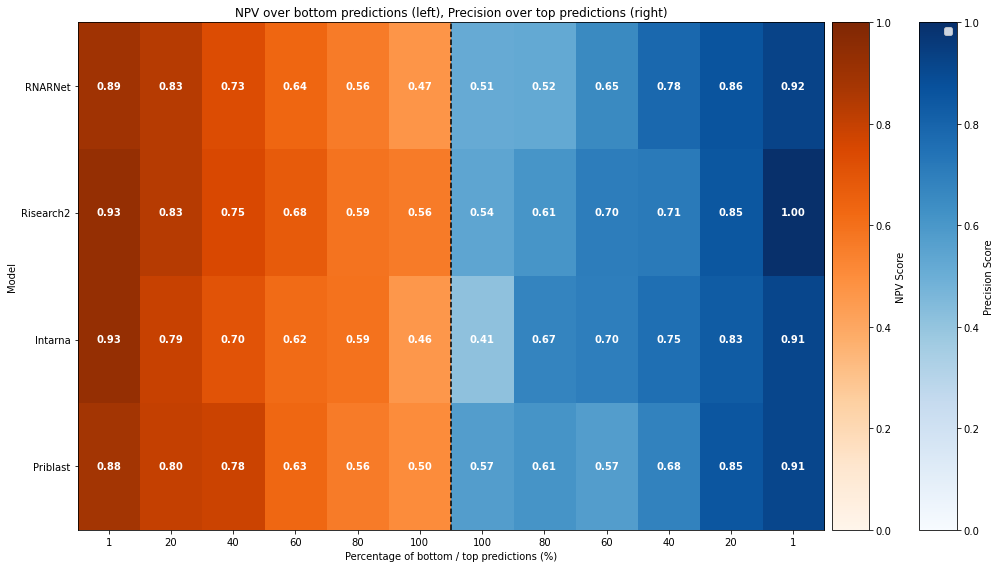

In [11]:
n_points = 6


figsize = (14, 8)

# Dati fittizi per la precisione e la NPV dei modelli
num_dati = n_points
num_modelli = 4

# Generiamo dati fittizi per precisione e NPV per ogni modello
precision_data = np.zeros((num_modelli, num_dati))
npv_data = np.zeros((num_modelli, num_dati))

model_names = ['RNARNet', 'Risearch2', 'Intarna', 'Priblast']

# Generazione di curve crescenti per precisione e NPV con rumore
for i in range(num_modelli):
    precision_data[i] = np.linspace(0.5, 0.92, num_dati) + np.random.normal(0, 0.05, num_dati)
    npv_data[i] = np.linspace(0.5, 0.9, num_dati) + np.random.normal(0, 0.03, num_dati)
    # npv deve andare da 1 a 100 e non da 100 a 1
    npv_data[i] = npv_data[i][::-1]

npv_precision(precision_data, npv_data, model_names, figsize)

In [13]:
dfs = []

for dataset in ['paris']: #datasets
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)

    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)    
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                 SPECIE_PARIS,
                                 args_datasets[how]['PARIS_HQ'],
                                 args_datasets[how]['PARIS_HQ_THRESHOLD'],
                                 True
                                )   
    
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,
                            )
    
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    enhn500 = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)

In [29]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))

In [33]:
test500.gene1

0             ENSG00000132463_625_6595
1             ENSG00000101558_427_6397
2            ENSG00000092445_1844_7814
3               ENSG00000165985_0_2376
4             ENSMUSG00000032011_0_347
                     ...              
28805      ENSMUSG00000075703_688_6658
28806           ENSG00000126067_0_4426
28807        ENSMUSG00000004637_0_2383
28808           ENSG00000164967_0_1092
28809    ENSMUSG00000026915_4357_10326
Name: gene1, Length: 28810, dtype: object

In [32]:
ephnen[ephnen.distance_from_site>0]

Unnamed: 0                          couples  gene1_pc  gene2_pc  \
0               0  ENSG00000100433_ENSG00000175548      True      True   
2               2  ENSG00000003756_ENSG00000175548      True      True   
4               5  ENSG00000003756_ENSG00000185442      True      True   
5               6  ENSG00000139133_ENSG00000175548      True      True   
7               9  ENSG00000139133_ENSG00000188171      True      True   
...           ...                              ...       ...       ...   
14168       28814  ENSG00000182718_ENSG00000235173      True      True   
14169       28817  ENSG00000162227_ENSG00000164576      True      True   
14170       28819  ENSG00000147257_ENSG00000198888      True      True   
14171       28820  ENSG00000092421_ENSG00000180592      True      True   
14172       28822  ENSG00000105662_ENSG00000122591      True      True   

       original_length1  original_length2  id_sample  probability  \
0                7501.0           10050.0     155483     0.018585   
2                3177.0           10050.0     154215     0.358389   
4                3177.0            2604.0     132641     0.533226   
5                2913.0           10050.0     157347     0.352601   
7                2913.0            6063.0     140651     0.036940   
...                 ...               ...        ...          ...   
14168            1676.0            2534.0     144101     0.528188   
14169            2023.0            6185.0     142387     0.702770   
14170            2336.0             956.0     141485     0.542472   
14171            6878.0            6601.0     135105     0.333239   
14172            6929.0           13178.0     155755     0.265967   

       ground_truth                         g1  ... original_area E_norm_conf  \
0                 0  ENSG00000100433_1465_7434  ...    75385050.0    0.797199   
2                 0     ENSG00000003756_0_3177  ...    31928850.0    0.229321   
4                 0     ENSG00000003756_0_3177  ...     8272908.0    0.433889   
5                 0     ENSG00000139133_0_2913  ...    29275650.0    0.163319   
7                 0     ENSG00000139133_0_2913  ...    17661519.0    0.135948   
...             ...                        ...  ...           ...         ...   
14168             0     ENSG00000182718_0_1676  ...     4246984.0    0.343946   
14169             0     ENSG00000162227_0_2023  ...    12512255.0    0.883767   
14170             0     ENSG00000147257_0_2336  ...     2233216.0    0.596408   
14171             0   ENSG00000092421_555_6524  ...    45401678.0    0.156829   
14172             0   ENSG00000105662_941_6910  ...    91310362.0    0.706092   

       ensemble_score  priblast  RNAplex  rnacofold   assa risearch2  \
0            0.407892 -12.32290    -22.1     -243.3   0.00    -28.07   
2            0.293855  -8.91205    -28.1     -269.5   0.00    -28.65   
4            0.483558   0.00000    -30.8     -310.2   0.00    -36.05   
5            0.257960  -8.29700    -25.7     -211.0   0.00    -27.55   
7            0.086444   0.00000    -21.7     -314.6 -15.85    -35.68   
...               ...       ...      ...        ...    ...       ...   
14168        0.436067   0.00000    -35.5     -369.7   0.00    -39.09   
14169        0.793269 -15.27030    -56.9     -537.7 -22.20    -67.72   
14170        0.569440 -10.23210    -18.1     -244.6   0.00    -31.79   
14171        0.245034   0.00000    -31.2     -338.1   0.00    -37.36   
14172        0.486030 -11.00470    -19.3     -316.4   0.00    -30.65   

      RNAhybrid  RNAup  
0        -170.2  -7.80  
2        -149.2  -7.99  
4        -206.0 -10.36  
5        -142.3  -5.88  
7        -148.7  -6.34  
...         ...    ...  
14168    -257.7  -7.66  
14169    -433.2 -15.19  
14170    -151.3 -10.20  
14171    -232.4  -9.76  
14172    -142.1  -8.47  

[9275 rows x 60 columns]

In [26]:
ephnen.policy

0        hardneg
1        easypos
2        hardneg
3        easypos
4        easyneg
          ...   
14168    easyneg
14169    easyneg
14170    easyneg
14171    easyneg
14172    easyneg
Name: policy, Length: 14173, dtype: object

<AxesSubplot:>

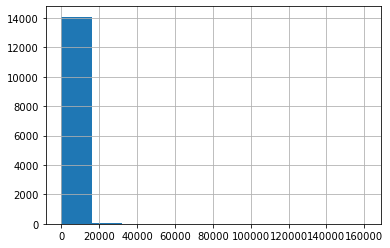

In [21]:
ephnen.distance_from_site.hist()

<AxesSubplot:>

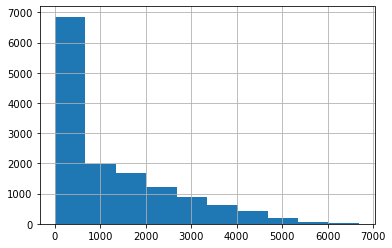

In [22]:
enhn500.distance_from_site.hist()

# Repeats enrichment

In Paris, le SR sono > delle non SR solo se paris_hq = False, quindi solo se non consideriamo nei positivi.

In [14]:
#analysis args
feature_to_search = 'Simple_repeat'


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [15]:
#kde plot args
figsize_kde = (7, 4)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 1
n_values = 12
size_multiplier = 0
n_run_undersampling = 15
list_of_metrics = ['recall', 'precision_recall_curve']
plot_function = plot_results_based_on_topbottom_for_all_models
tasks_treshold = ['simple_repeat_EPSN', 'no_simple_repeat_EPSN']

##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
Simple_repeat are the 2.2641509433962264  % of the total couples
No Simple_repeat are the 74.40251572327044  % of the total couples


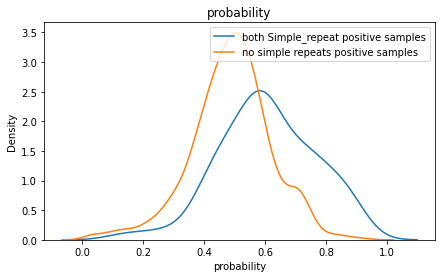

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3841918903
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 283040.0
P-value: 0.0




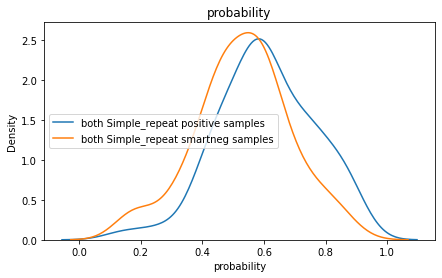

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2174585445
P-value: 0.0098862245

Test di Mann-Whitney U:
Statistiche U: 7397.0
P-value: 0.0005872496




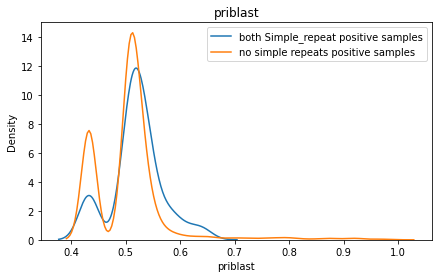

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2071317623
P-value: 0.0001350206

Test di Mann-Whitney U:
Statistiche U: 246316.5
P-value: 2.3098e-06




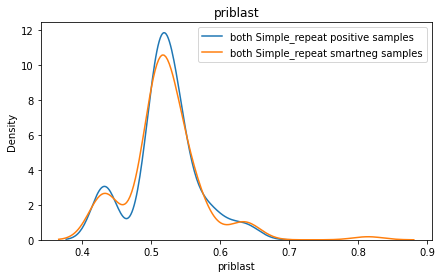

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0860039522
P-value: 0.7764501979

Test di Mann-Whitney U:
Statistiche U: 6130.0
P-value: 0.4985857858




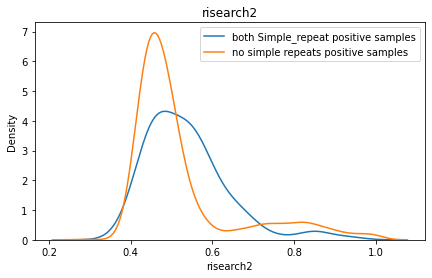

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2582670809
P-value: 6.333e-07

Test di Mann-Whitney U:
Statistiche U: 238009.0
P-value: 9.04922e-05




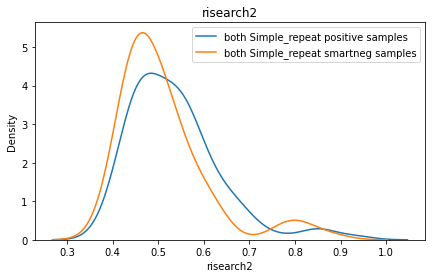

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2114442822
P-value: 0.0131839316

Test di Mann-Whitney U:
Statistiche U: 6991.0
P-value: 0.0106961984




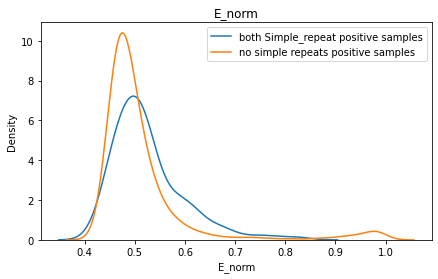

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2274469129
P-value: 1.85876e-05

Test di Mann-Whitney U:
Statistiche U: 239781.5
P-value: 4.52617e-05




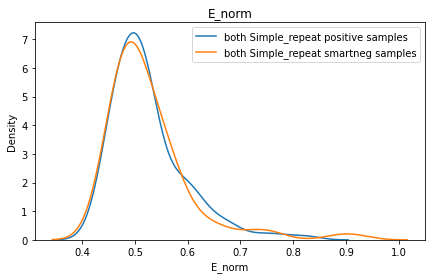

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0763811324
P-value: 0.8782198286

Test di Mann-Whitney U:
Statistiche U: 5942.0
P-value: 0.7902946707





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


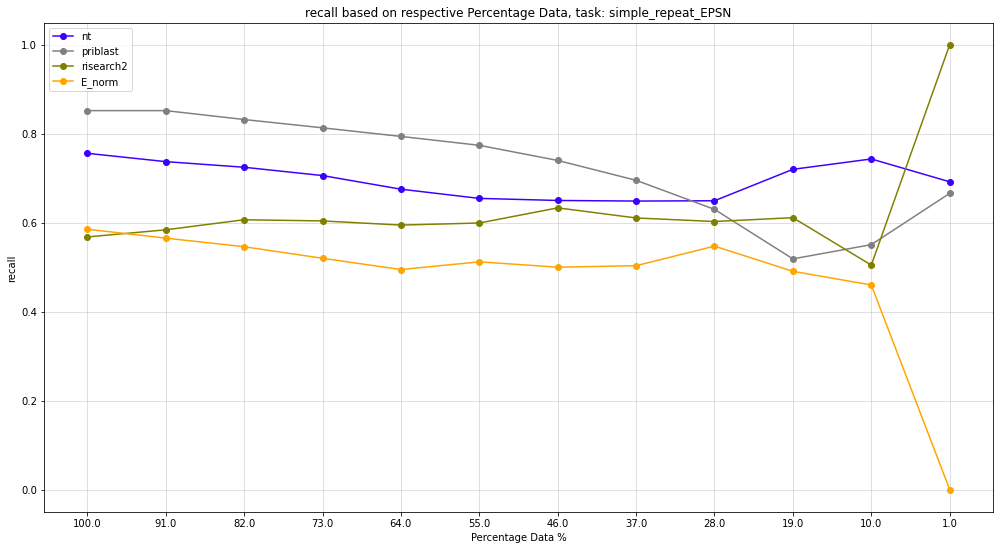

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


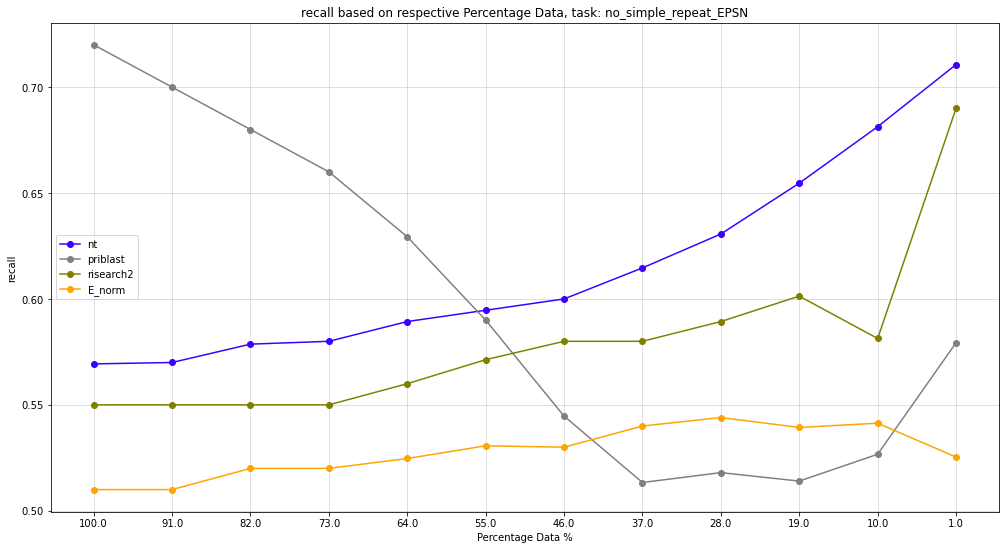

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


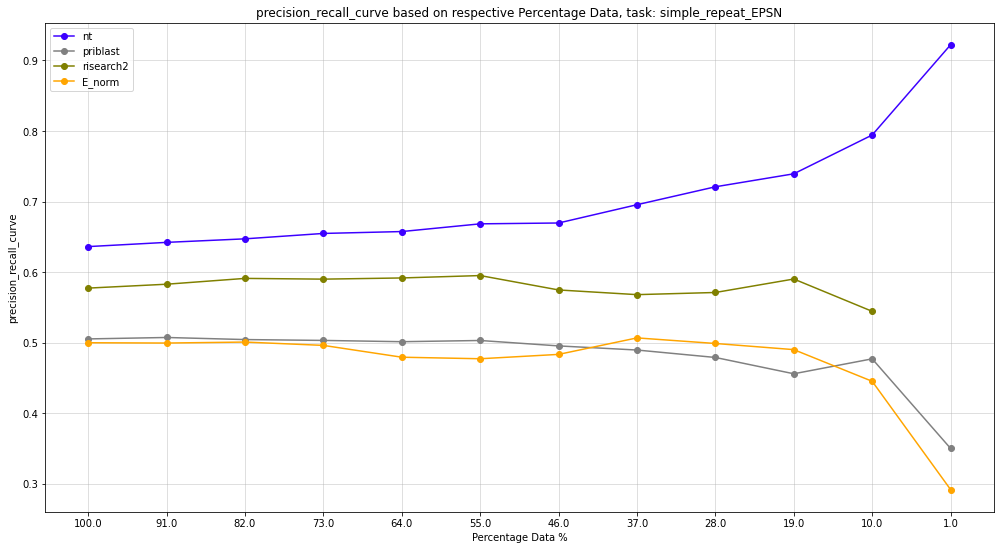

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


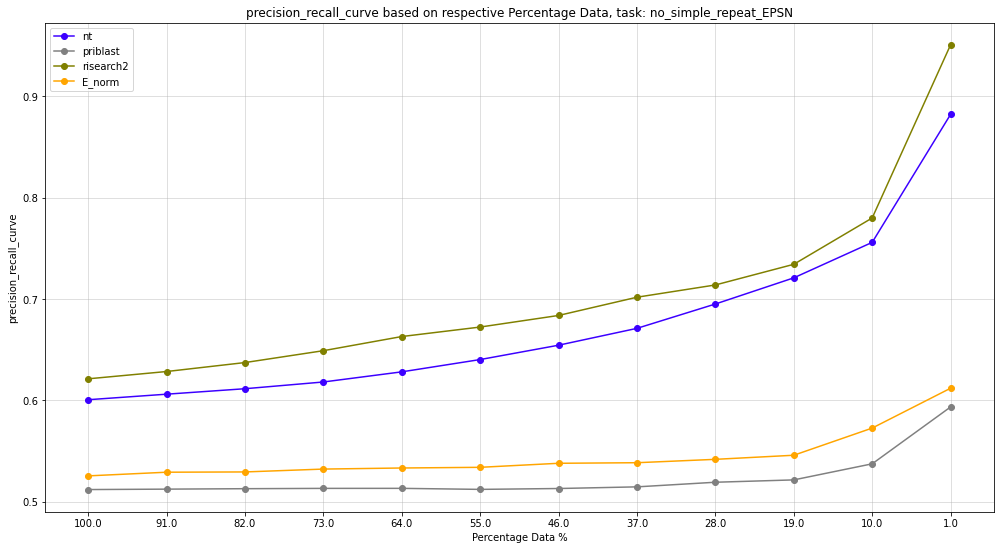




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


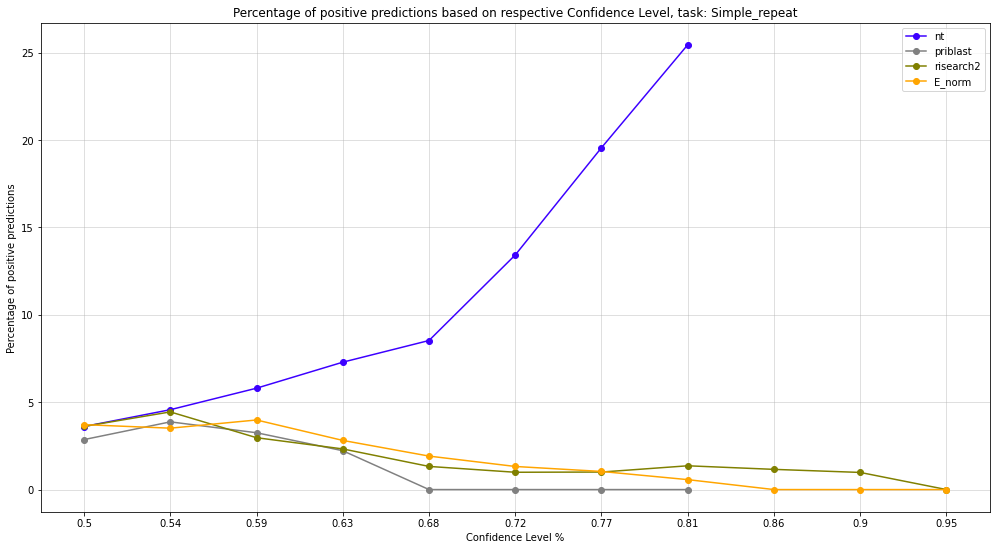

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


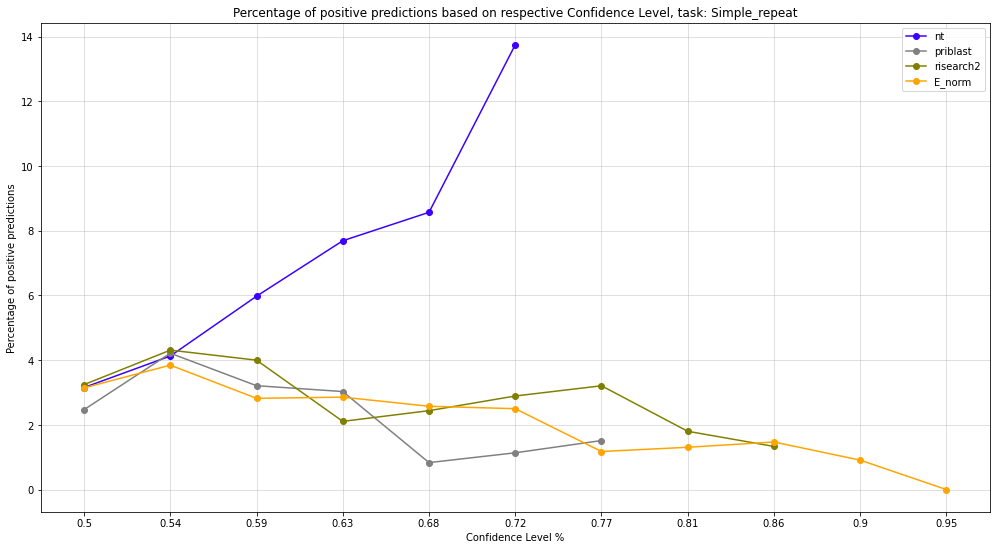




##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
# excluded couples:  234
Simple_repeat are the 1.6124269092197743  % of the total couples
No Simple_repeat are the 77.43192959659795  % of the total couples


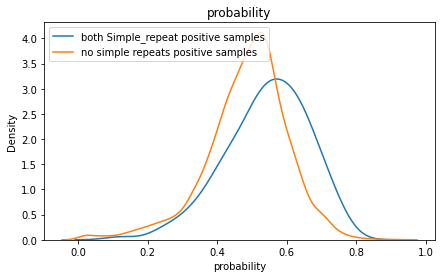

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2454868304
P-value: 1.58e-08

Test di Mann-Whitney U:
Statistiche U: 692804.0
P-value: 1.9e-09




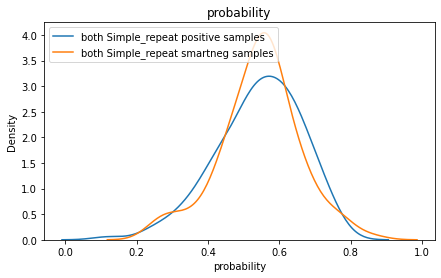

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1122471296
P-value: 0.335067021

Test di Mann-Whitney U:
Statistiche U: 9325.0
P-value: 0.7811950087




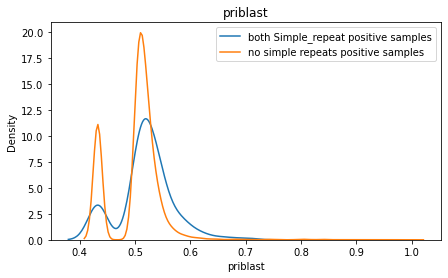

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2342954646
P-value: 8.42e-08

Test di Mann-Whitney U:
Statistiche U: 672962.5
P-value: 1.525e-07




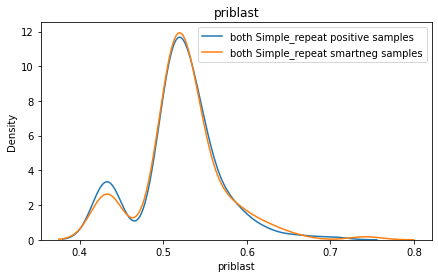

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0630399125
P-value: 0.9319092704

Test di Mann-Whitney U:
Statistiche U: 8991.5
P-value: 0.8125985328




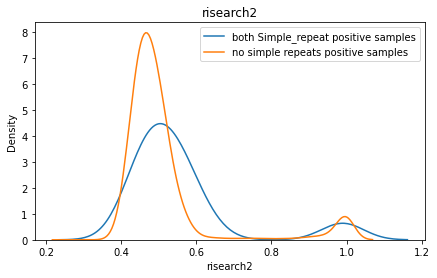

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2970886357
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 710088.5
P-value: 0.0




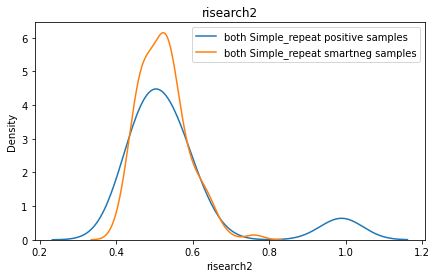

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0903225806
P-value: 0.6023968067

Test di Mann-Whitney U:
Statistiche U: 9243.5
P-value: 0.8794650161




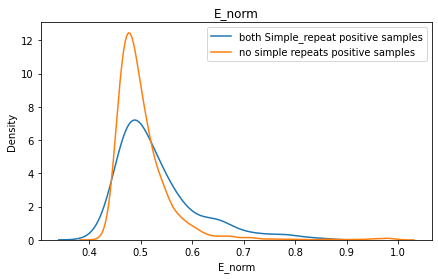

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.202907665
P-value: 6.008e-06

Test di Mann-Whitney U:
Statistiche U: 658013.0
P-value: 3.6564e-06




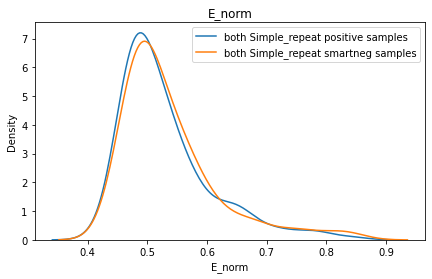

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1272826681
P-value: 0.2045506943

Test di Mann-Whitney U:
Statistiche U: 8579.5
P-value: 0.3819580091





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


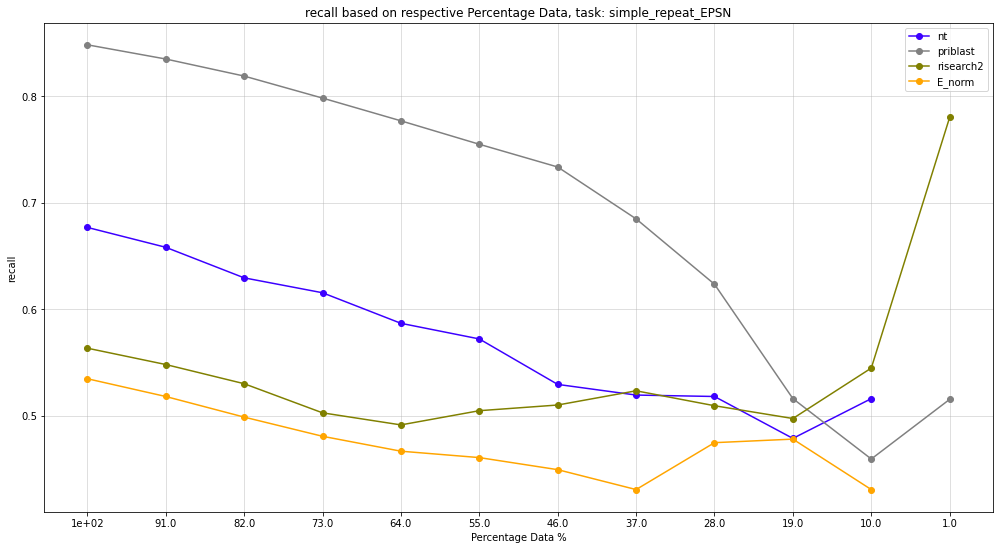

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


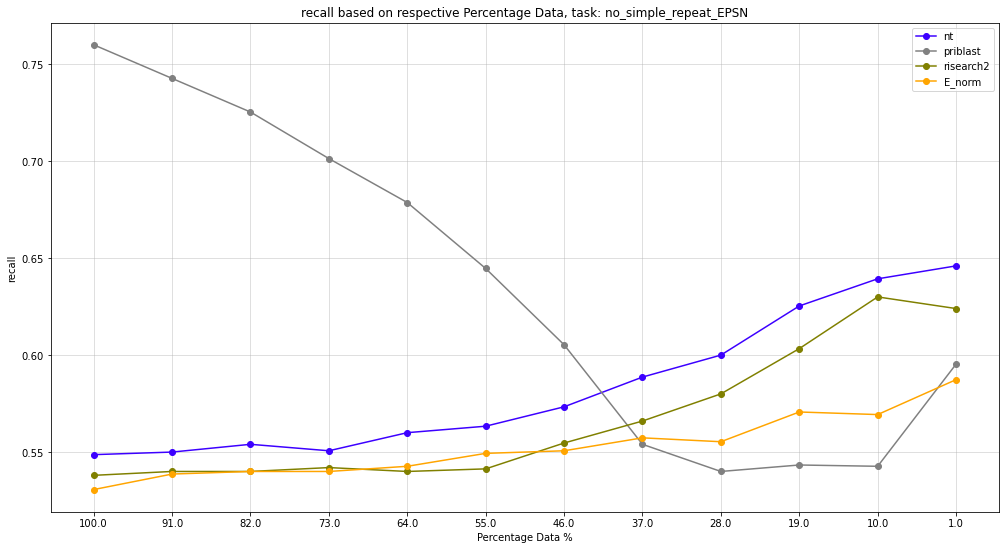

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


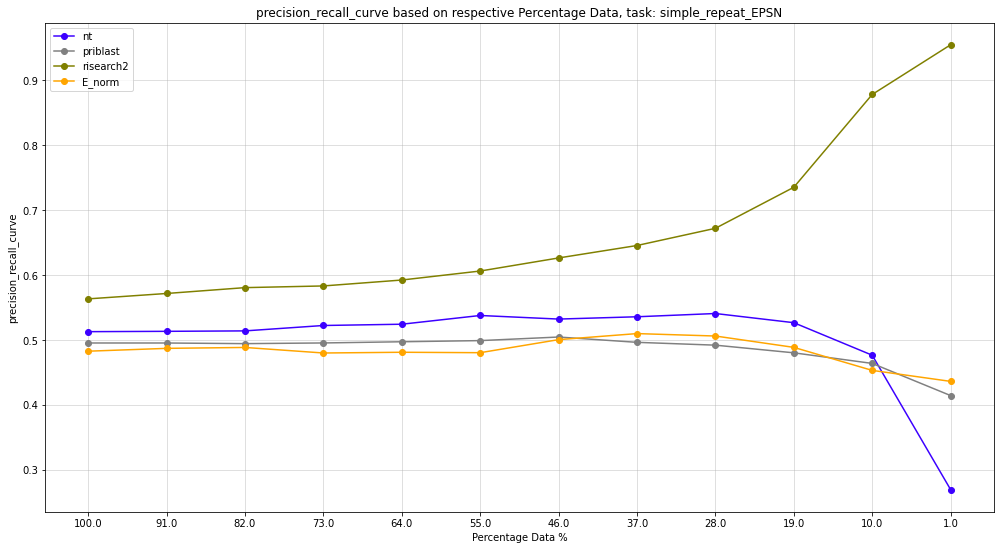

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


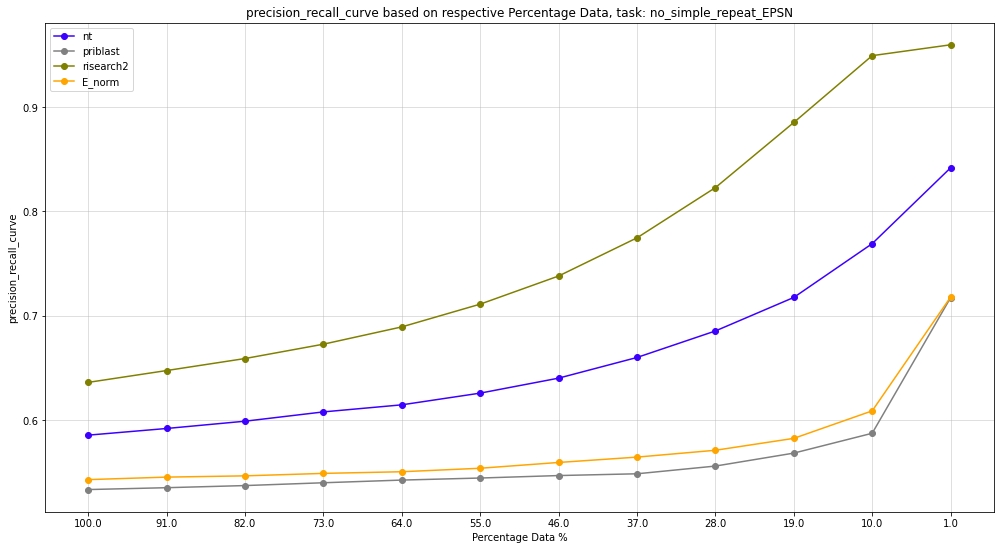




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


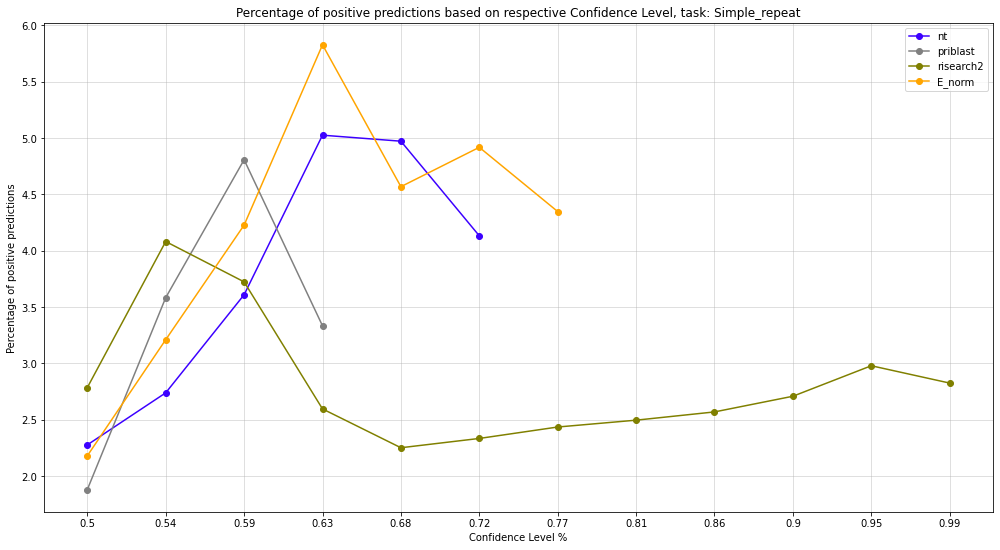

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


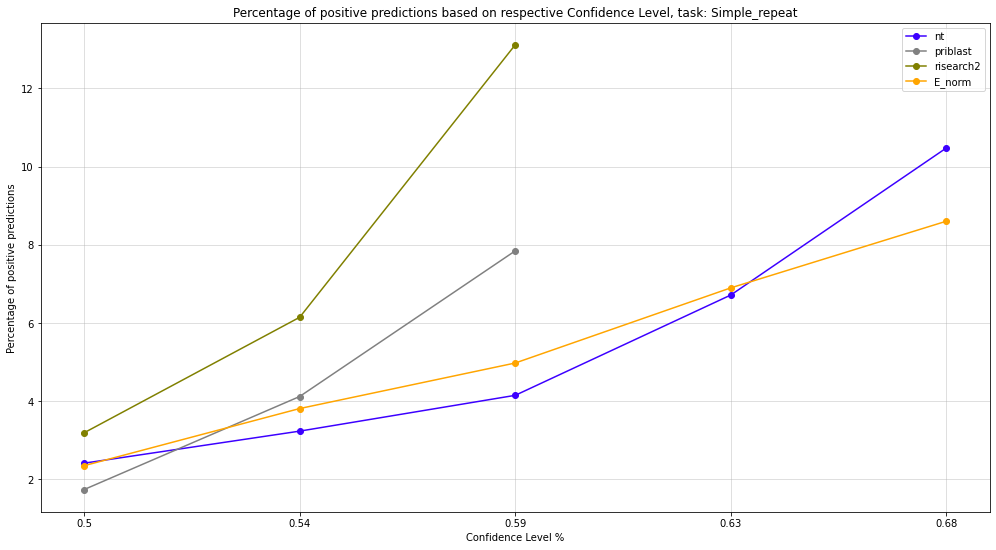




##############   ##############   ##############   ##############   ##############
---------- DATASET: splash ----------
# excluded couples:  12
Simple_repeat are the 7.026143790849673  % of the total couples
No Simple_repeat are the 62.908496732026144  % of the total couples


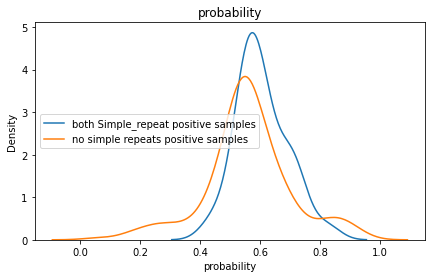

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3088657574
P-value: 0.0140687307

Test di Mann-Whitney U:
Statistiche U: 3533.0
P-value: 0.0217741057




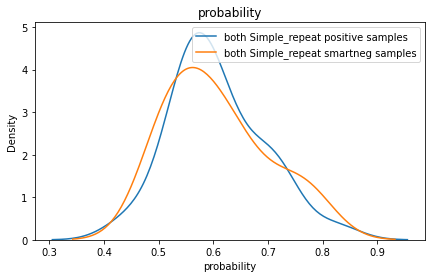

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1595238095
P-value: 0.9171300806

Test di Mann-Whitney U:
Statistiche U: 214.0
P-value: 0.9289322965




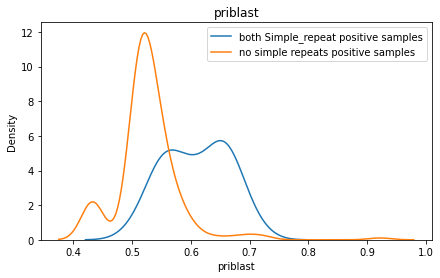

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.6762383345
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 4922.0
P-value: 1e-10




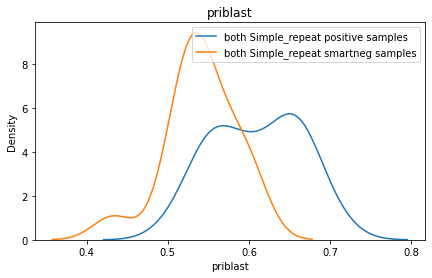

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5238095238
P-value: 0.0050572831

Test di Mann-Whitney U:
Statistiche U: 348.0
P-value: 0.0004586276




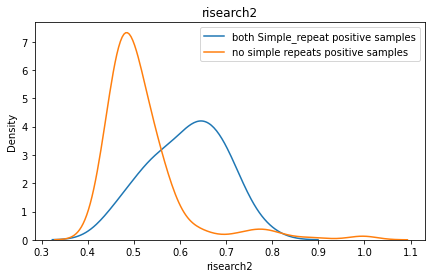

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5857860732
P-value: 1.89e-08

Test di Mann-Whitney U:
Statistiche U: 4578.5
P-value: 3.64e-08




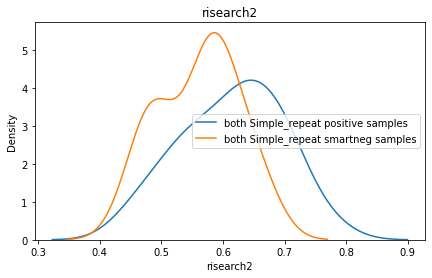

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4071428571
P-value: 0.0567140893

Test di Mann-Whitney U:
Statistiche U: 292.0
P-value: 0.0378188861




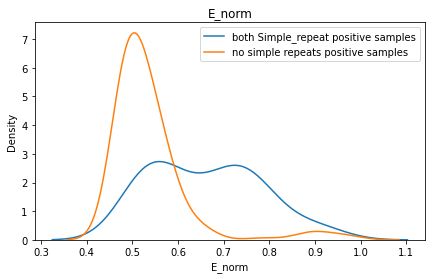

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5423546303
P-value: 2.958e-07

Test di Mann-Whitney U:
Statistiche U: 4665.0
P-value: 7.8e-09




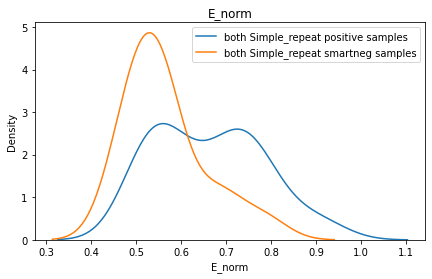

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4428571429
P-value: 0.0300741342

Test di Mann-Whitney U:
Statistiche U: 315.0
P-value: 0.0077468919





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


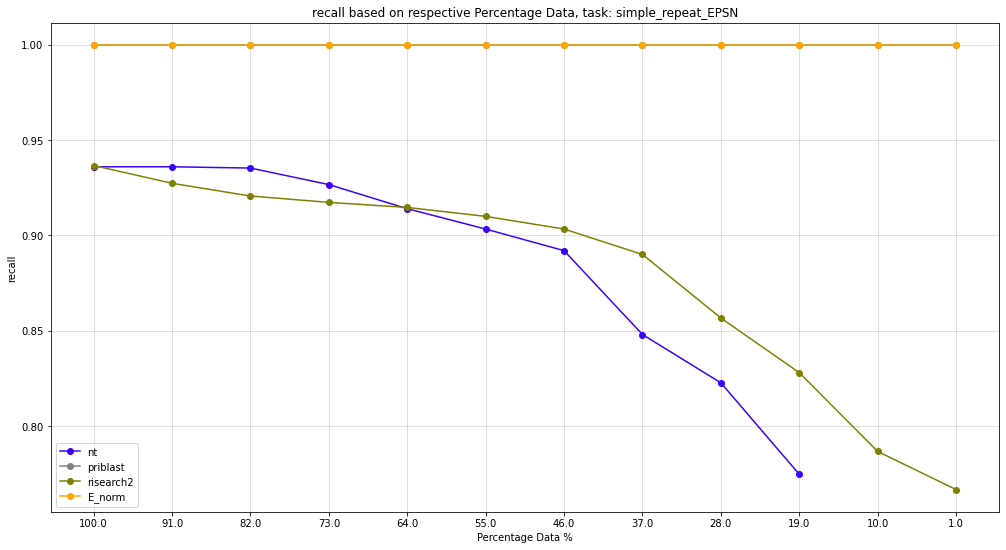

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


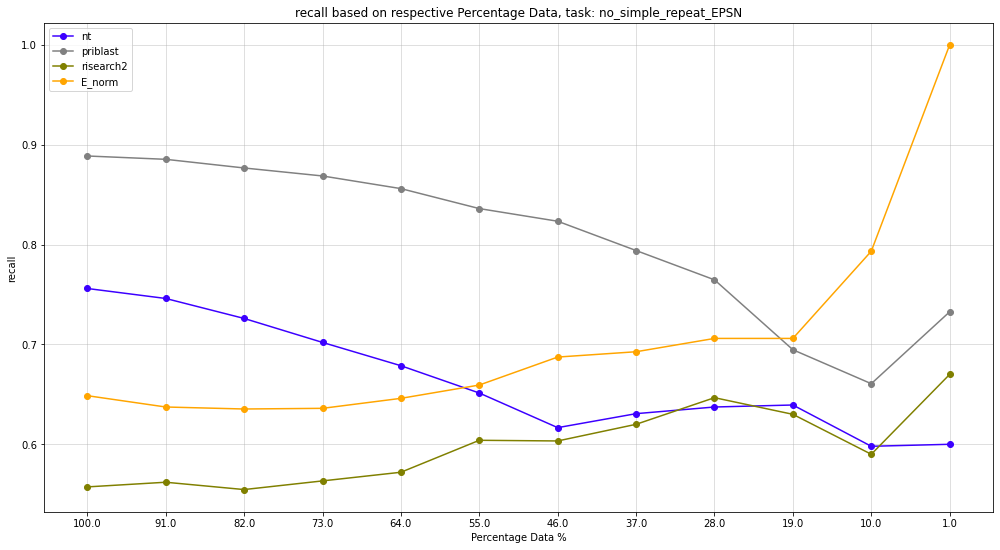

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


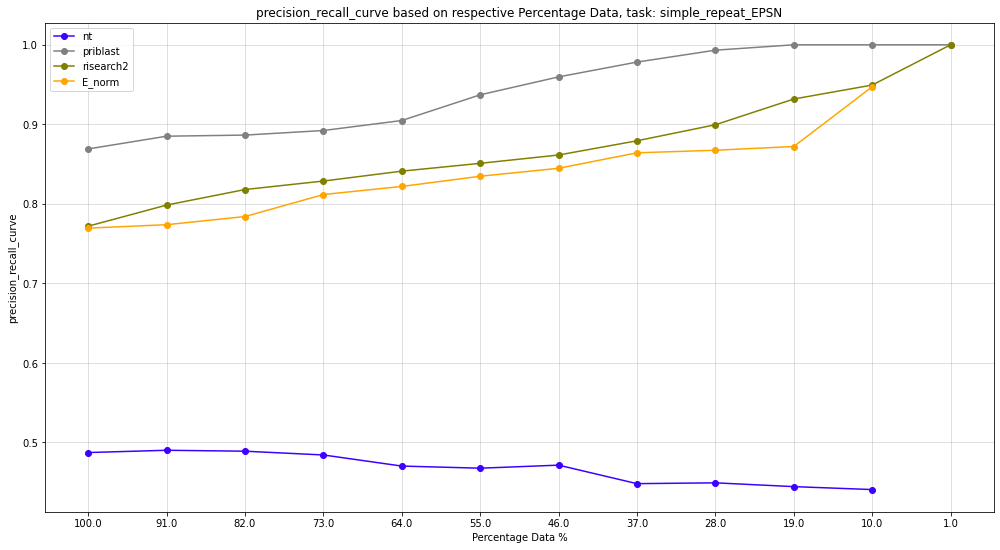

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


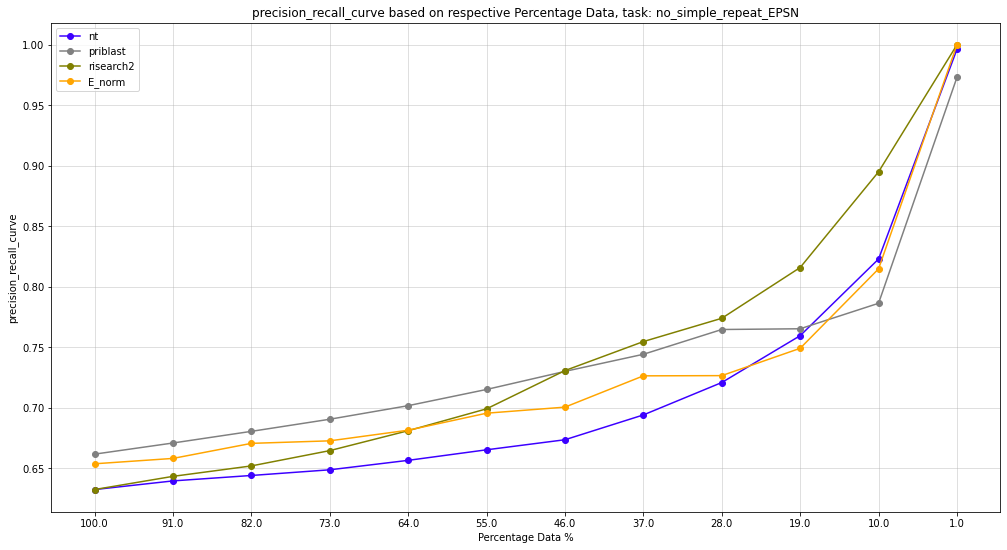




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


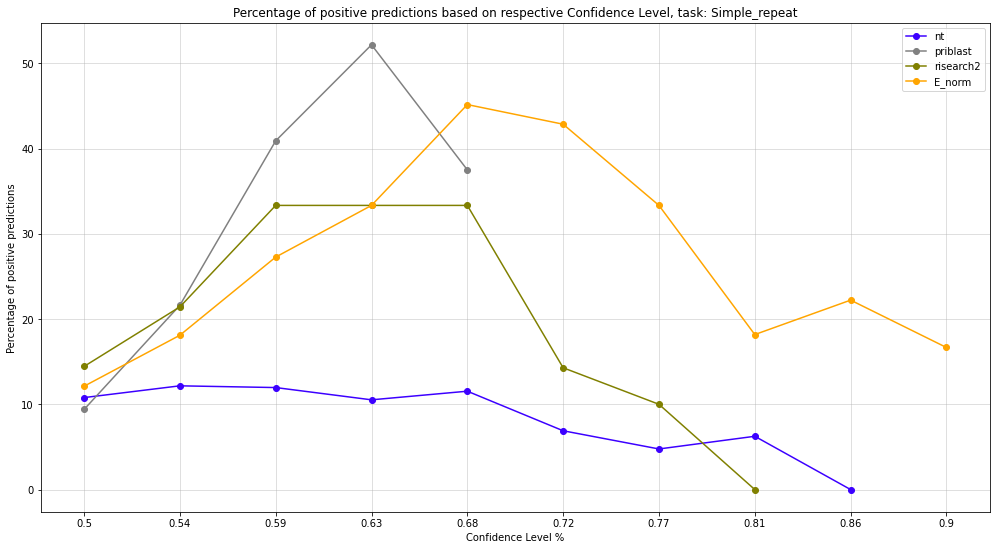

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


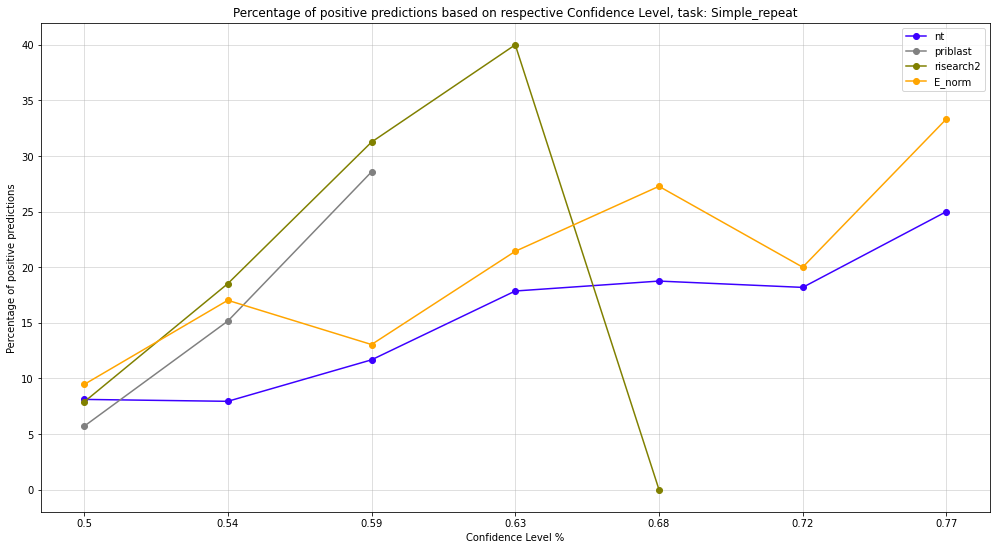




##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
# excluded couples:  4
Simple_repeat are the 1.0535557506584723  % of the total couples
No Simple_repeat are the 80.24582967515364  % of the total couples


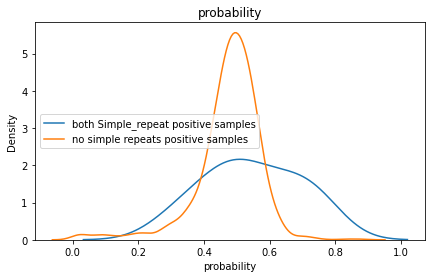

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3899604352
P-value: 0.039070759

Test di Mann-Whitney U:
Statistiche U: 7653.0
P-value: 0.1189382677




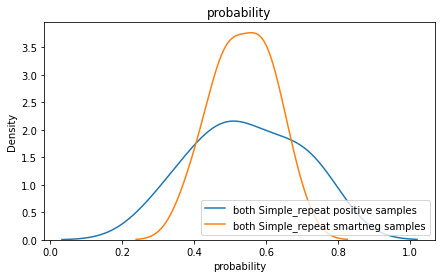

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.25
P-value: 0.8689816712

Test di Mann-Whitney U:
Statistiche U: 77.0
P-value: 0.795012172




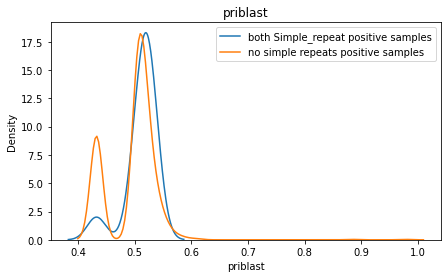

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3639960435
P-value: 0.0648379622

Test di Mann-Whitney U:
Statistiche U: 7879.0
P-value: 0.0725493928




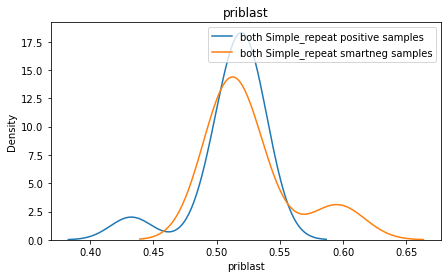

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1666666667
P-value: 0.9984852945

Test di Mann-Whitney U:
Statistiche U: 74.0
P-value: 0.9309874466




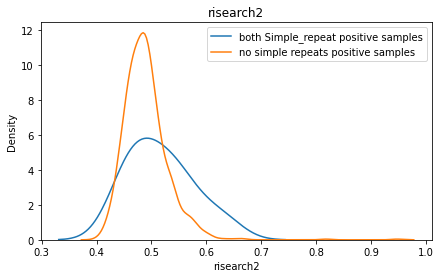

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3217111771
P-value: 0.1363779269

Test di Mann-Whitney U:
Statistiche U: 7663.0
P-value: 0.1166304163




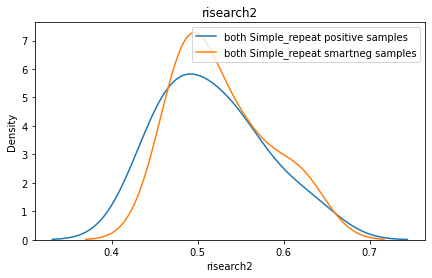

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.25
P-value: 0.8689816712

Test di Mann-Whitney U:
Statistiche U: 63.0
P-value: 0.6236048844




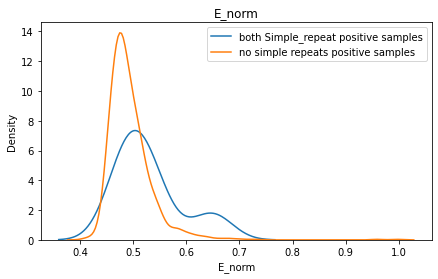

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3773491592
P-value: 0.0502526691

Test di Mann-Whitney U:
Statistiche U: 8634.0
P-value: 0.0116227314




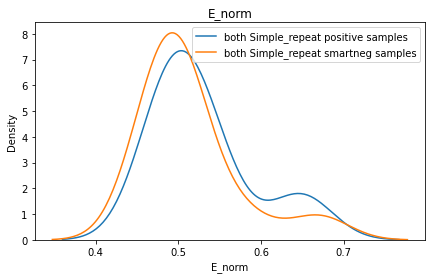

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3333333333
P-value: 0.5360977695

Test di Mann-Whitney U:
Statistiche U: 87.0
P-value: 0.4025038238





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


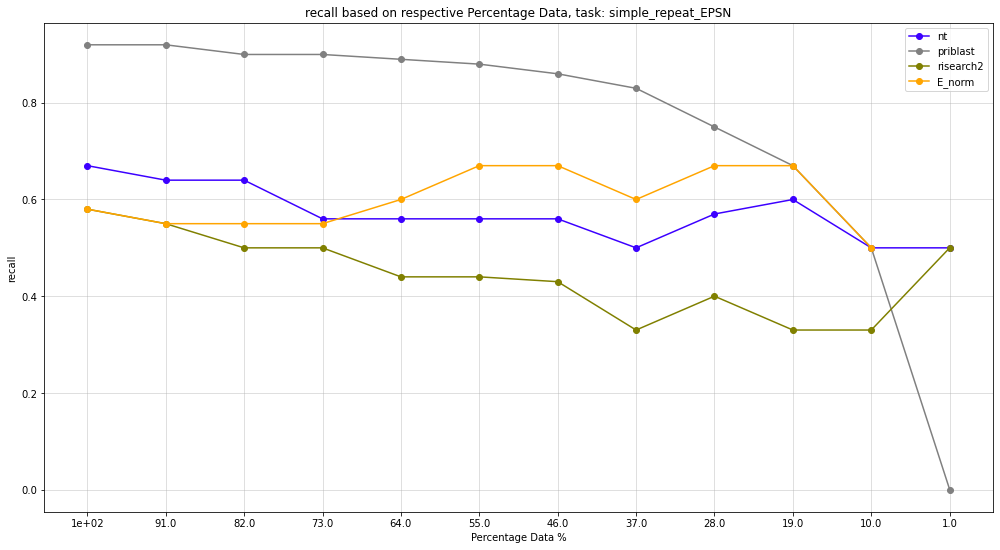

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


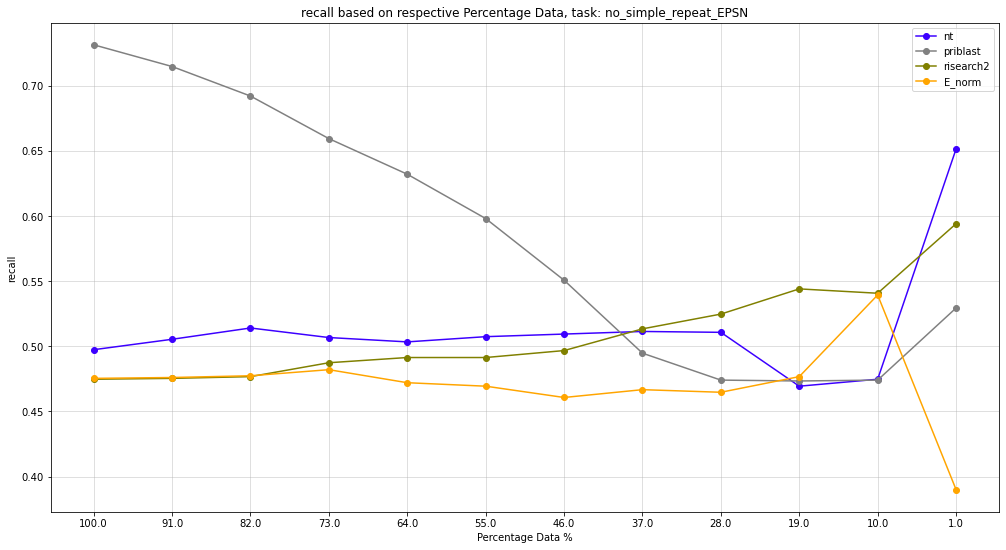

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning

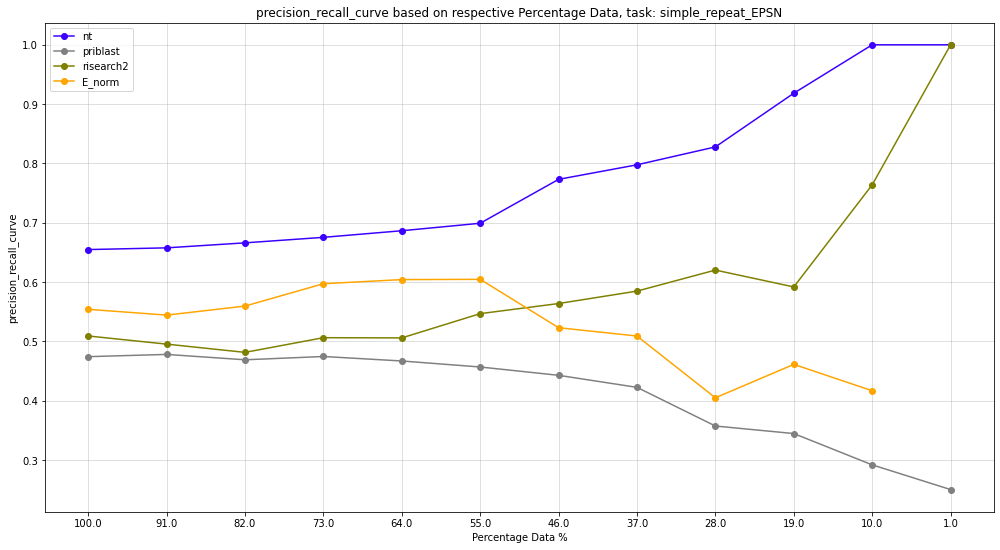

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


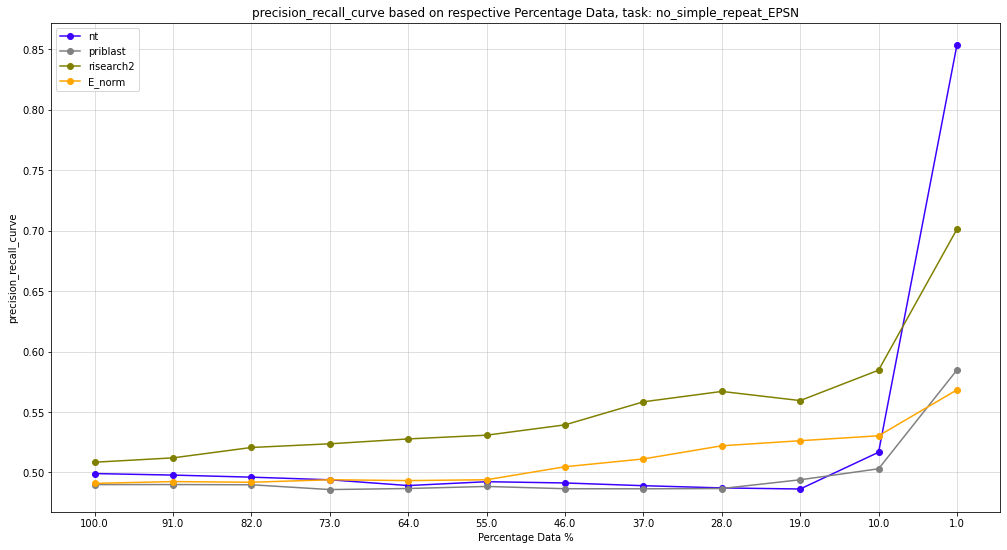




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


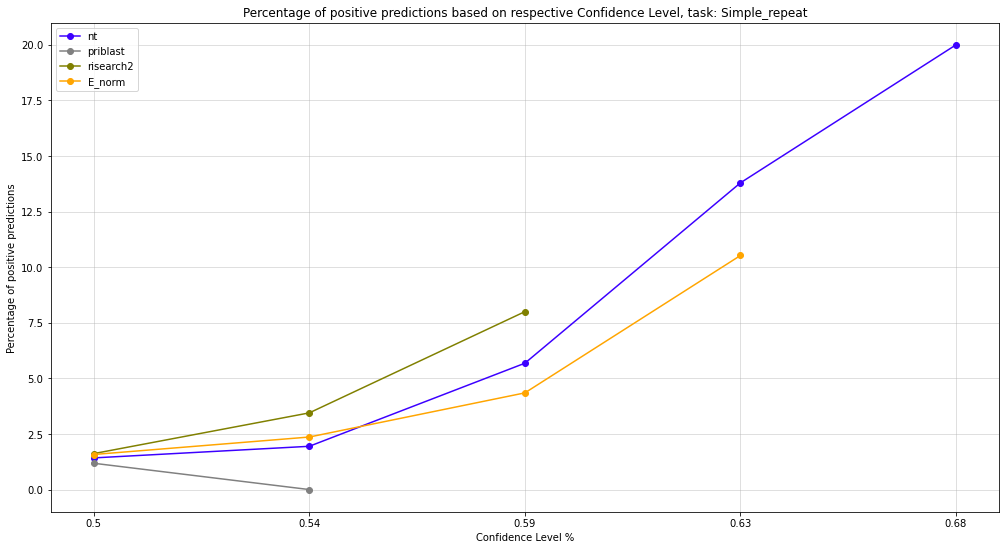

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


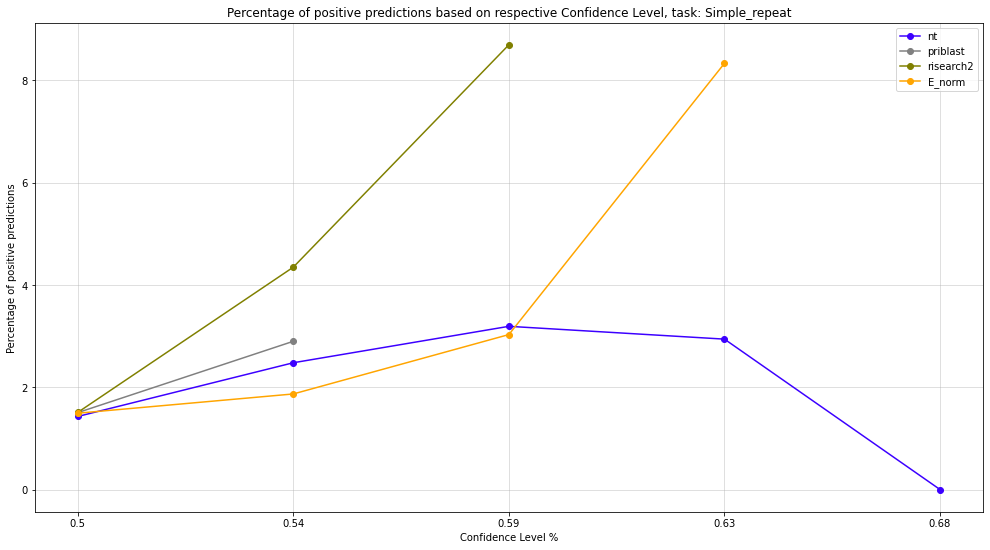

In [16]:
for dataset in datasets:
    print(f'##############   ##############   ##############   ##############   ##############')
    how = dataset if dataset != 'paris' else 'test'
    print(f'---------- DATASET: {dataset} ----------')


    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False)
    #res = obtain_subset_from_task(res, 'interactors')

    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
        

    test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))

    sr1 = set(test500[test500[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)].couples)
    sr2 = set(test500[test500[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)].couples)

    none1 = set(test500[test500[f'{suffix}feature1'].apply(lambda x: 'None' in x)].couples)
    none2 = set(test500[test500[f'{suffix}feature2'].apply(lambda x: 'None' in x)].couples)

    res['simple_repeat1'] = res.id_sample.isin(sr1)
    res['simple_repeat2'] = res.id_sample.isin(sr2)
    res['none1'] = res.id_sample.isin(none1)
    res['none2'] = res.id_sample.isin(none2)


    filtered_policies = ['easypos', 'smartneg']
    sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
    N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
    print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')


    sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
    sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

    no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
    no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)
    
    ##################### ##################### KDE PLOTS ##################### #####################
    
    for column in ['probability'] + energy_columns:

        if both_sr_condition:
            label_x = f'both {feature_to_search} positive samples'
        else:
            label_x = f'at least {feature_to_search} positive samples'

        x, y = sr_ep[column], no_sr_ep[column]

        make_plot_kde_and_test_difference(x, y, label_x, 'no simple repeats positive samples', column, figsize_kde)

        if both_sr_condition:
            label_x = f'both {feature_to_search} positive samples'
            label_y = f'both {feature_to_search} smartneg samples'
        else:
            label_x = f'at least {feature_to_search} positive samples'
            label_y = f'at least {feature_to_search} smartneg samples'

        x, y = sr_ep[column], sr_sn[column]

        make_plot_kde_and_test_difference(x, y, label_x, label_y, column, figsize_kde)
        
    print('\n\n')
    ##################### ##################### TRESHOLD PLOTS ##################### #####################
        
    for metric in list_of_metrics:
    
        for task in tasks_treshold:
            print(f'           -- -- -- {task} -- -- -- ')
            print(f'           -  -  -  {metric}  -  -  - ')

            if task == 'simple_repeat_EPSN':
                assert len(sr.ground_truth.value_counts().index) == 2
                subset_to_plot = sr.reset_index(drop = True)
            elif task == 'no_simple_repeat_EPSN':
                assert len(no_sr.ground_truth.value_counts().index) == 2
                subset_to_plot = no_sr.reset_index(drop = True)

            plt.figure(figsize=figsize_treshold)
            plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
                          list_of_models_to_test = list_of_models_to_test, 
                          n_values = n_values, n_run_undersampling = n_run_undersampling, 
                          metric = metric, task_name = task, 
                          size_multiplier = size_multiplier#, balance_predictions_at_each_step = True
                         )
            plt.show()
            
    print('\n\n')
    ##################### ##################### REPEATS IN POSITIVE PREDICTIONS ##################### #####################
    #Percentage of SR in positive predictions based on model Confidence Levels (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)
    print('EASYPOS Percentage of SR in positive predictions based on model Confidence Levels')
    plt.figure(figsize=figsize_treshold)
    plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
                                                             MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
                                                            )
    print('SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels')
    plt.figure(figsize=figsize_treshold)
    plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
                                                             MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
                                                            ) #these are errors
    
    
    print('\n\n')

### Ricseq AUC increase with higher MIN_N_reads 

In [17]:
dfs = []

aucs_epsn = []
aucs_enhn500 = []
aucs_enhn = []
n_positives_run = []

dataset, how = 'ricseq', 'ricseq'

list_of_n_reads_ricseq = [2,3,4,5,6,7]

for N_READS_RICSEQ in list_of_n_reads_ricseq:
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             N_READS_RICSEQ, 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}_nread{N_READS_RICSEQ}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}_nread{N_READS_RICSEQ}'}, axis = 1))
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 N_READS_RICSEQ, 
                                 SPECIE_PARIS,
                                 args_datasets[how]['PARIS_HQ'],
                                 args_datasets[how]['PARIS_HQ_THRESHOLD'],
                                 True
                                )   
    
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             N_READS_RICSEQ, 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,
                            )
    
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    
    n_positives_run.append(pos.shape[0])
    
    enhn500 = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
    dfs.append(obtain_all_model_auc(enhn500, tools).rename({'auc': f'auc_EPENHN500_{dataset}_nread{N_READS_RICSEQ}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
# excluded couples:  234


TASK:  EPSN


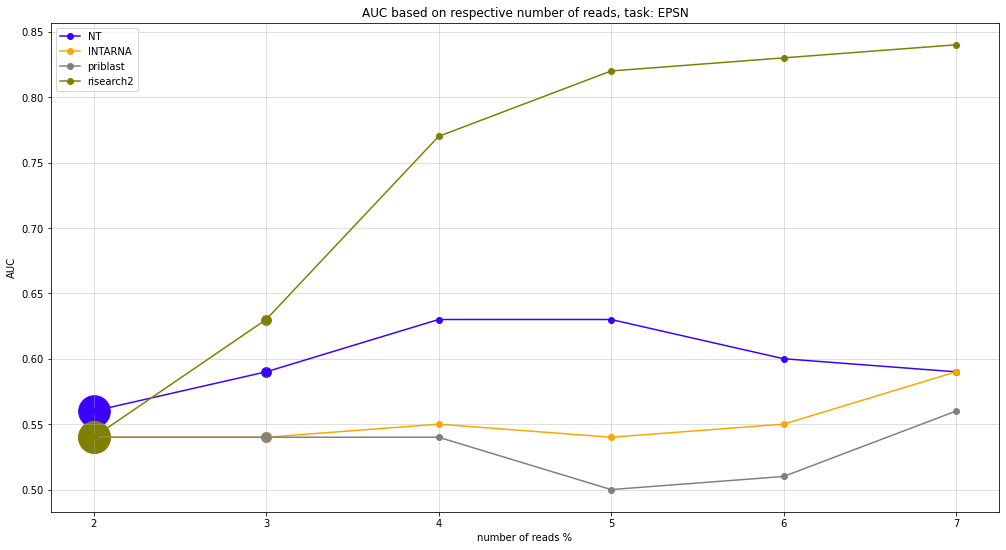




TASK:  EPENHN


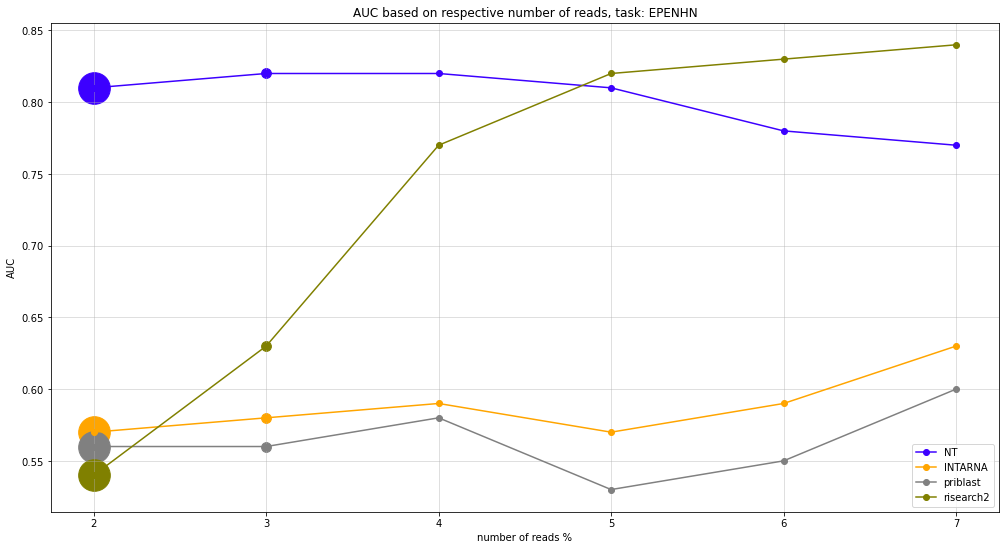




TASK:  EPENHN500


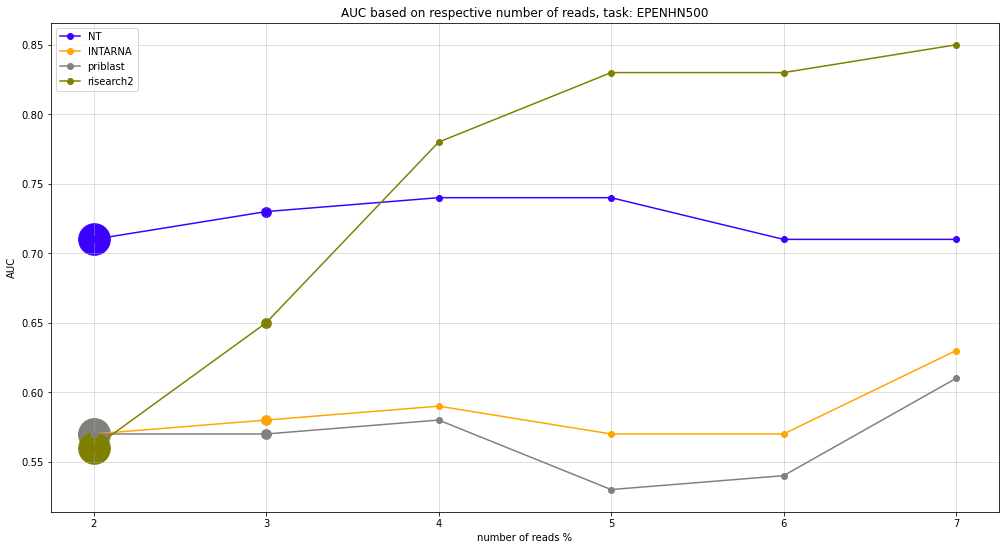

In [18]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'number of reads'
figsize = (17,9)

for task_name in ['EPSN', 'EPENHN', 'EPENHN500']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for N_READS_RICSEQ in list_of_n_reads_ricseq:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_{dataset}_nread{N_READS_RICSEQ}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)
        
    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_n_reads_ricseq, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

### Paris AUC increase with higher interaction length size

###### Il modo in cui carico i dataset tiene conto del fatto che la regione di interazione ha senso filtrarla per lunghezza solo per i positivi e gli smartneg. Quindi per hardneg, easyneg io caricherò tutti i dati non devo filtrare per lunghezza della regione di interazione.

In [19]:
dfs = []

aucs_epsn = []
aucs_enhn500 = []
aucs_enhn = []
n_positives_run = []

dataset, how = 'paris', 'test'


list_of_paris_hq_tresholds = [15, 20, 25, 30, 35, 40, 45]

for HQ_THRESHOLD in tqdm(list_of_paris_hq_tresholds):
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             np.nan, 
                             SPECIE_PARIS,
                             True,
                             HQ_THRESHOLD,
                             False,)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}_len{HQ_THRESHOLD}'}, axis = 1))
    
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             np.nan, 
                             SPECIE_PARIS, 
                             True,
                             HQ_THRESHOLD,
                             False,
                            )
    
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    
    neg = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             np.nan, 
                             SPECIE_PARIS, 
                             False,
                             0,
                             False,
                            )
    
    neg = neg[neg.policy.isin(['hardneg', 'easyneg'])].reset_index(drop = True)
    
    ephnen = pd.concat([pos, neg], axis=0).reset_index(drop = True)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}_len{HQ_THRESHOLD}'}, axis = 1))
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 np.nan, 
                                 SPECIE_PARIS,
                                 False,
                                 0,
                                 True
                                )   
    
    n_positives_run.append(pos.shape[0])
    
    enhn500 = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
    dfs.append(obtain_all_model_auc(enhn500, tools).rename({'auc': f'auc_EPENHN500_{dataset}_len{HQ_THRESHOLD}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

  0%|          | 0/7 [00:00<?, ?it/s]

TASK:  EPSN


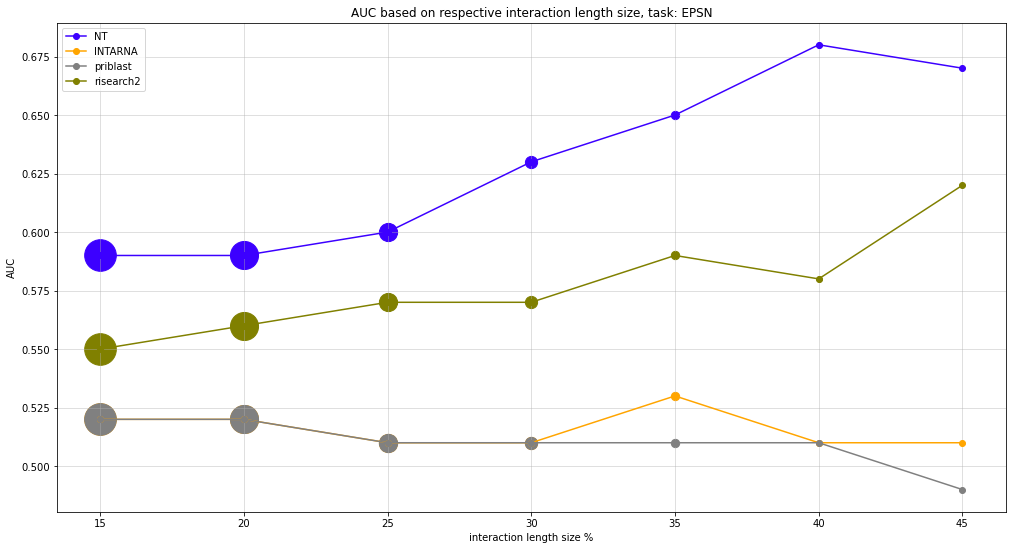




TASK:  EPENHN


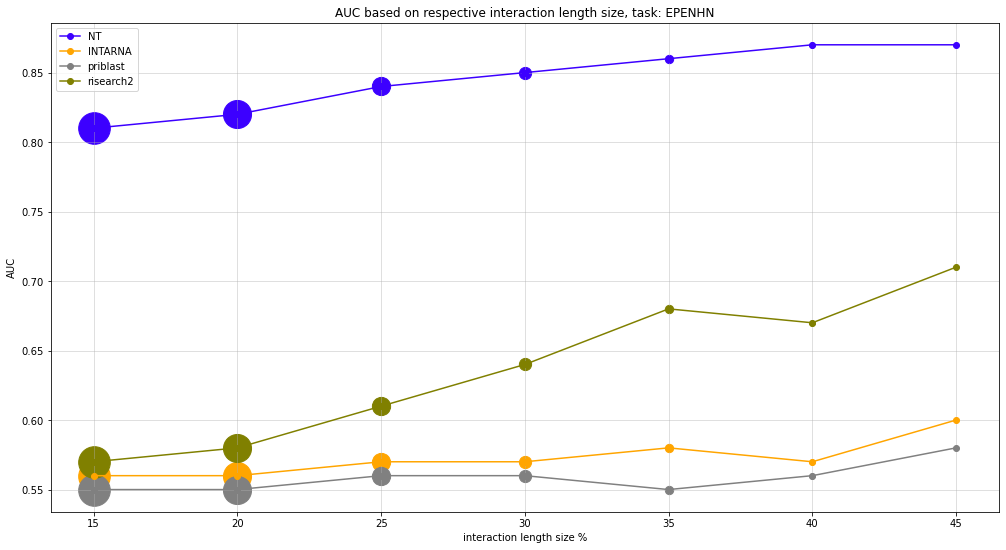




TASK:  EPENHN500


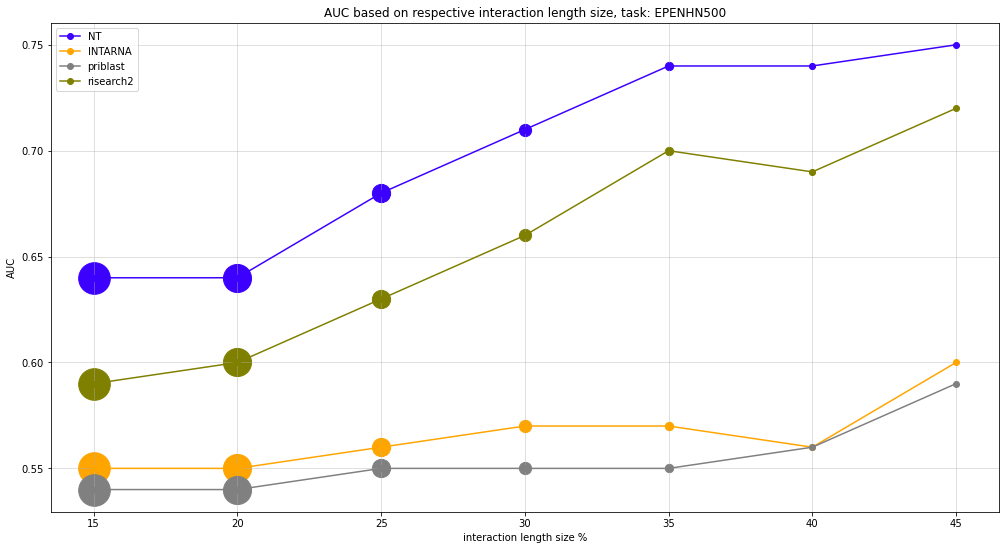

In [20]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'interaction length size'
figsize = (17,9)

for task_name in ['EPSN', 'EPENHN', 'EPENHN500']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for HQ_THRESHOLD in list_of_paris_hq_tresholds:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_{dataset}_len{HQ_THRESHOLD}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)
        
    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_paris_hq_tresholds, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

### Mouse Paris

In [21]:
args_datasets['paris']['SPECIE_PARIS'] = 'mouse'
args_datasets['test']['SPECIE_PARIS'] = 'mouse'

tools = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']

DATASET: paris
easypos_smartneg


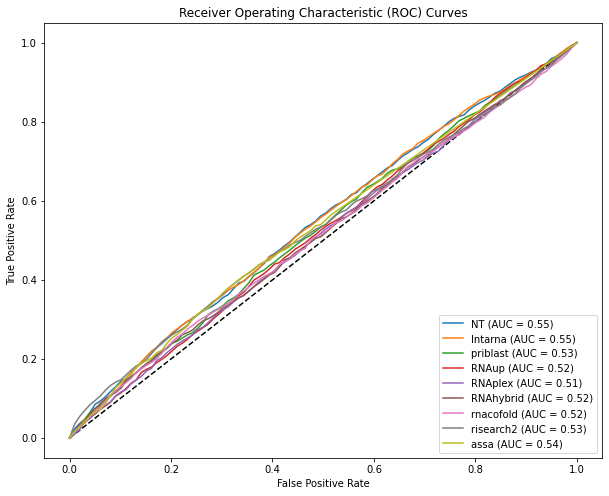

ephnen


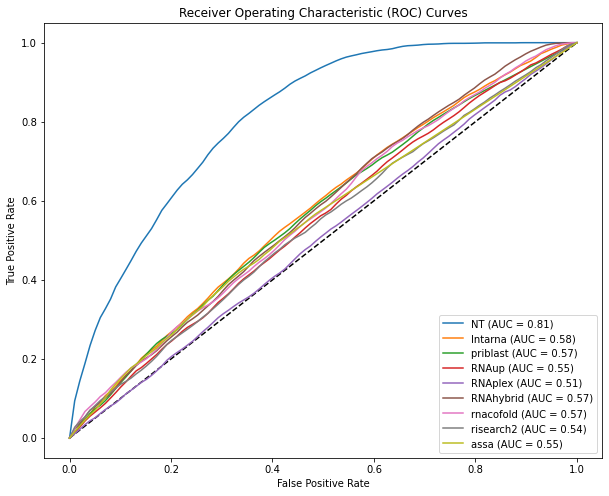

enhn500


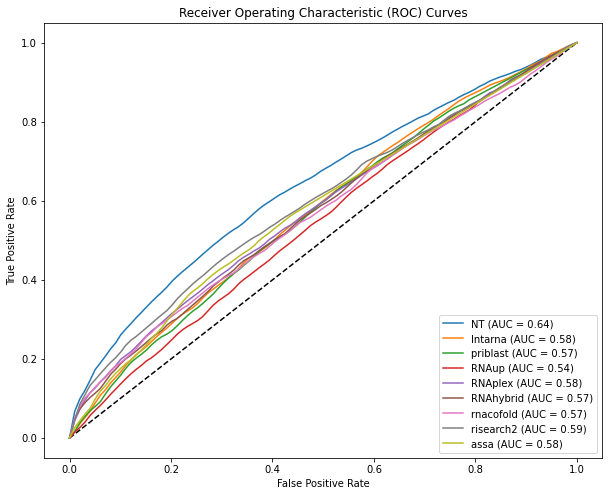

In [22]:
dataset, how = 'paris', 'test'

res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         args_datasets[how]['SPECIE_PARIS'],
                         args_datasets[how]['PARIS_HQ'],
                         args_datasets[how]['PARIS_HQ_THRESHOLD'],
                         False,)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
#easypos_smartneg = balance_df(easypos_smartneg) #oversampling
dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))

ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
#ephnen = balance_df(ephnen) #oversampling
dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))



enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             args_datasets[how]['SPECIE_PARIS'],
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             True
                            )   

pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         args_datasets[how]['SPECIE_PARIS'],
                         args_datasets[how]['PARIS_HQ'],
                         args_datasets[how]['PARIS_HQ_THRESHOLD'],
                         False,
                        )

pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
enhn500 = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
#enhn500 = balance_df(enhn500).reset_index(drop = True) #oversampling


print(f'DATASET: {dataset}')
print('easypos_smartneg')
plot_all_model_auc(easypos_smartneg, tools)
print('ephnen')
plot_all_model_auc(ephnen, tools)
print('enhn500')
plot_all_model_auc(enhn500, tools)
print('\n\n')

##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


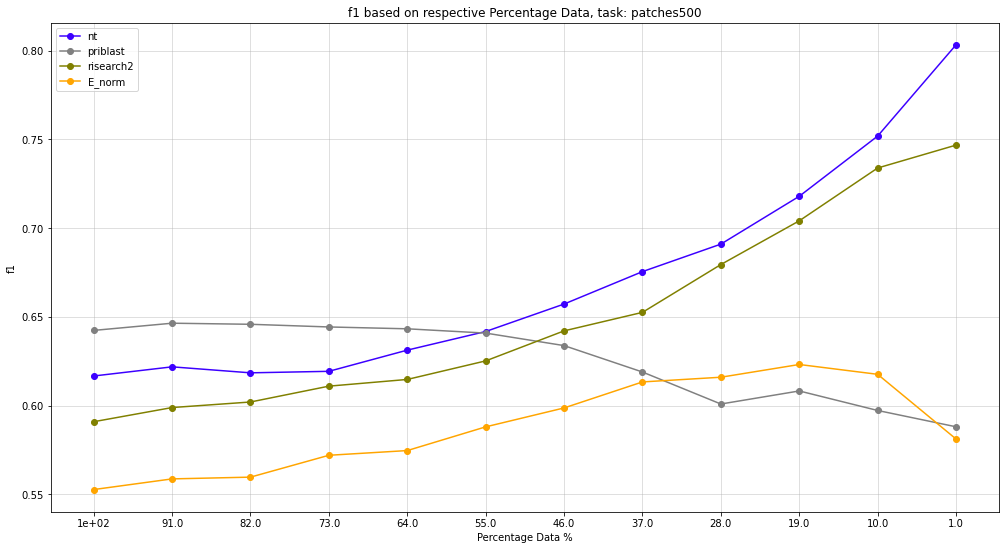

---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


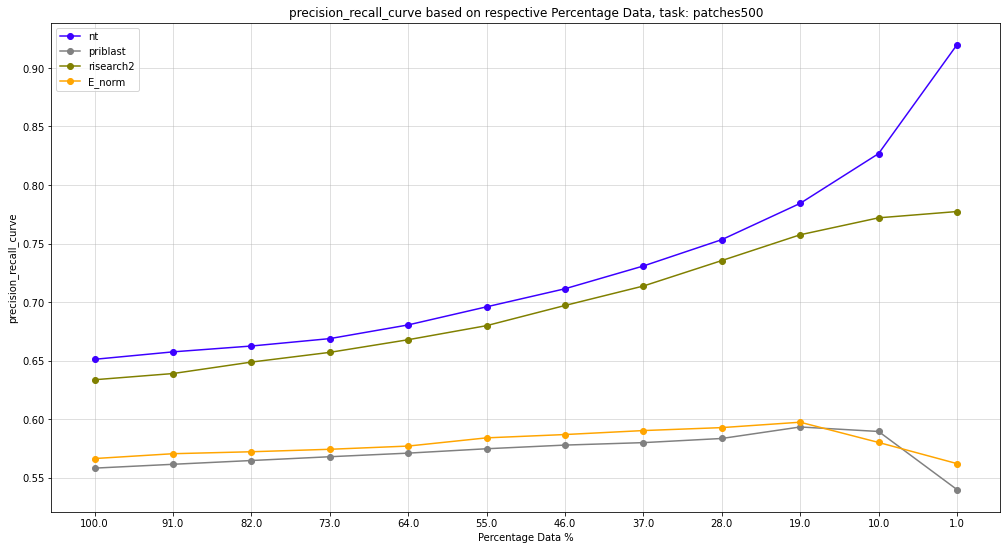

---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


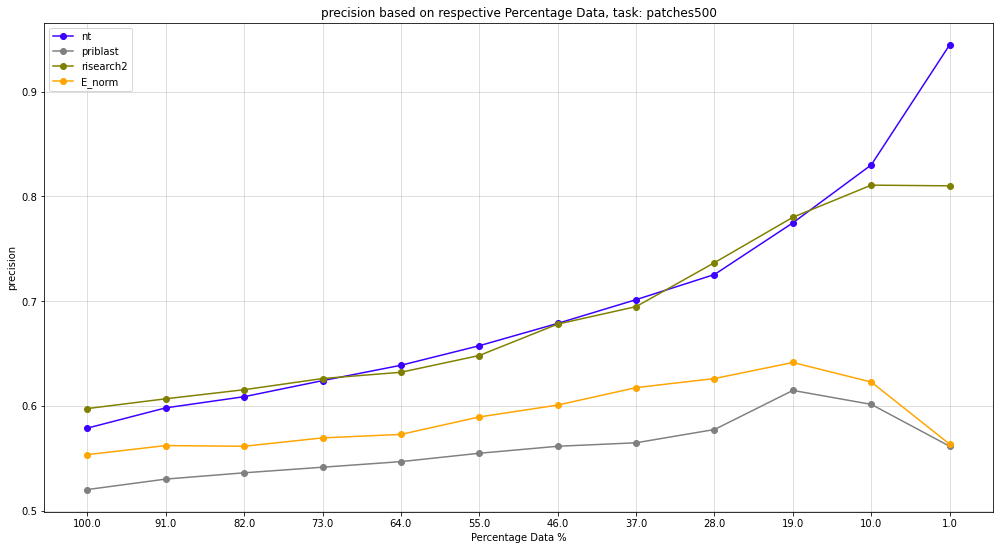




---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


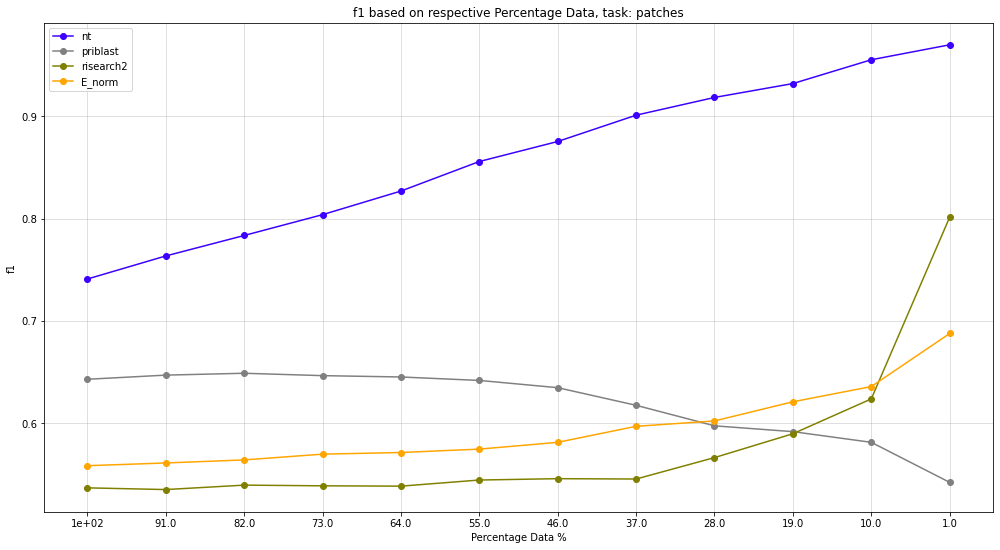

---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


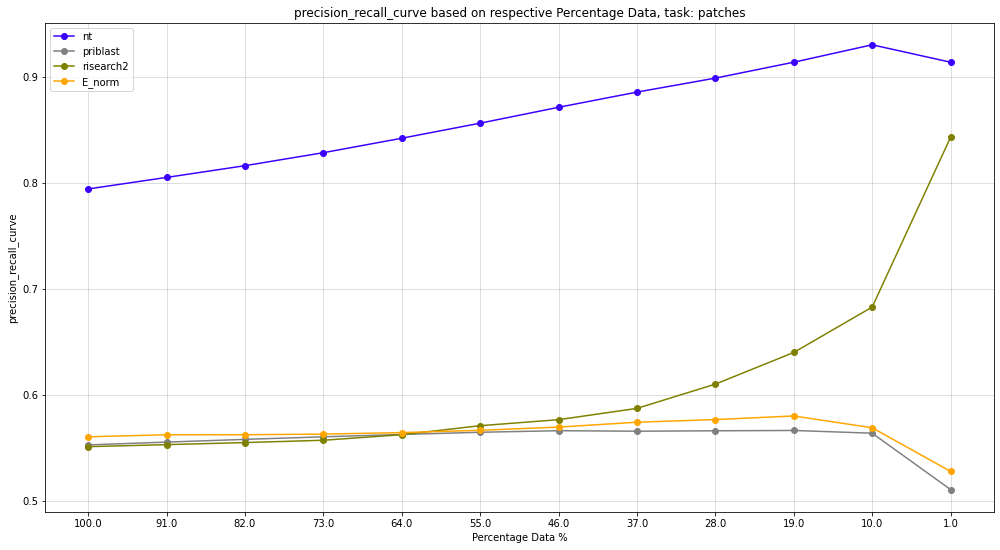

---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


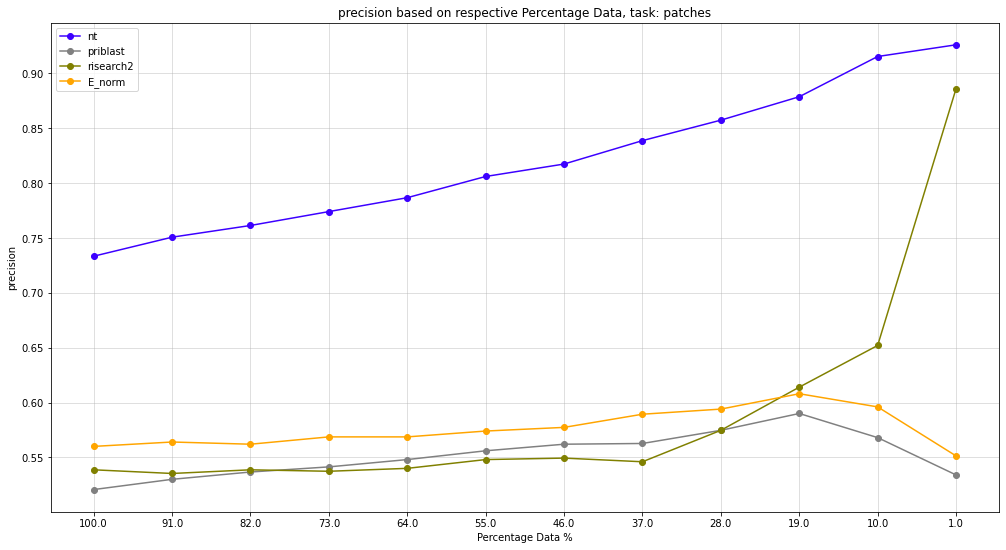




---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


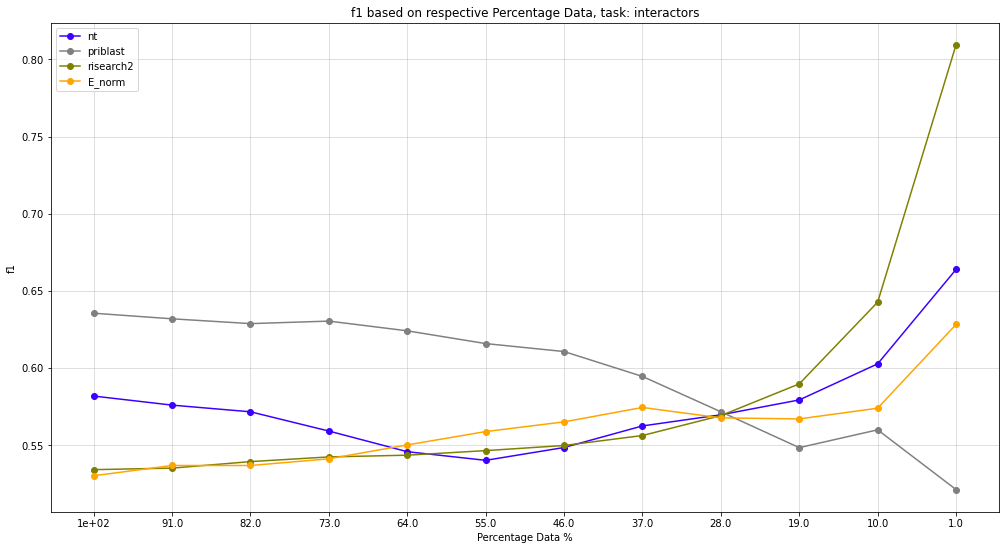

---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


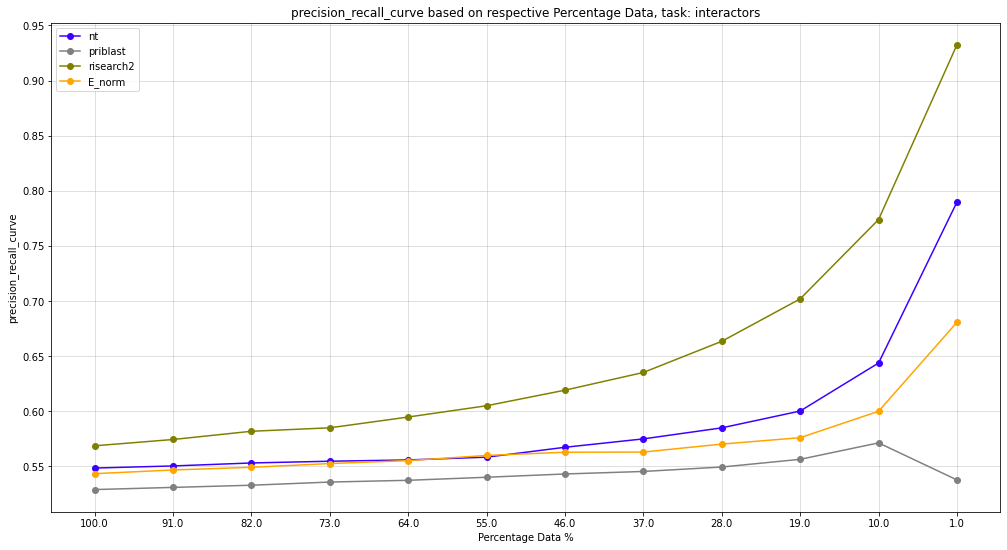

---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


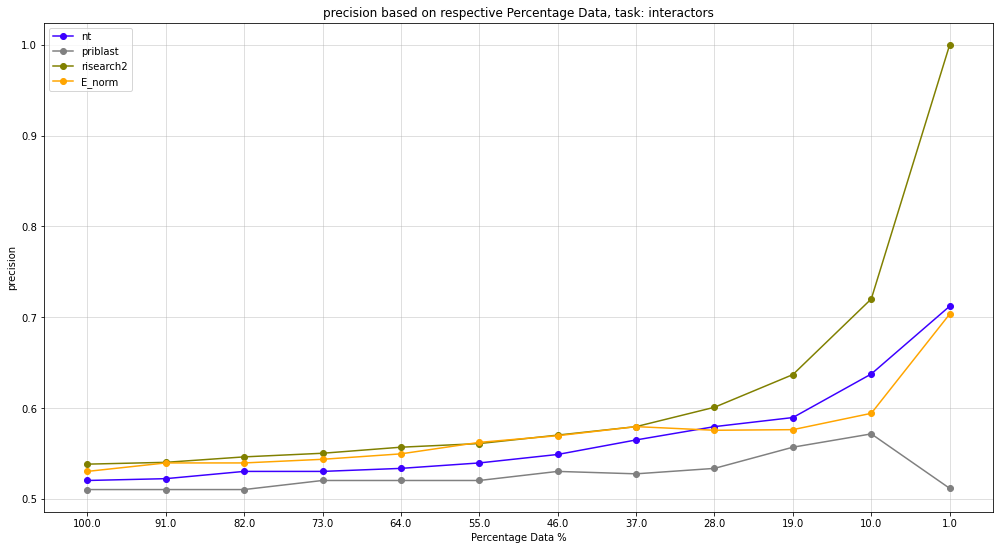




##############   ##############   ##############   ##############   ##############
# excluded couples:  234
# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


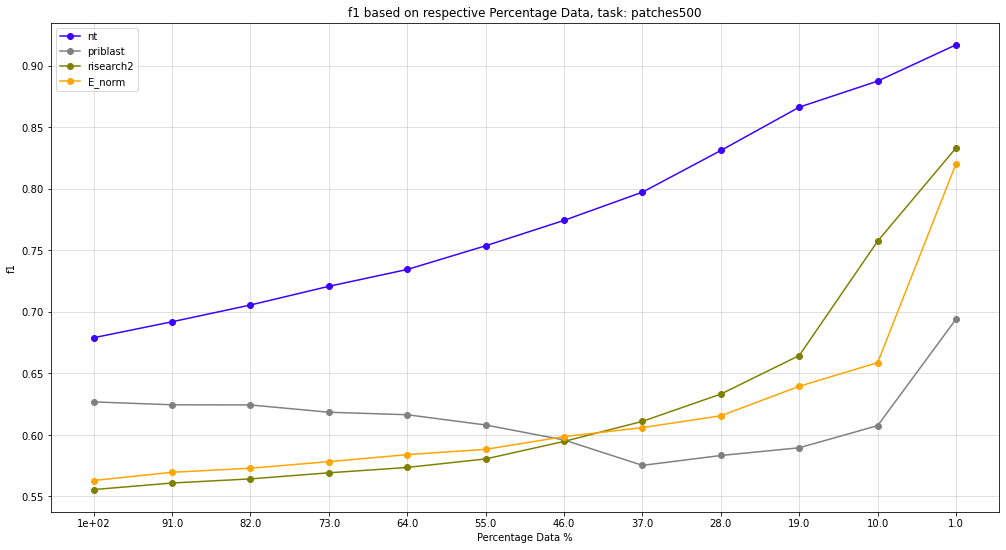

---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


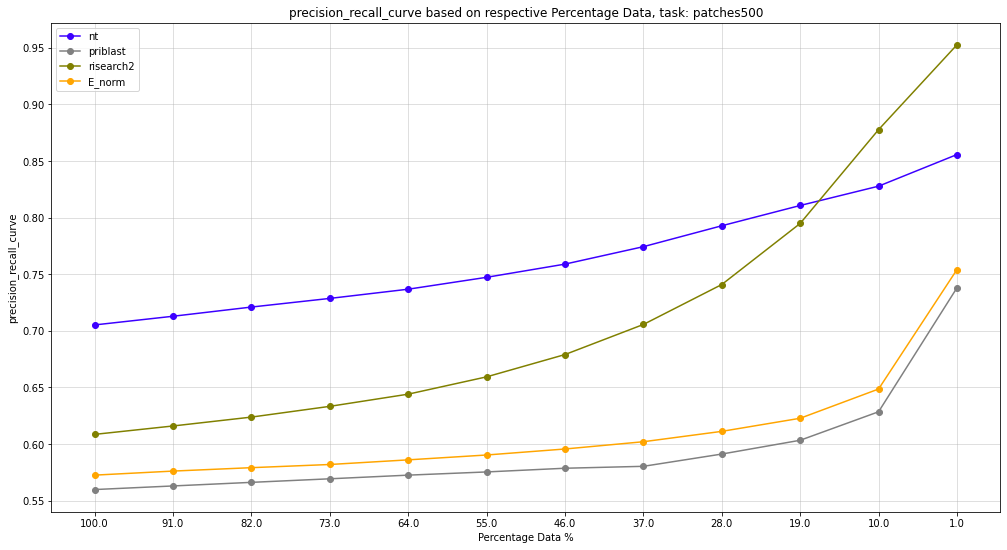

---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


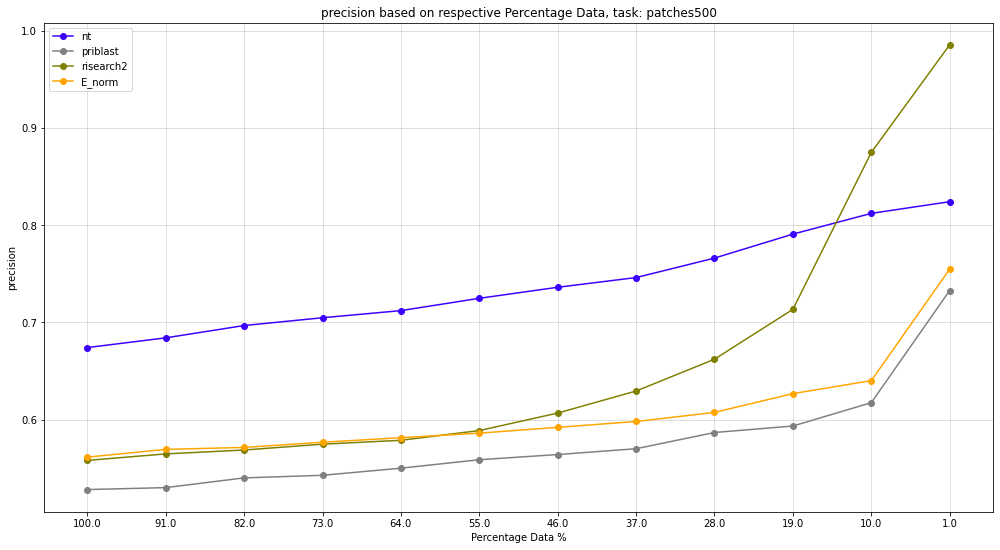




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


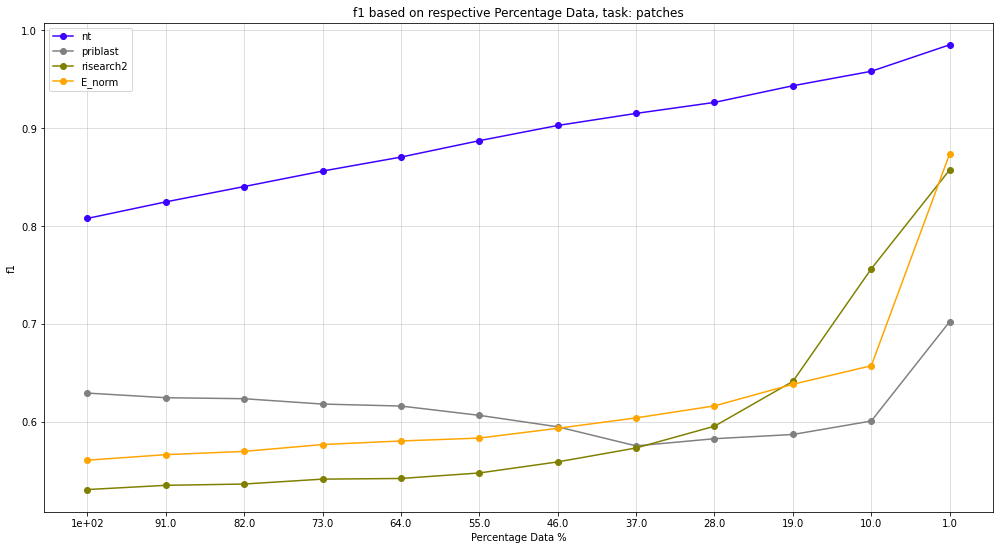

---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


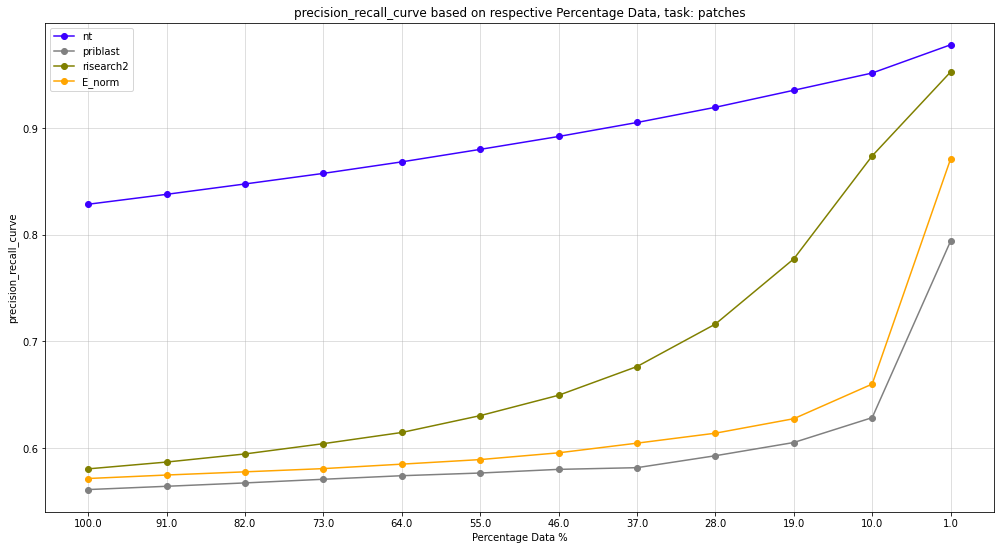

---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


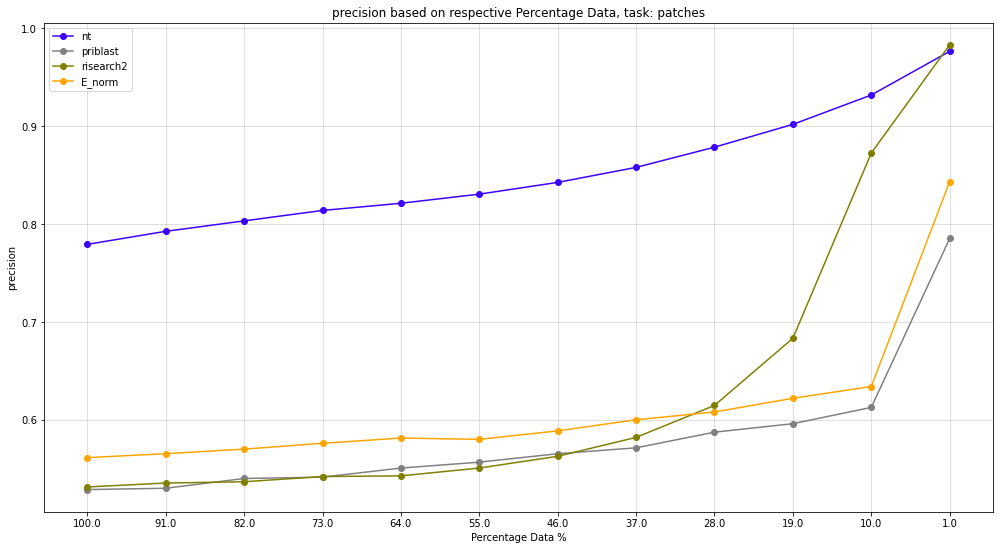




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


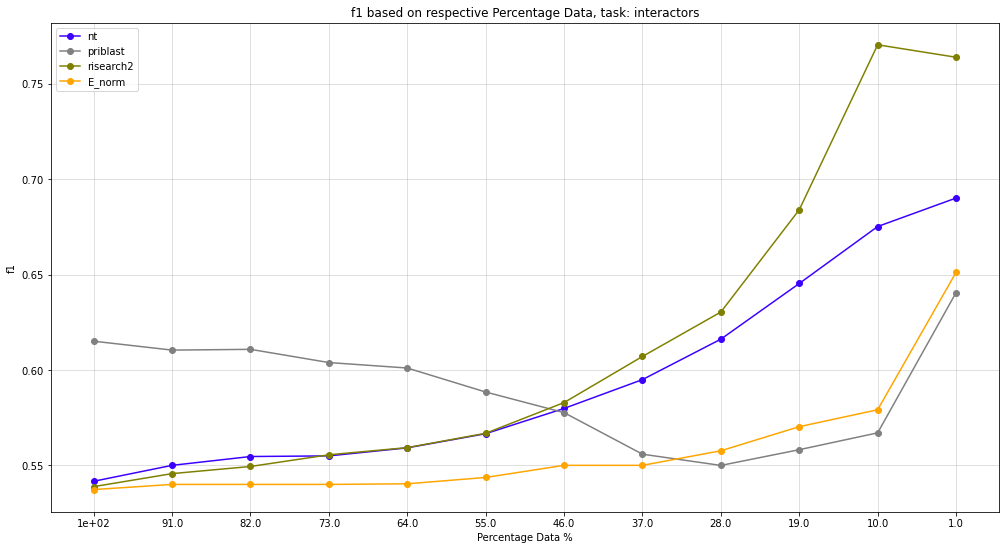

---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


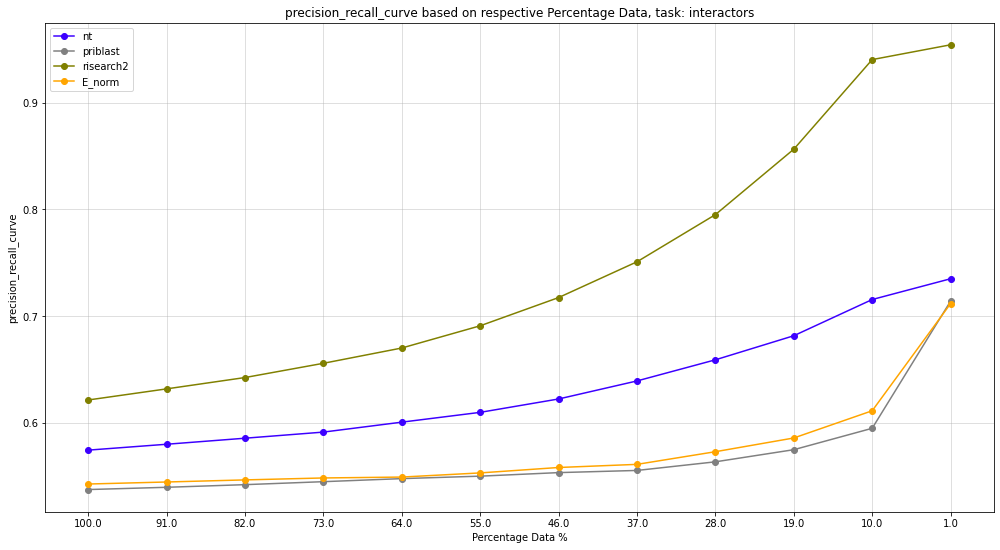

---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


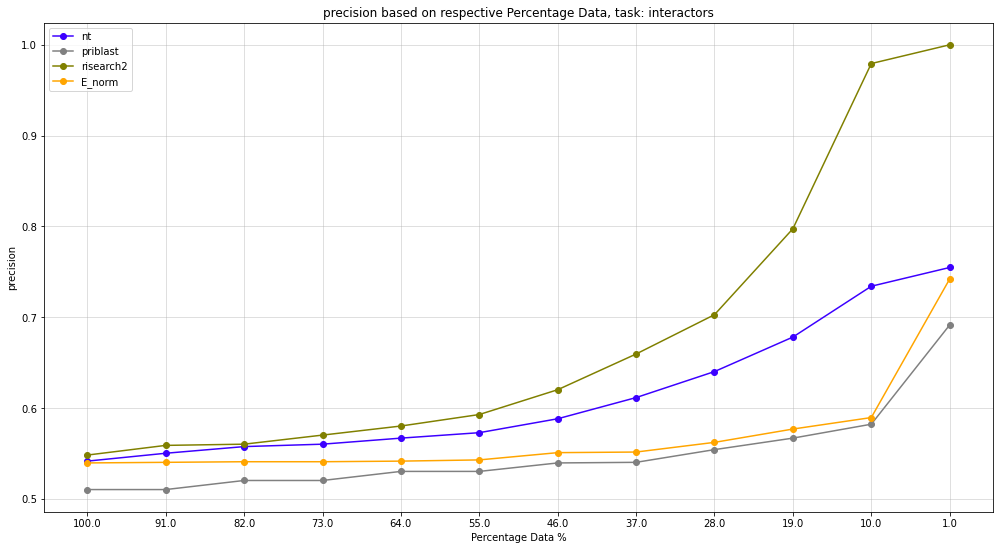




##############   ##############   ##############   ##############   ##############
# excluded couples:  12
# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


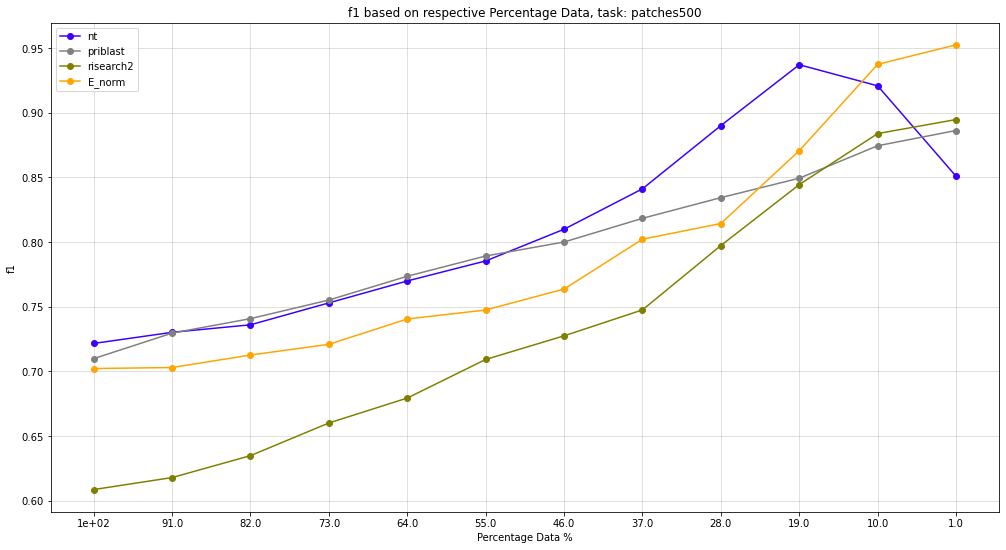

---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


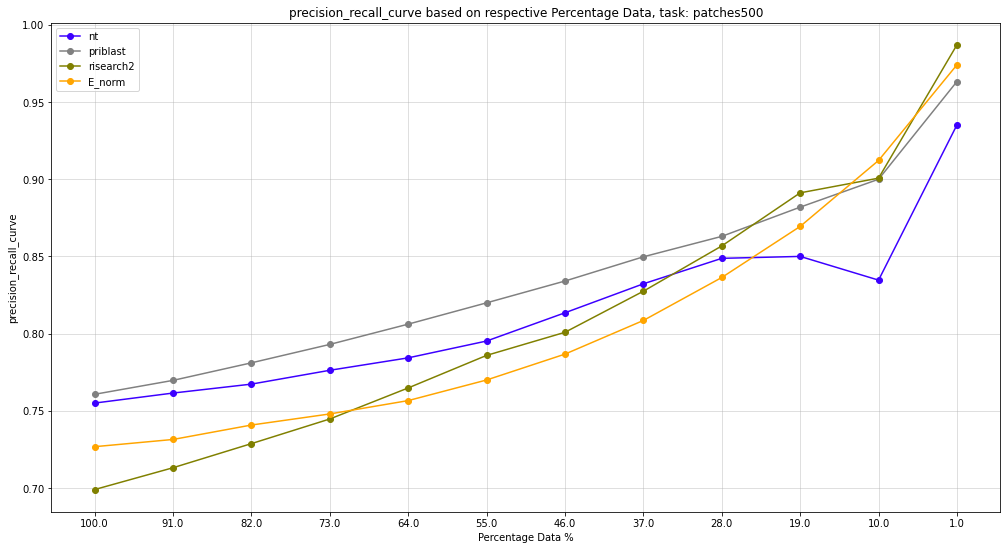

---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


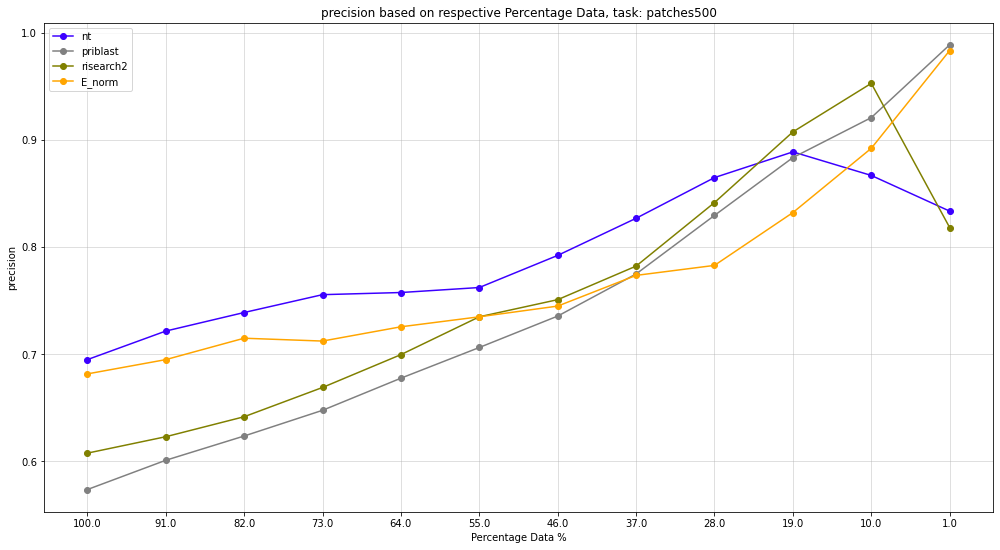




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


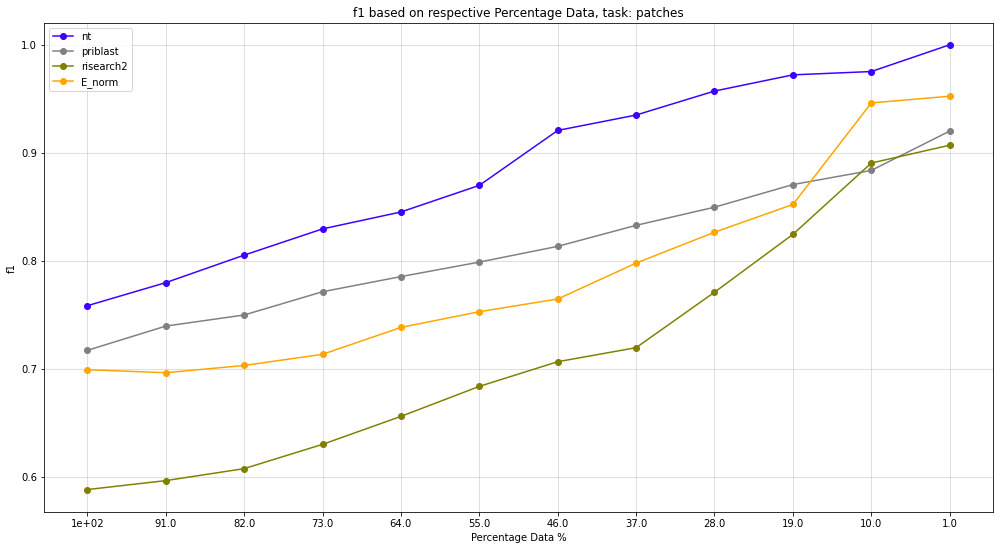

---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


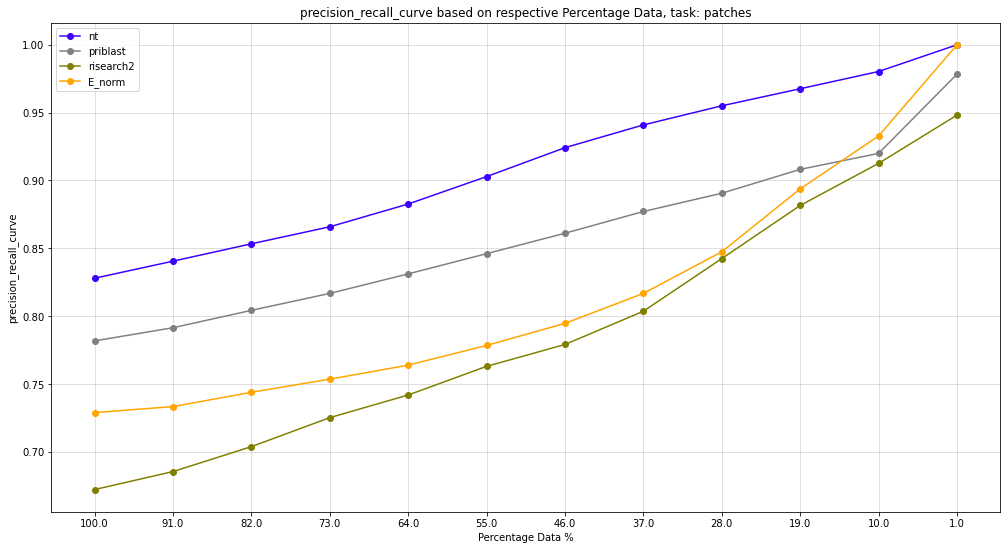

---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


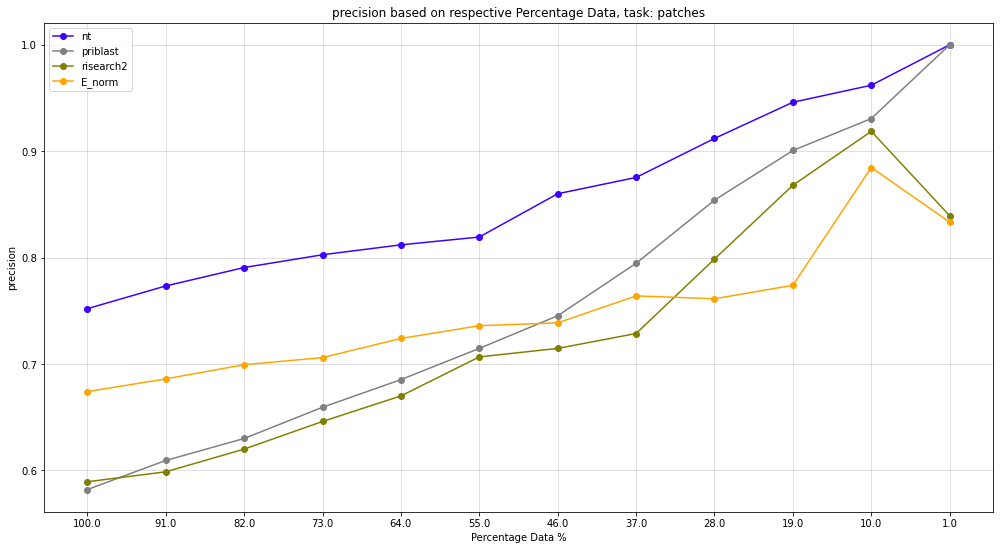




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


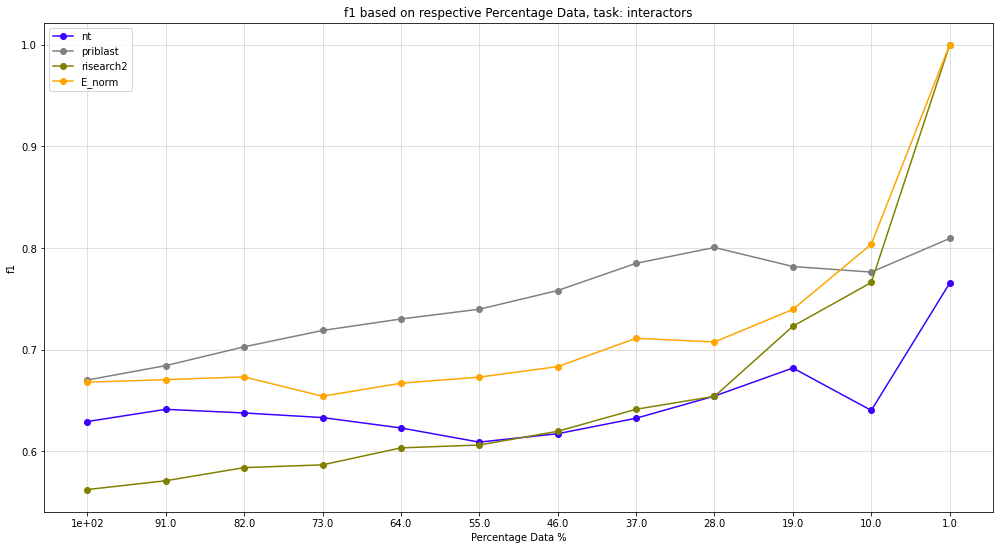

---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


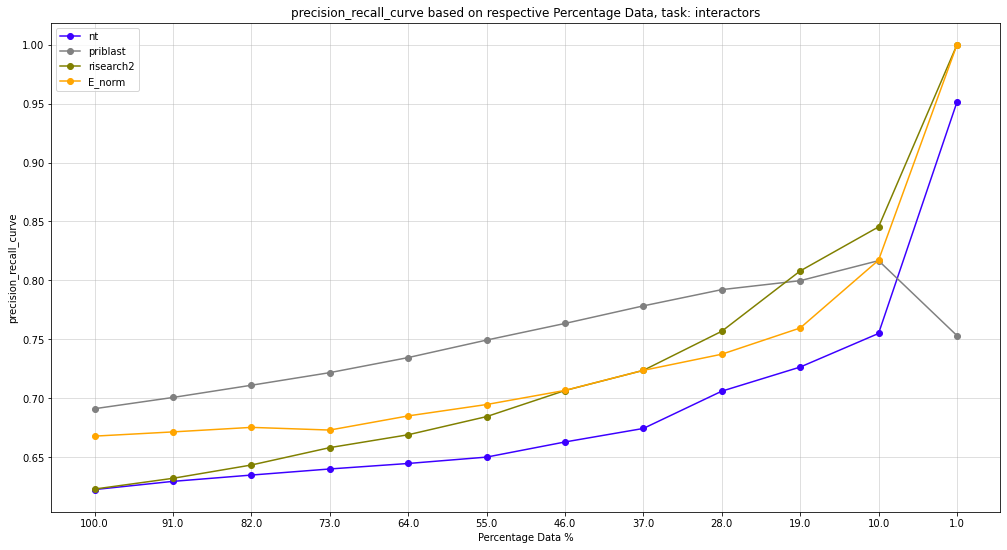

---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


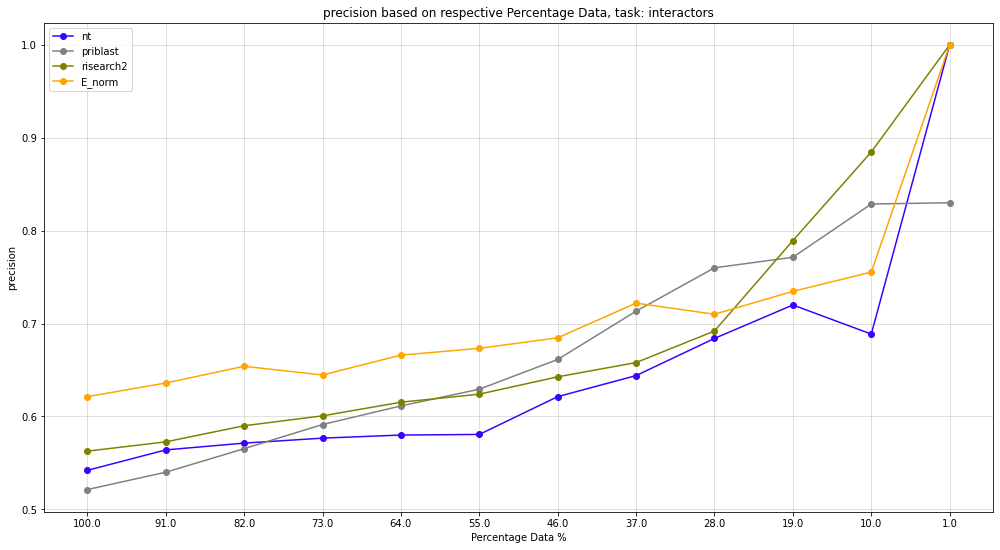




##############   ##############   ##############   ##############   ##############
# excluded couples:  4
# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


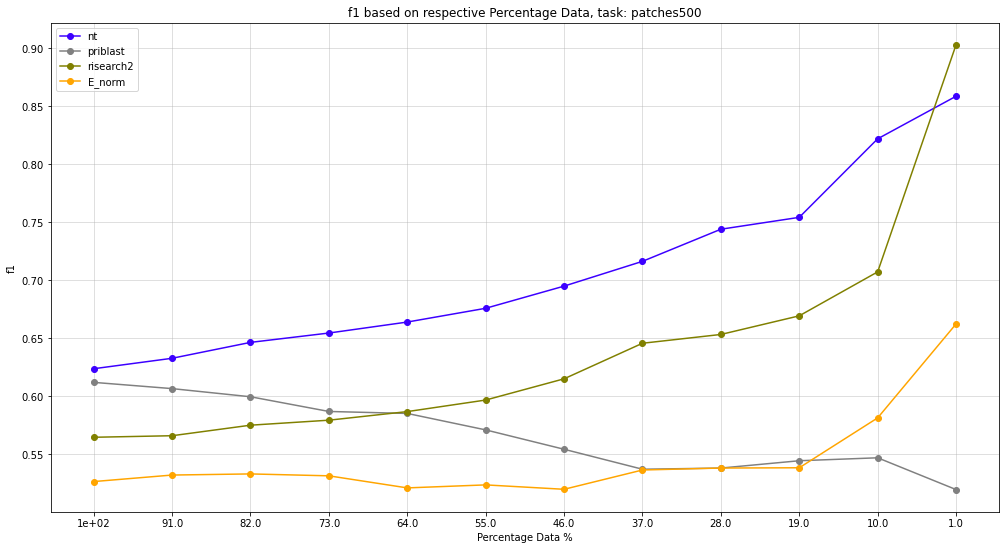

---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


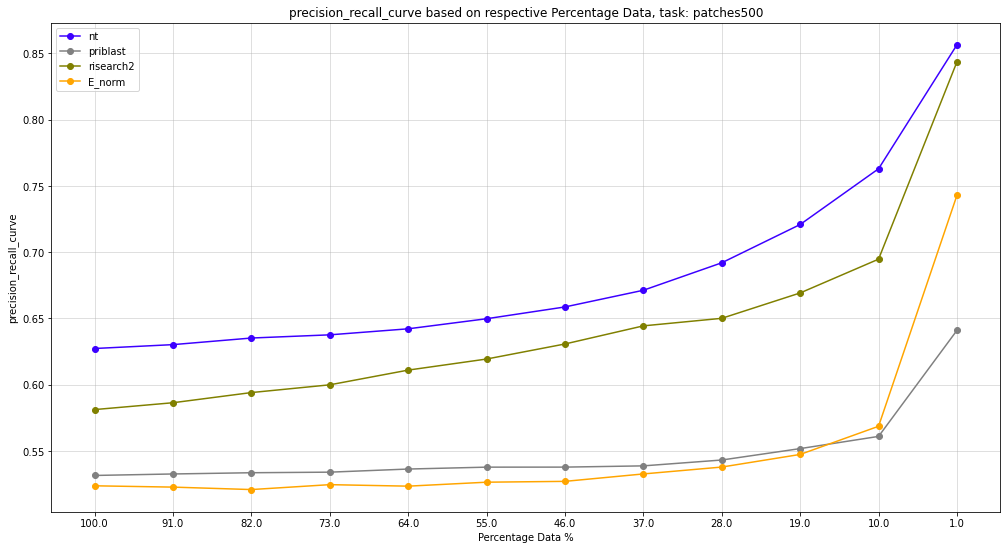

---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


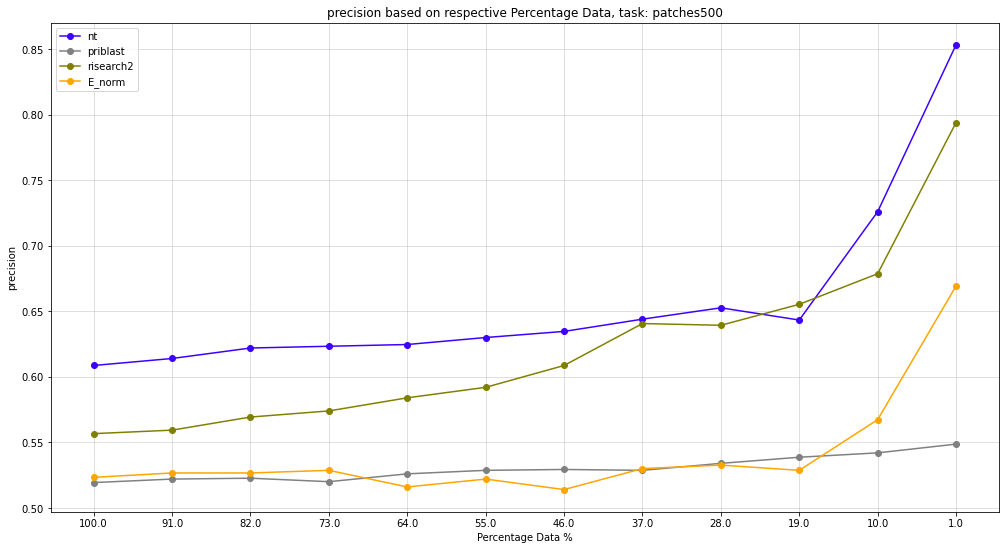




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


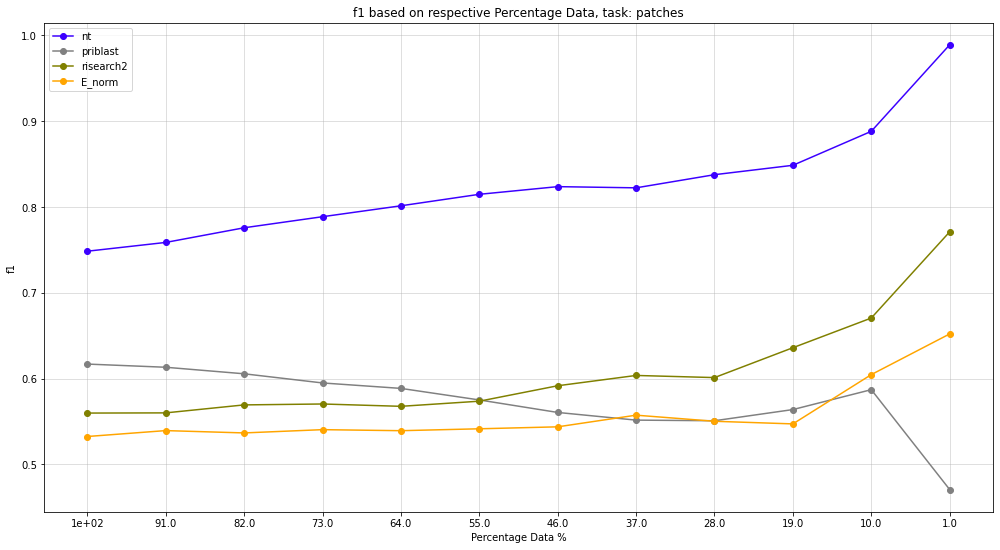

---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


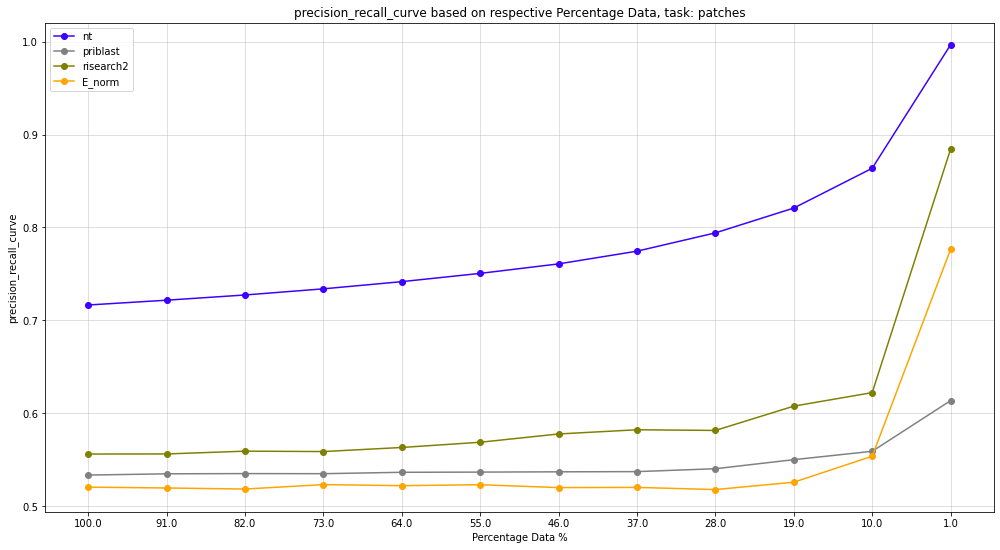

---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


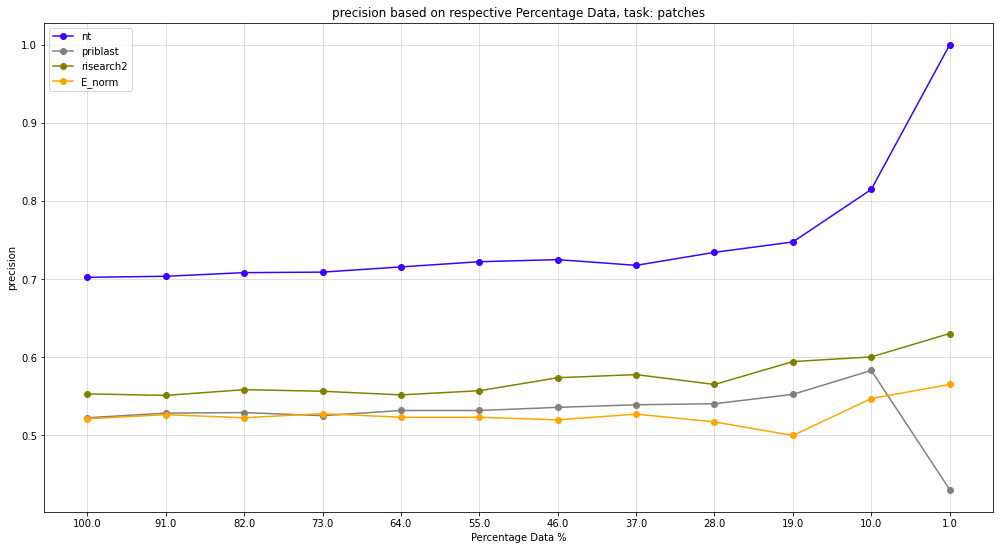




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


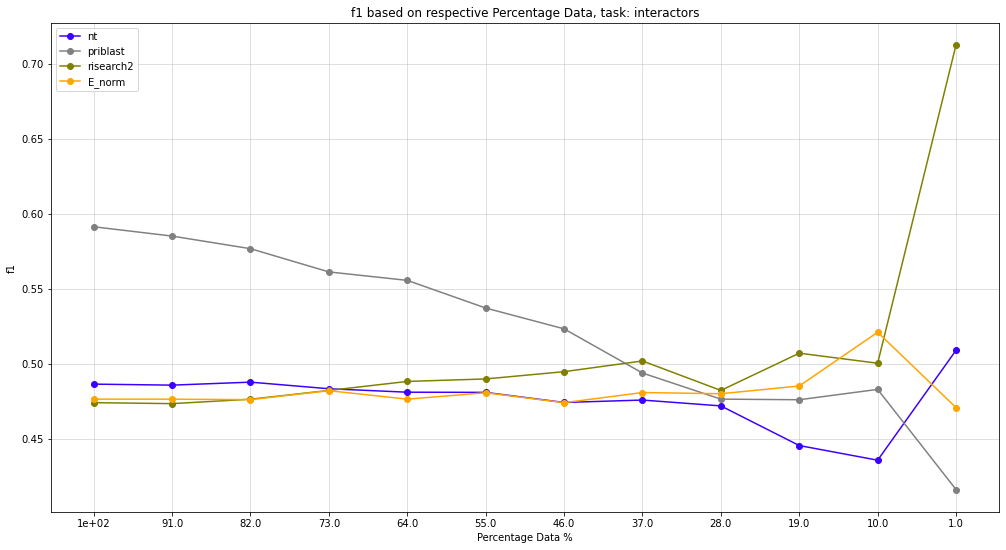

---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


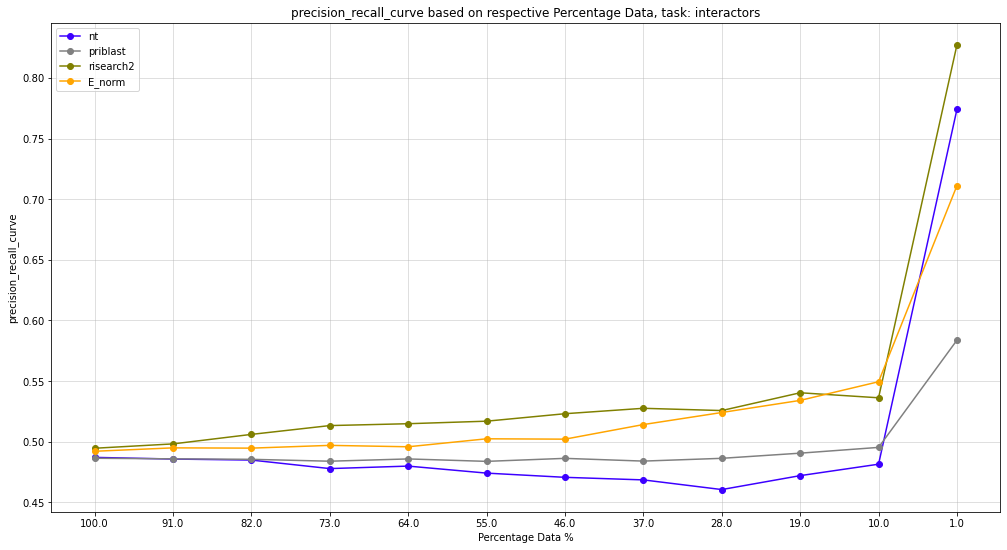

---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


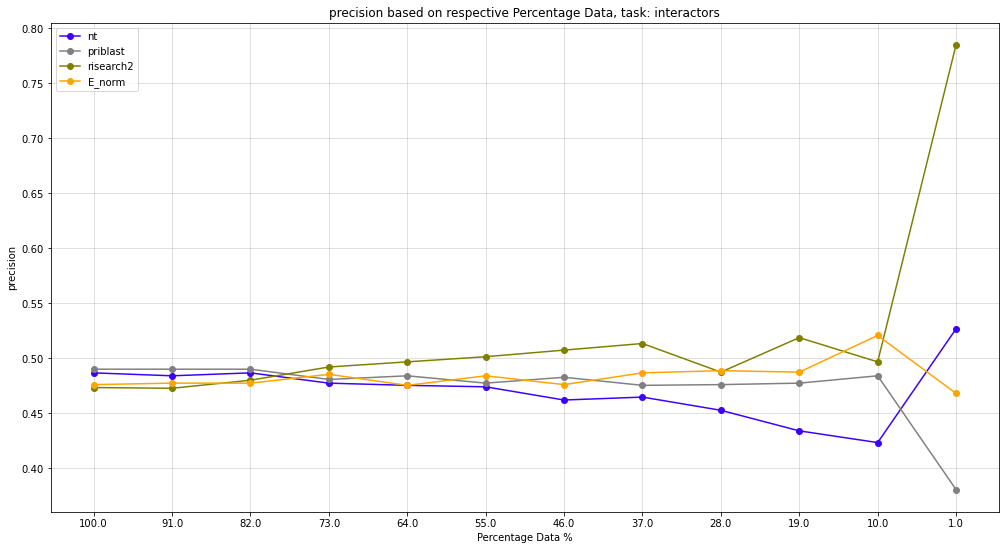

In [23]:
#plot parameters
MIN_PERC = 1
list_of_metrics = ['f1', 'precision_recall_curve', 'precision'] #['f1','precision', 'npv'] #[['f1','precision', 'npv', 'recall', 'specificity', 'precision_recall_curve']
balance_predictions_at_each_step=False
plot_results_of_all_models(external_dataset_dir, checkpoint_dir, tools, logistic_regression_models, datasets, args_datasets, energy_columns, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, list_of_metrics, figsize, size_multiplier, based_on_threshold = False, balance_predictions_at_each_step=balance_predictions_at_each_step)

# How good is in predicting EN in the same embedding matrixes of SN? How good is in predicting HN in the same embedding matrixes of EP?
### Patches task depend on the distance from the interaction site

In [12]:
figsize = (17, 9)
size_multiplier = 20
bins_distance = [[0, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]

In [13]:
%load_ext autoreload
%autoreload 2
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------- DATASET: paris ----------


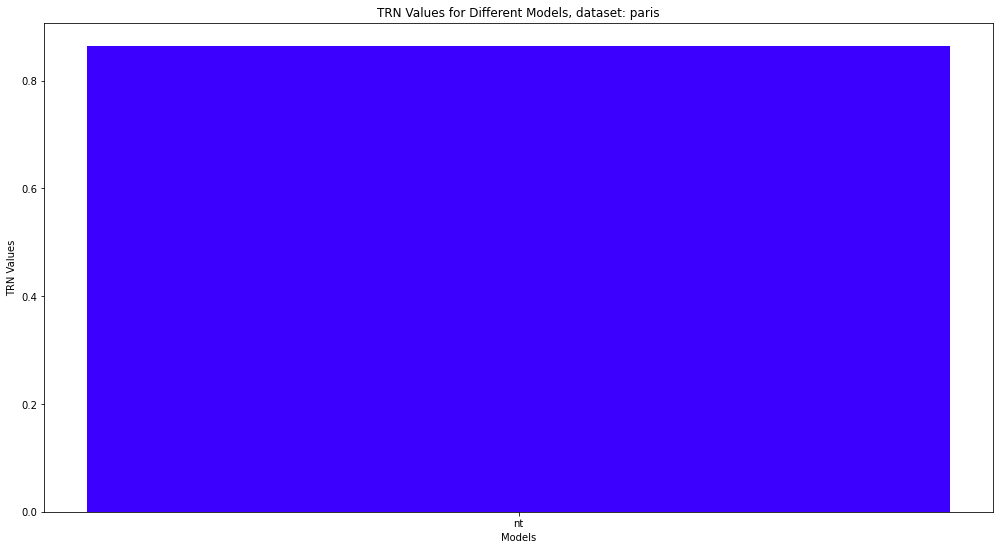

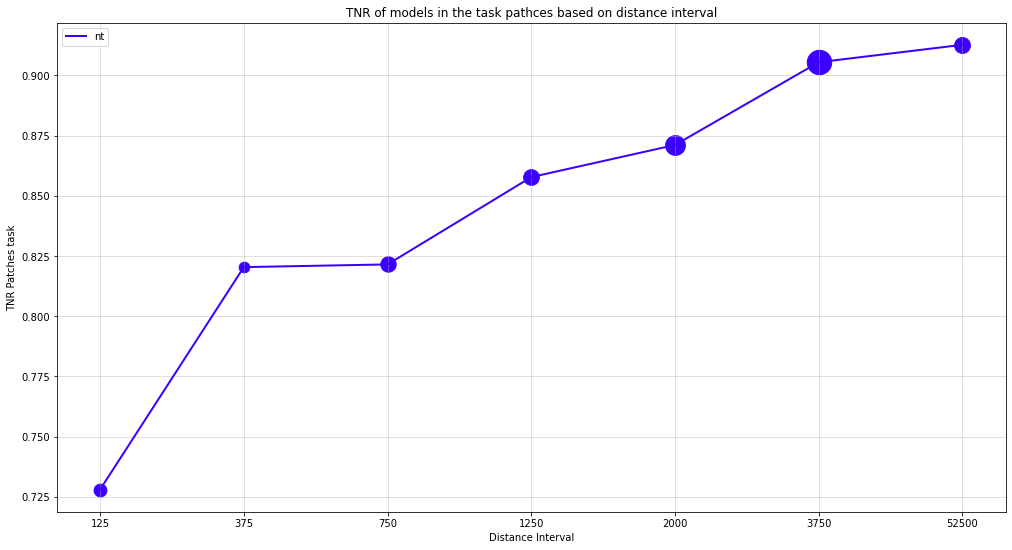

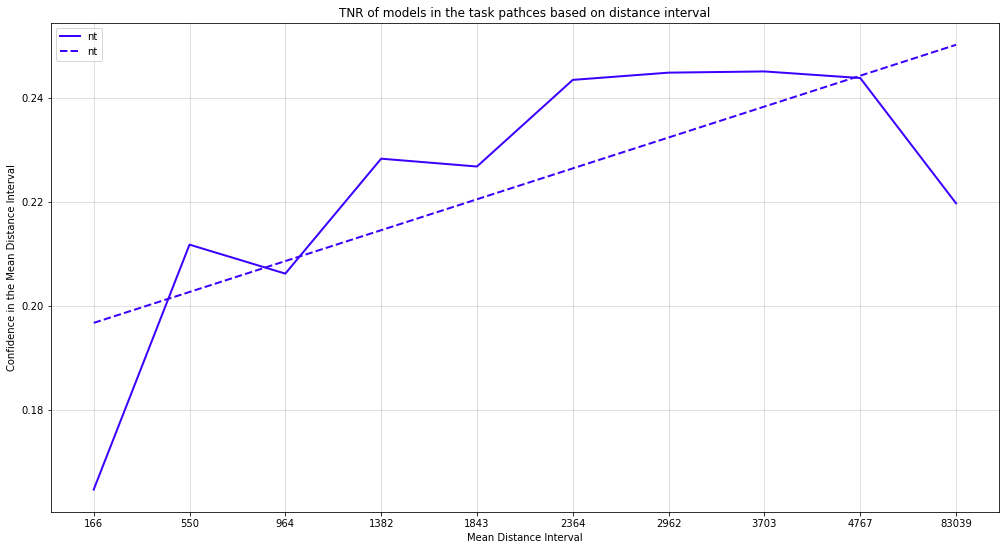

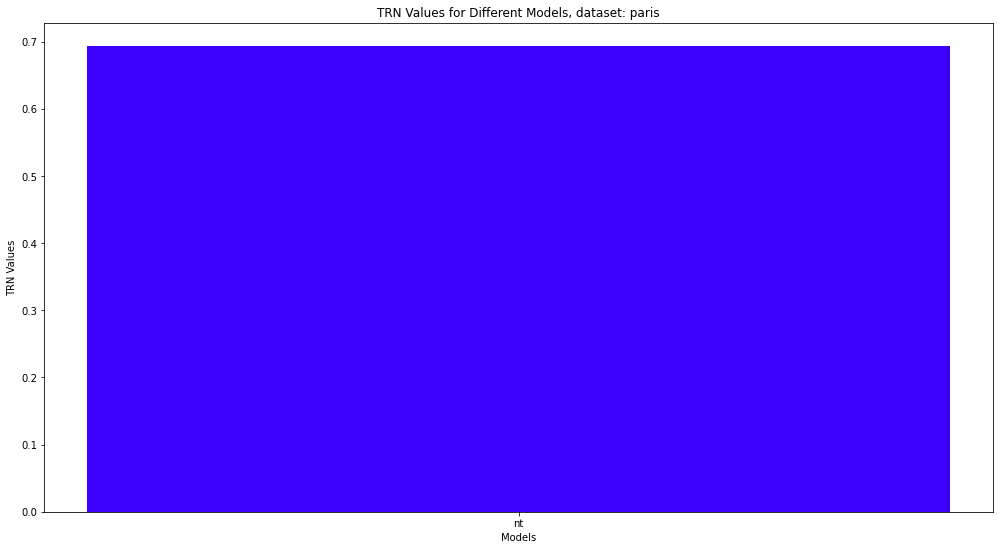

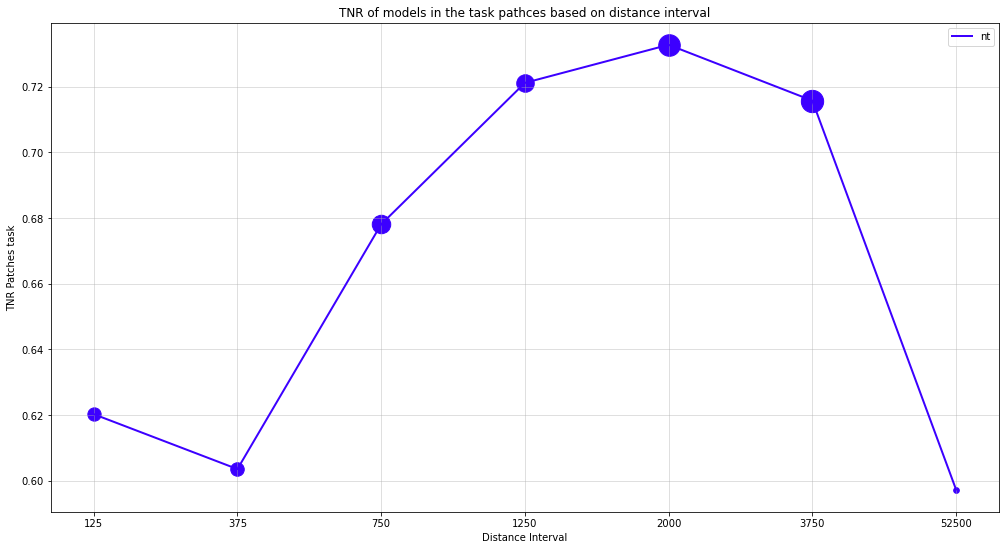

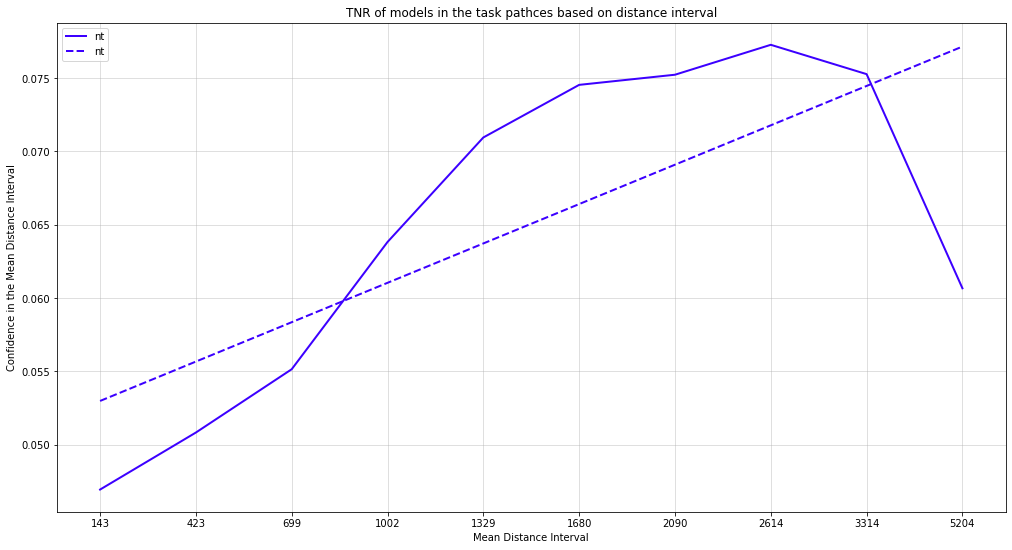

# excluded couples:  234
# excluded couples:  234
---------- DATASET: ricseq ----------


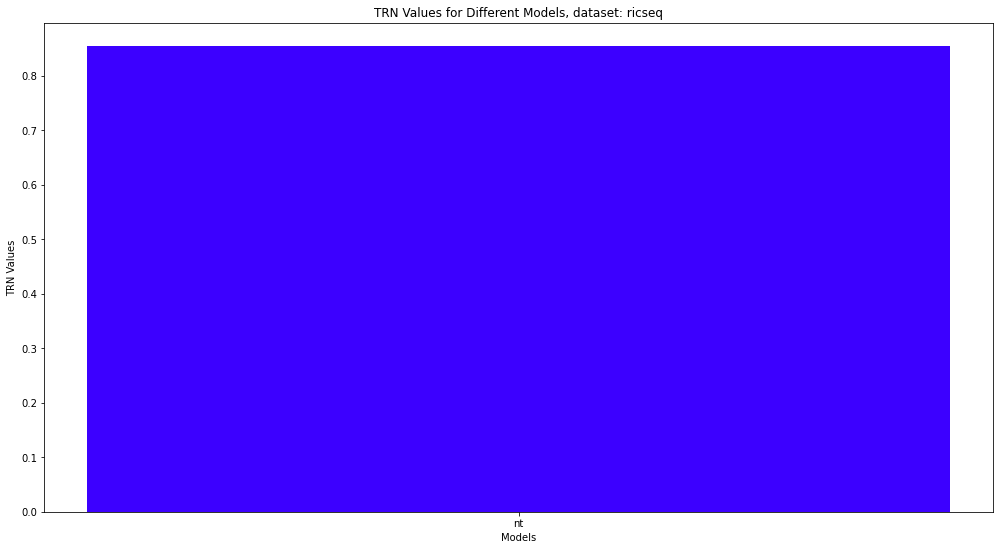

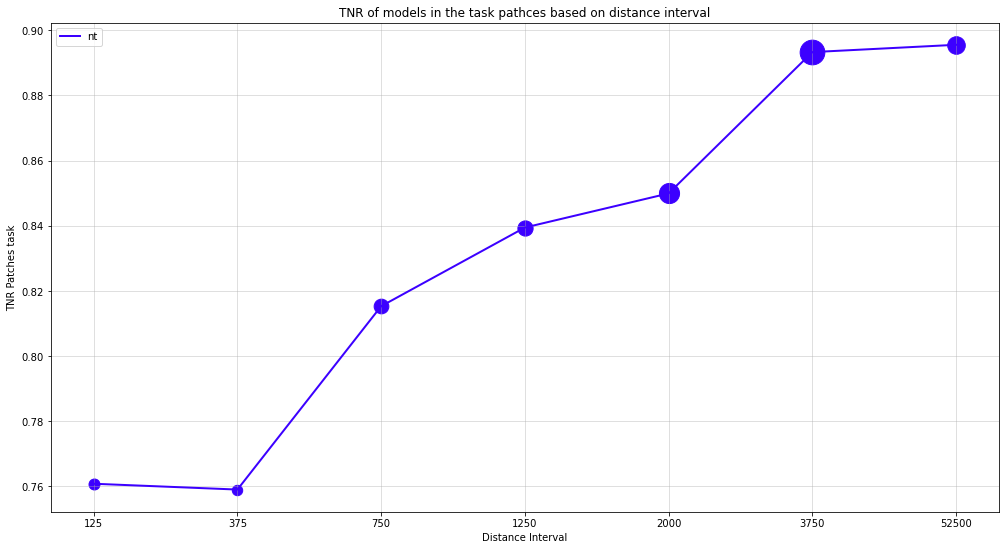

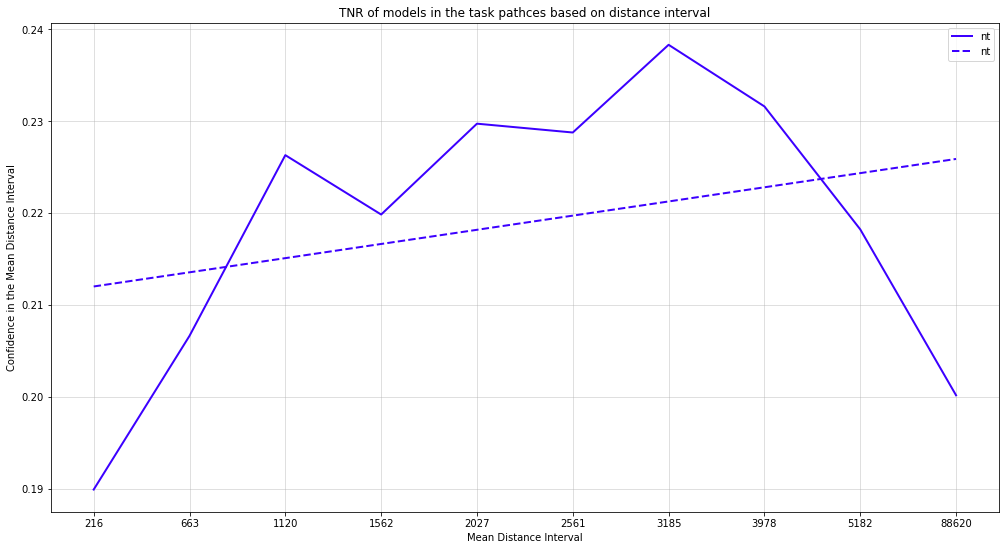

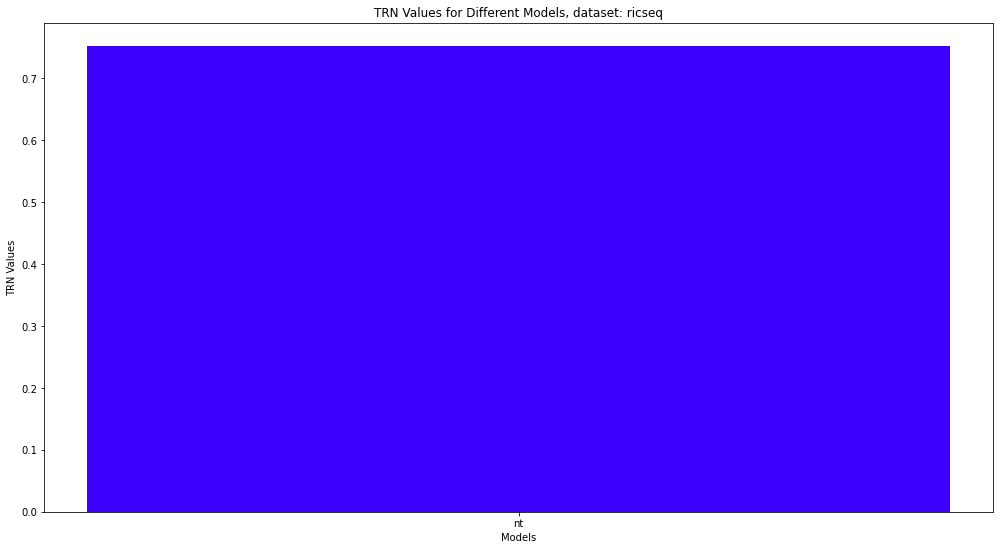

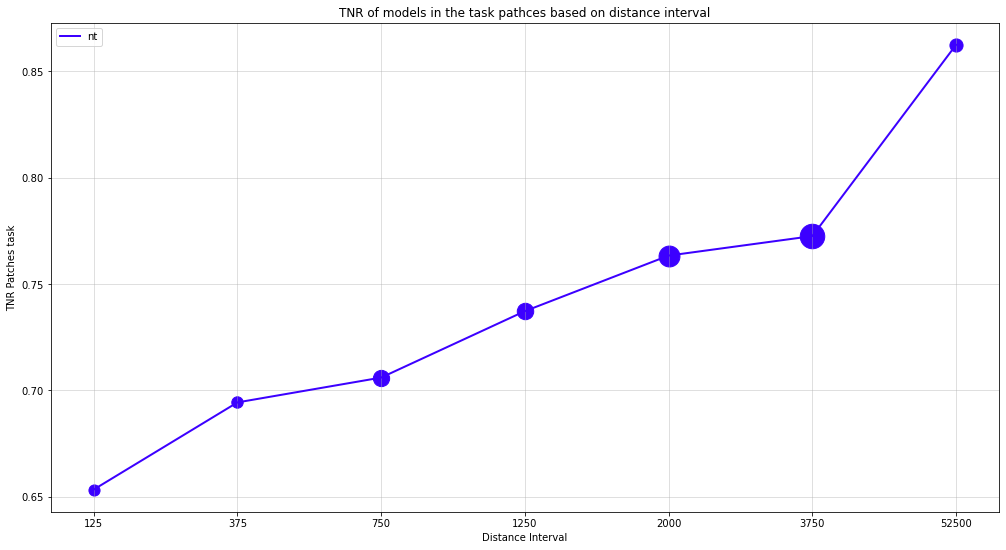

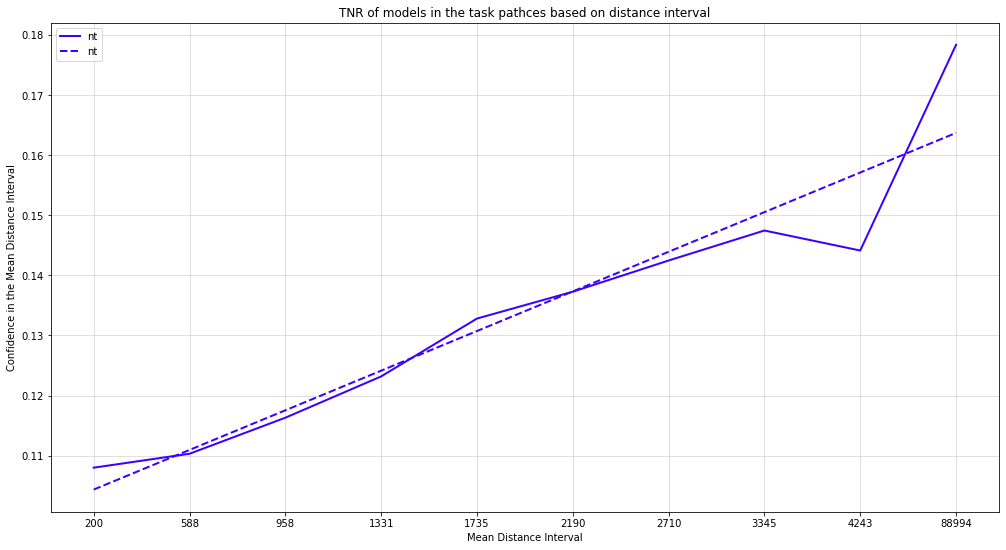

# excluded couples:  12
# excluded couples:  12
---------- DATASET: splash ----------


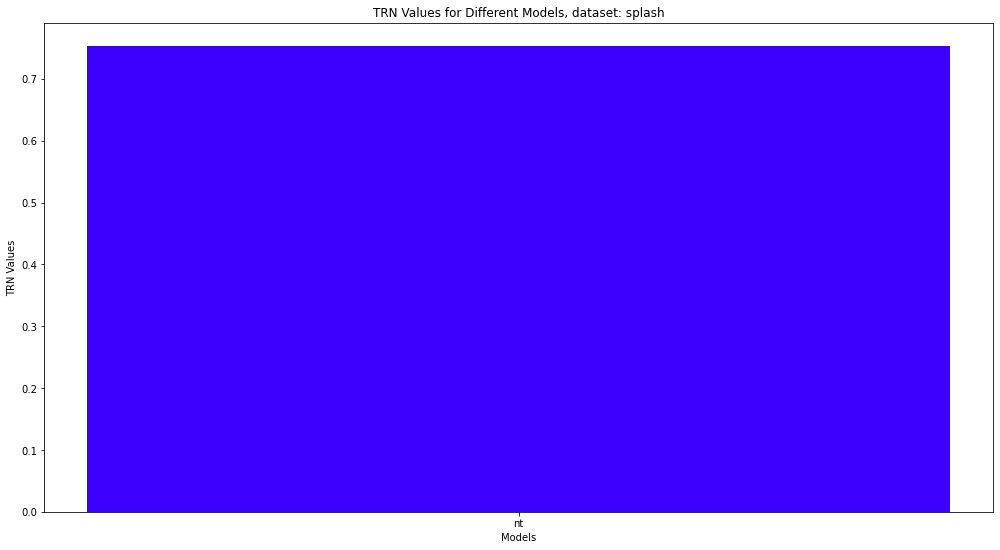

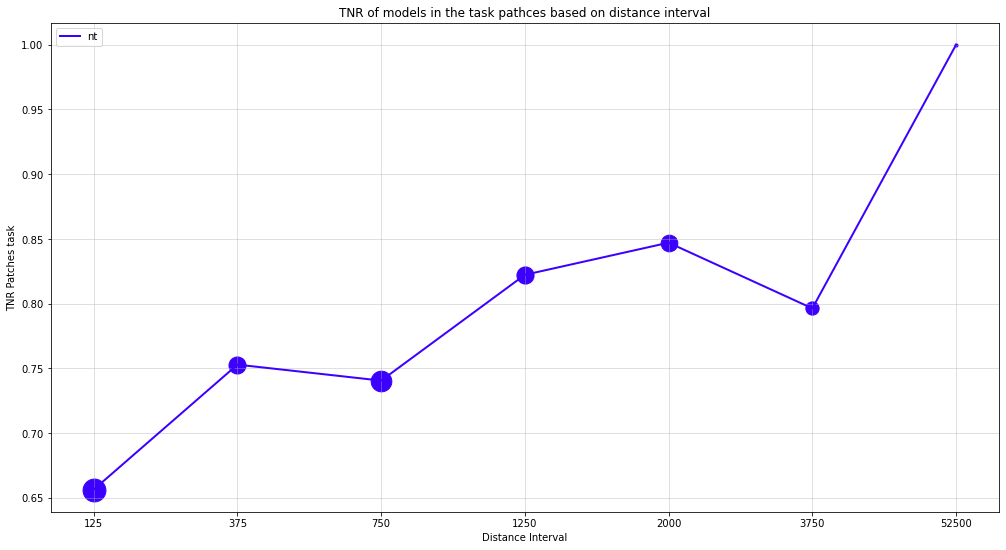

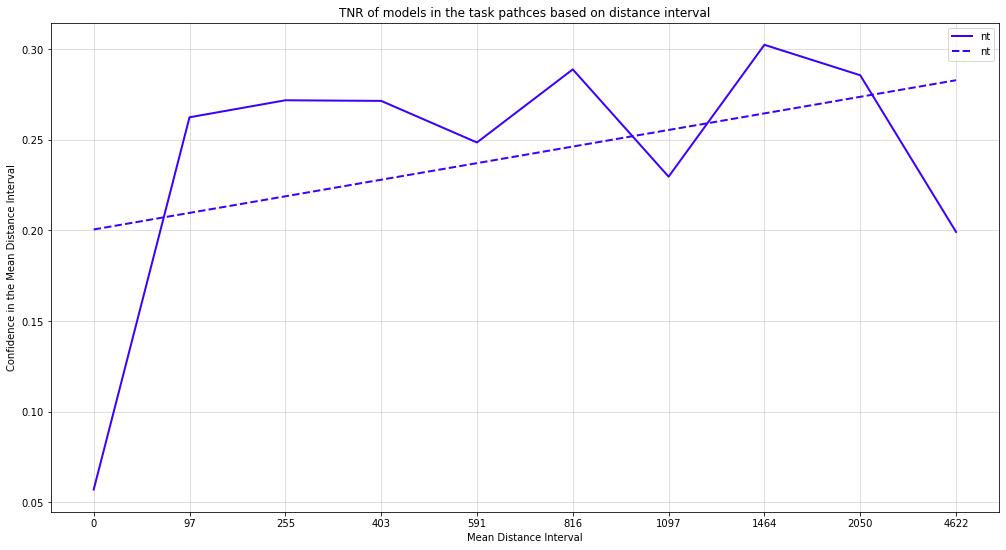

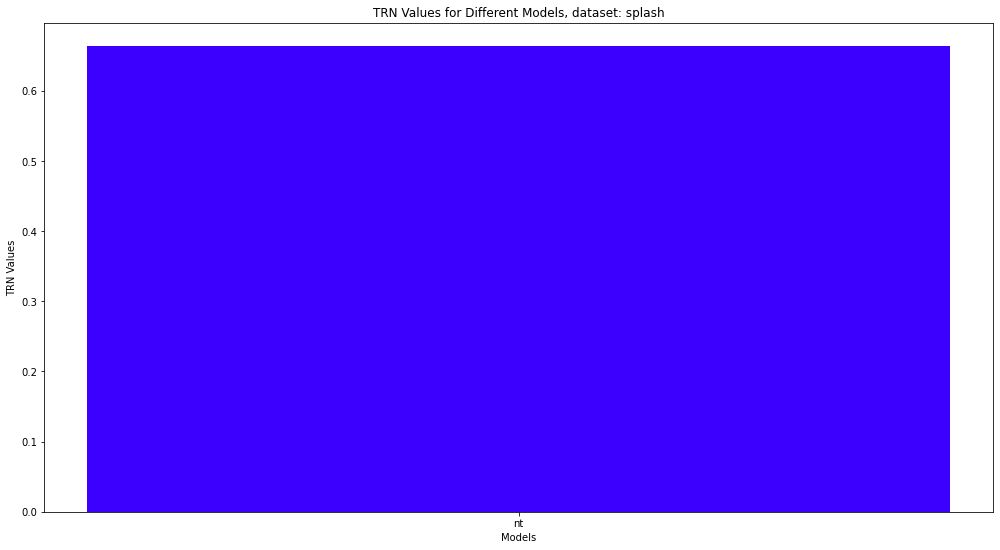

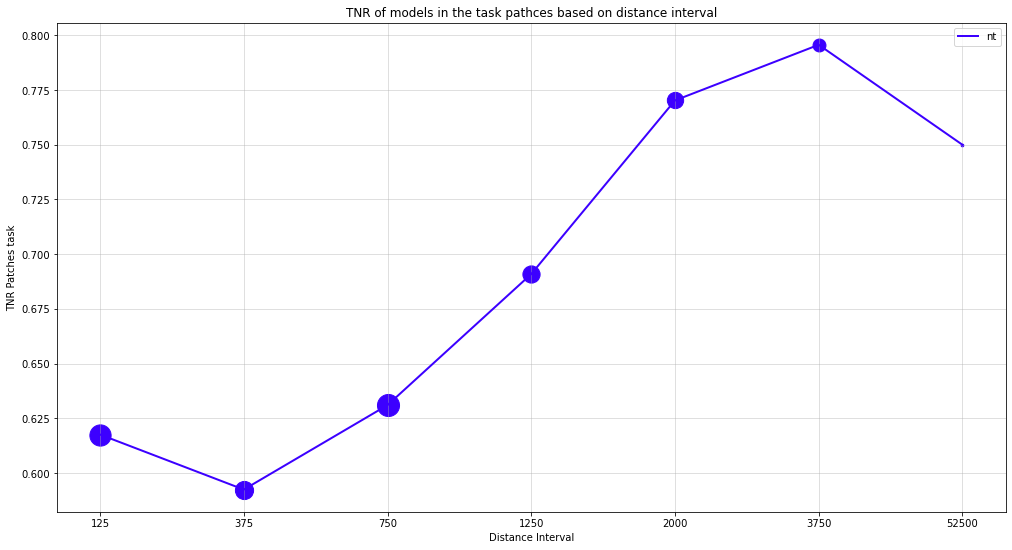

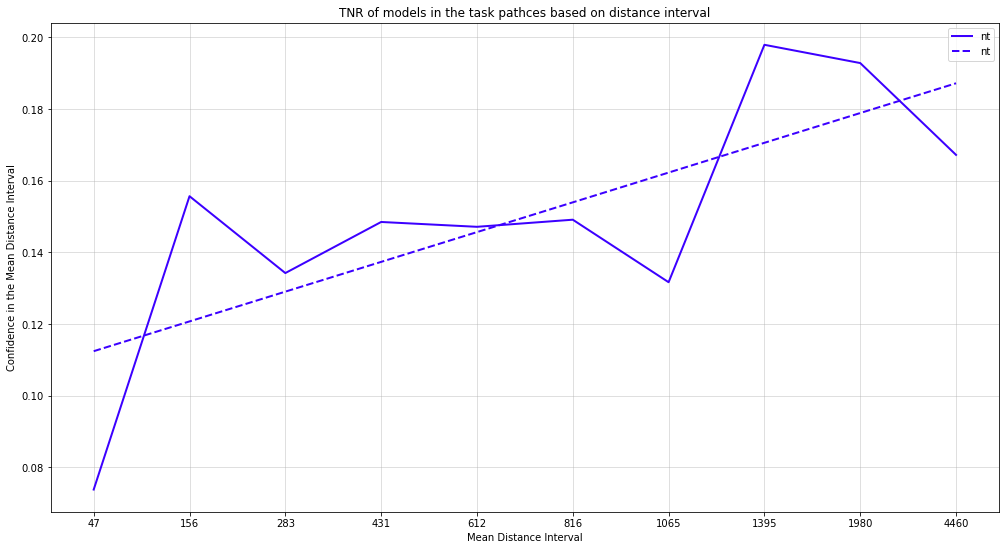

# excluded couples:  4
# excluded couples:  4
---------- DATASET: mario ----------


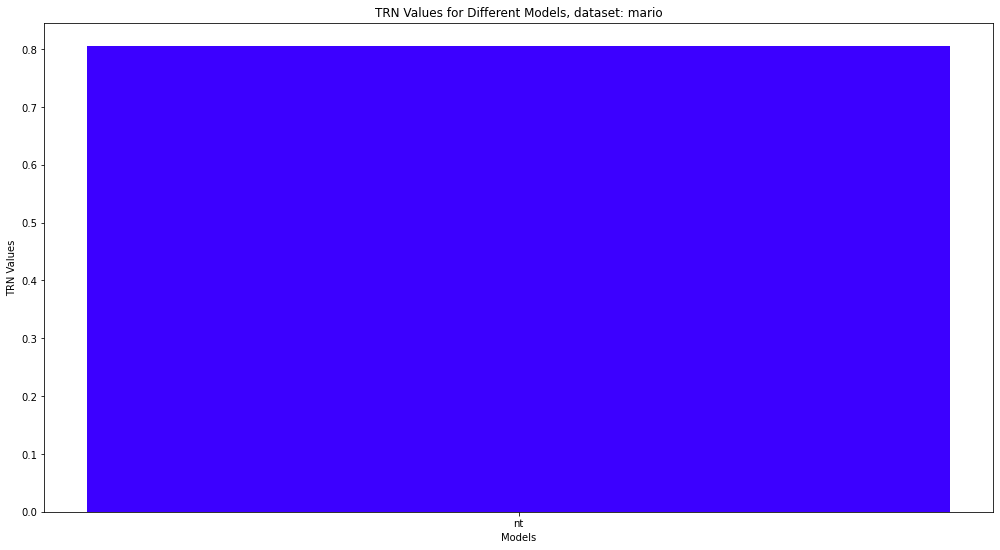

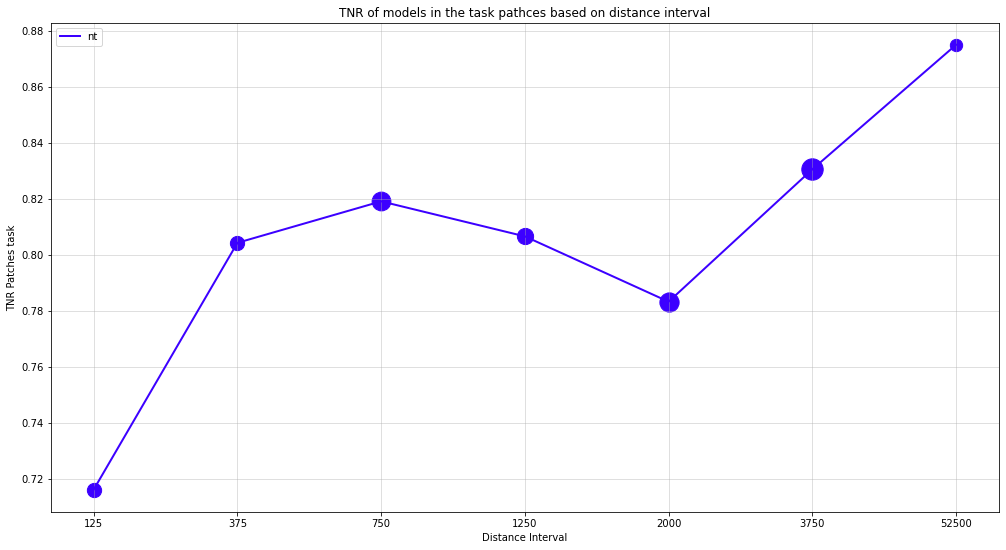

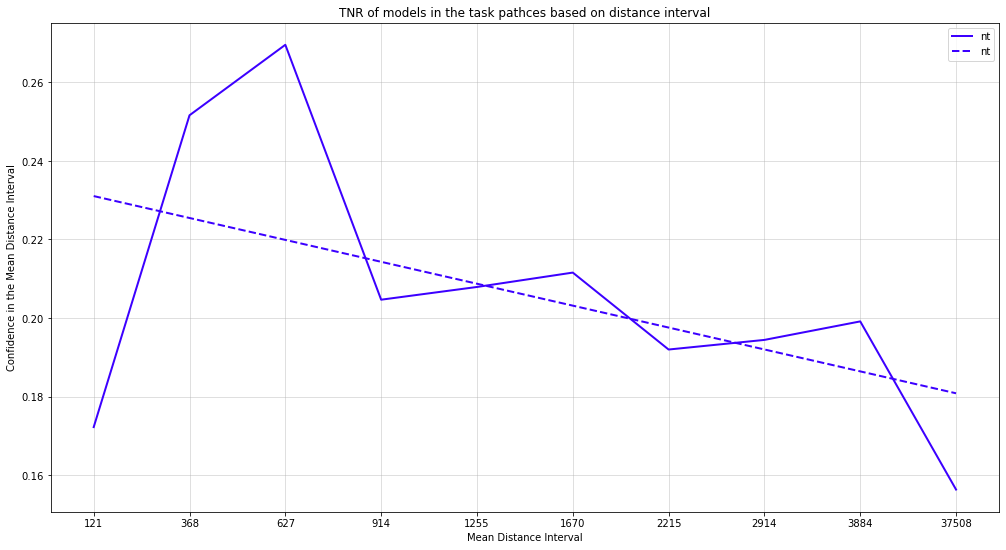

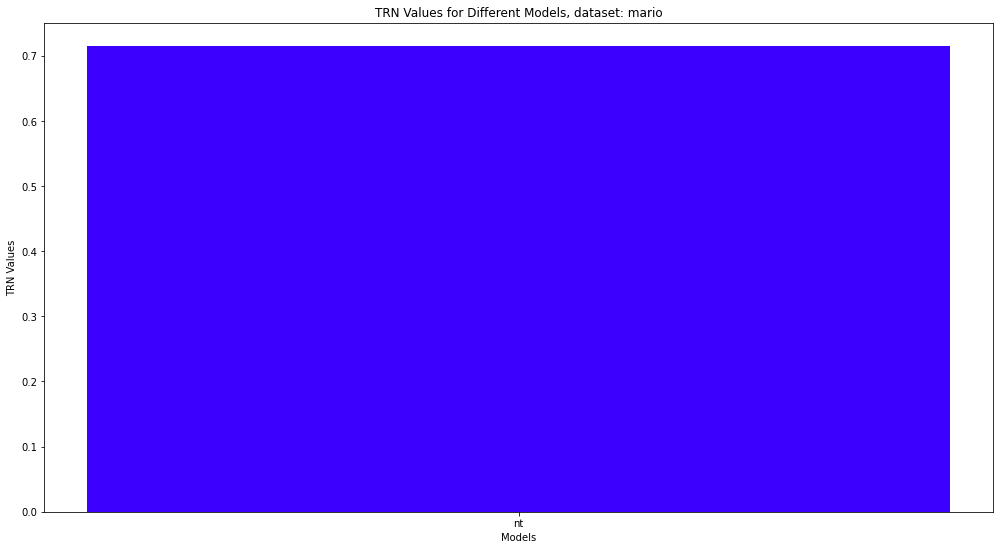

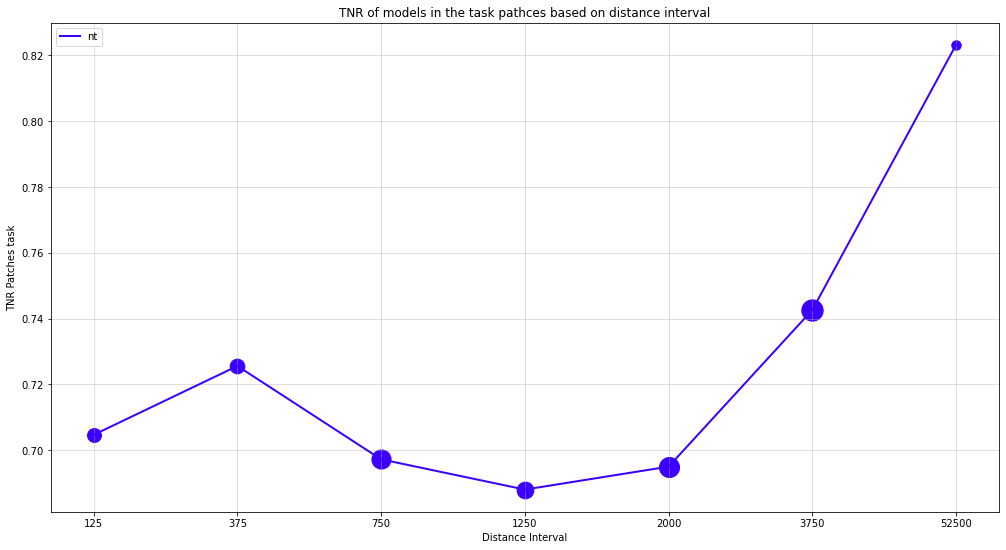

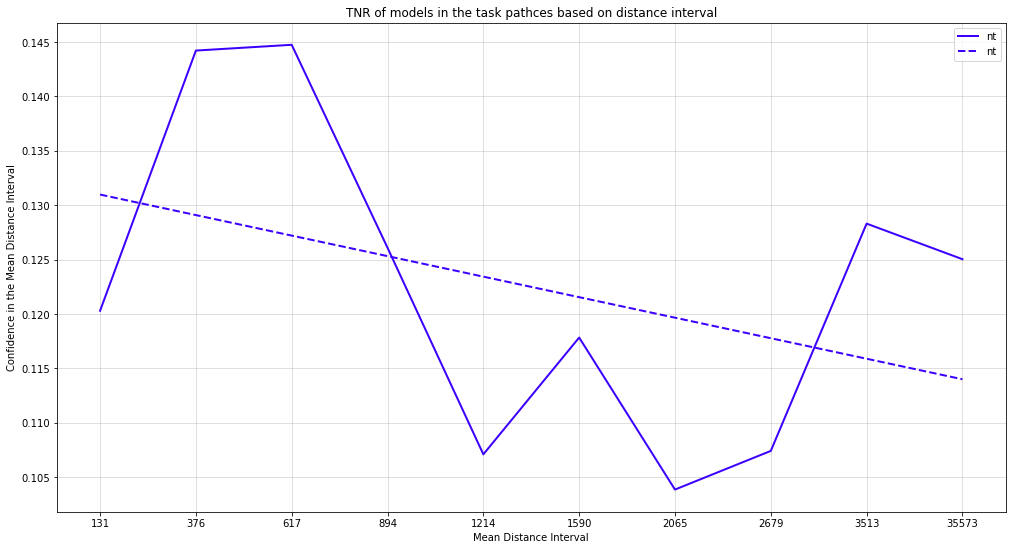

In [17]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,)
    
    enhn = res[(res.policy == 'easyneg')|(res.policy == 'hardneg')].reset_index(drop = True)    
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                 SPECIE_PARIS,
                                 args_datasets[how]['PARIS_HQ'],
                                 args_datasets[how]['PARIS_HQ_THRESHOLD'],
                                 True
                                )   
    
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]

        X_test = np.expand_dims(enhn[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        enhn[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping

        X_test = np.expand_dims(enhn500[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        enhn500[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping

            
    print(f'---------- DATASET: {dataset} ----------')
        
    for subset_to_plot in [enhn.copy().reset_index(drop = True), enhn500.copy().reset_index(drop = True)]:
        plot_tnr_for_all_models(['nt'], #list_of_models_to_test
                                subset_to_plot, 
                                figsize = figsize, 
                                title_suffix = f'dataset: {dataset}', 
                                bar_width = 0.5
                               )
        plot_tnr_based_on_distance_for_all_models(subset_to_plot,
                                                  bins_distance,
                                                  ['nt'], #list_of_models_to_test
                                                  figsize=figsize, 
                                                  size_multiplier = size_multiplier
                                                 )
        
        n_values = 10
        bins_distance_quantile = quantile_bins(subset_to_plot.distance_from_site, n_values)
        plot_confidence_based_on_distance_for_all_models(subset_to_plot, 
                                                         bins_distance_quantile, 
                                                         ['nt'], #list_of_models_to_test
                                                         figsize)

# Ricseq hq

# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
DATASET: ricseq
easypos_smartneg


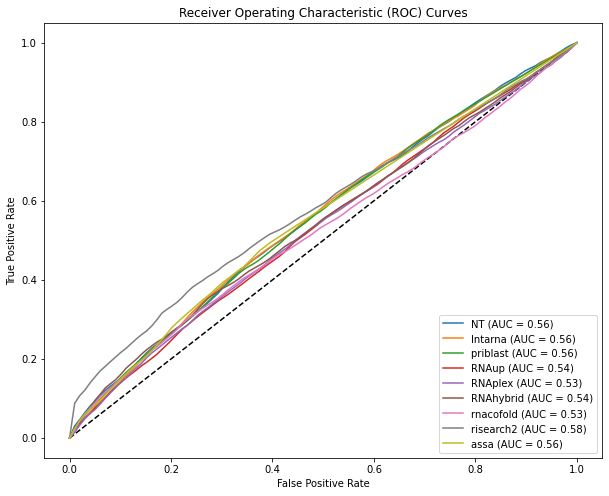

ephnen


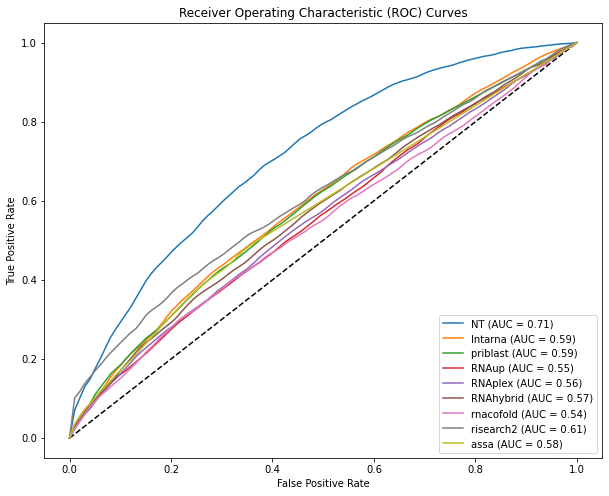

enhn500


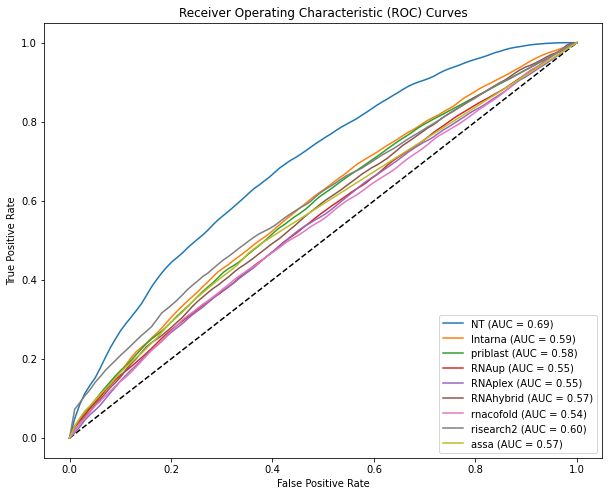

In [27]:
args_datasets['ricseq']['filter_hq_ricseq'] = True


how, dataset = 'ricseq', 'ricseq'
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS,
                         args_datasets[how]['PARIS_HQ'],
                         args_datasets[how]['PARIS_HQ_THRESHOLD'],
                         False,)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
#easypos_smartneg = balance_df(easypos_smartneg) #oversampling
dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))

ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
#ephnen = balance_df(ephnen) #oversampling
dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))



enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             True
                            )   

pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS, 
                         args_datasets[how]['PARIS_HQ'],
                         args_datasets[how]['PARIS_HQ_THRESHOLD'],
                         False,
                        )

pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
enhn500 = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
#enhn500 = balance_df(enhn500).reset_index(drop = True) #oversampling


print(f'DATASET: {dataset}')
print('easypos_smartneg')
plot_all_model_auc(easypos_smartneg, tools)
print('ephnen')
plot_all_model_auc(ephnen, tools)
print('enhn500')
plot_all_model_auc(enhn500, tools)
print('\n\n')

In [ ]:
dfs = []

aucs_epsn = []
aucs_enhn500 = []
aucs_enhn = []
n_positives_run = []

dataset, how = 'ricseq', 'ricseq'

list_of_n_reads_ricseq = [2,3,4,5,6,7]

for N_READS_RICSEQ in list_of_n_reads_ricseq:
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             N_READS_RICSEQ, 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}_nread{N_READS_RICSEQ}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}_nread{N_READS_RICSEQ}'}, axis = 1))
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 N_READS_RICSEQ, 
                                 SPECIE_PARIS,
                                 args_datasets[how]['PARIS_HQ'],
                                 args_datasets[how]['PARIS_HQ_THRESHOLD'],
                                 True
                                )   
    
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             N_READS_RICSEQ, 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,
                            )
    
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    
    n_positives_run.append(pos.shape[0])
    
    enhn500 = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
    dfs.append(obtain_all_model_auc(enhn500, tools).rename({'auc': f'auc_EPENHN500_{dataset}_nread{N_READS_RICSEQ}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69
# excluded couples:  69


TASK:  EPSN


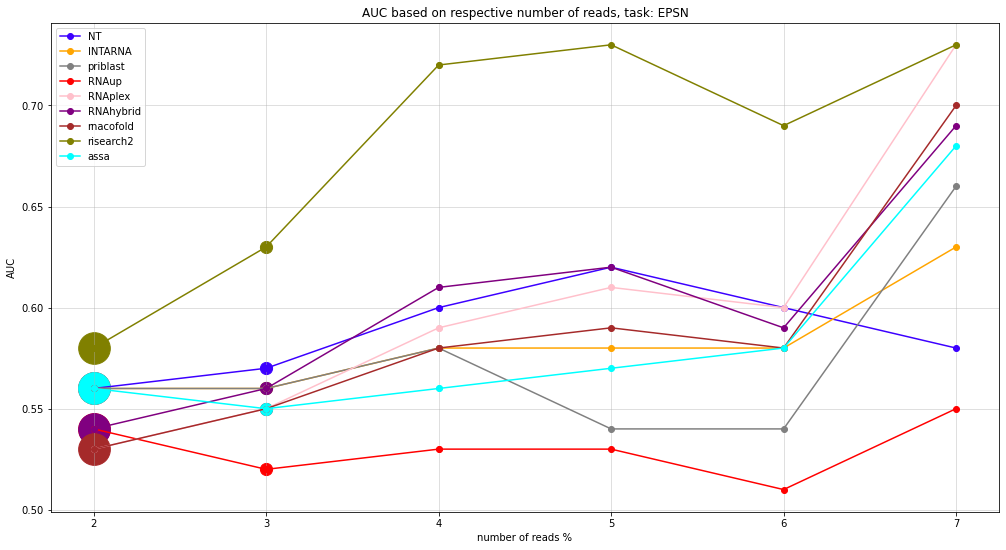




TASK:  EPENHN


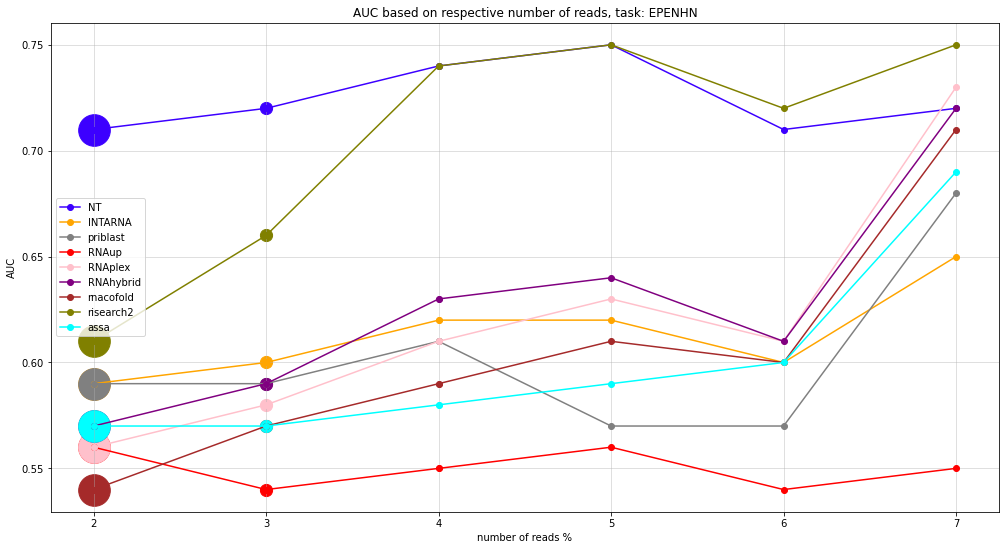




TASK:  EPENHN500


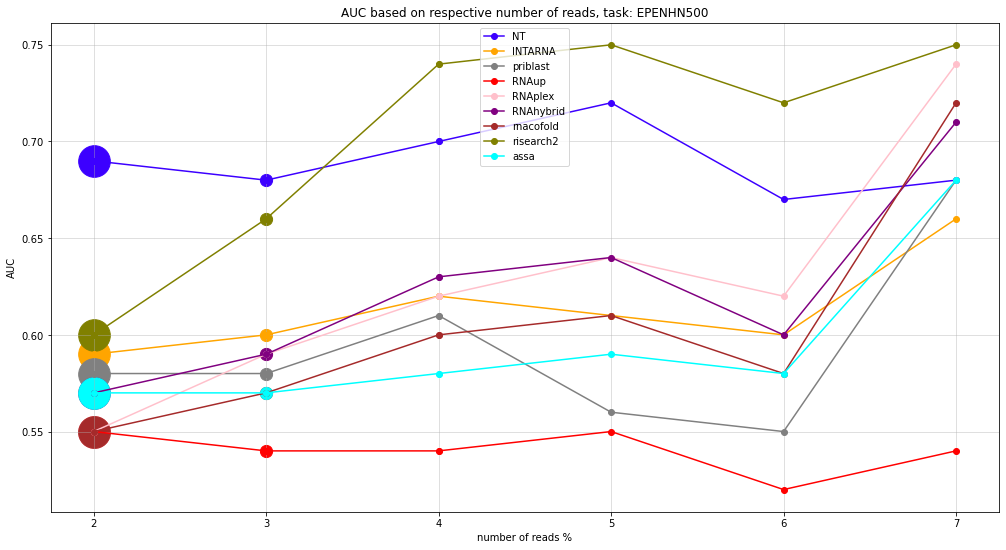

In [ ]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'number of reads'
figsize = (17,9)

for task_name in ['EPSN', 'EPENHN', 'EPENHN500']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for N_READS_RICSEQ in list_of_n_reads_ricseq:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_{dataset}_nread{N_READS_RICSEQ}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)
        
    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_n_reads_ricseq, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

# TODO

Aggiungi:

- Unire paris e splash nel test set?

Fai check sulla dipendenza dei risultati in basse alle lunghezze (prime analisi dello script plot_results500) in tutti i set. 

Rendi le confidenze dei modelli piu alte, bisognerebbe avere un modello con slope maggiori (rank percentile)

# Sigmoidi a mano

In [13]:
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, 'test', how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
easypos_smartneg = balance_df(easypos_smartneg)


ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
ephnen = balance_df(ephnen)

# excluded couples:  56


In [14]:
def evaluate_threshold(df, model_column, threshold):
    mapped_signal = map_signal_to_sigmoid_range(df[model_column], threshold)
    mapped_signal = 1 - mapped_signal  # Invert for interpretation
    accuracy_gt_1 = ((mapped_signal < 0.5) & (df['ground_truth'] == 0)).mean()
    accuracy_lt_0 = ((mapped_signal >= 0.5) & (df['ground_truth'] == 1)).mean()
    total_accuracy = (accuracy_gt_1 + accuracy_lt_0) / 2  # Average accuracy
    return total_accuracy

In [15]:
df_s = easypos_smartneg.copy() 
#df_s = ephnen.copy()  

energy_columns = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa', 'E_norm']

best_thresholds = {}
for model_column in tqdm(energy_columns):
    best_accuracy = -1
    best_threshold = None
    min_treshold = df_s[model_column].mean() - (2 * df_s['assa'].std())
    max_treshold = df_s[model_column].mean() + (2 * df_s['assa'].std())
    max_treshold = min(0, max_treshold)
    # Define the range of potential threshold values
    potential_thresholds = np.linspace(min_treshold, max_treshold, 1_000)
    
    for threshold in potential_thresholds:
        accuracy = evaluate_threshold(df_s, model_column, threshold)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    best_thresholds[model_column] = best_threshold

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
def custom_sigmoid(x, slope_at_origin=2):
    return 0.5 + 0.5 * np.tanh(x * slope_at_origin)

def map_signal_to_sigmoid_range(signal, threshold, slope_at_origin = 2):
    mapped_signal = custom_sigmoid((signal - threshold), slope_at_origin = slope_at_origin)
    return mapped_signal

def plot_histogram_01(data, bins = 50):

    # Plot histogram
    n, bins, patches = plt.hist(data, density=True, bins=bins, alpha=0)  # Plot without displaying

    # Get the maximum value in the histogram
    max_density = max(n)

    # Scale the y-values
    n_scaled = [val / max_density for val in n]

    # Plot the scaled histogram
    plt.bar(bins[:-1], n_scaled, width=bins[1]-bins[0], color = 'orange')


In [108]:
logistic_regression_models

{'priblast': {'intercept': -1.3729273603119811,
  'coef': -0.13055111465860883,
  'threshold_value': -10.52},
 'RNAup': {'intercept': -2.341296324685742,
  'coef': -0.21942916759378597,
  'threshold_value': -10.67},
 'RNAplex': {'intercept': -0.24903541088269093,
  'coef': -0.006645756105272504,
  'threshold_value': -37.47},
 'RNAhybrid': {'intercept': -0.75438522457696,
  'coef': -0.0031159363588686754,
  'threshold_value': -242.11},
 'rnacofold': {'intercept': -0.6501092692929774,
  'coef': -0.0018752864445753833,
  'threshold_value': -346.67},
 'risearch2': {'intercept': -1.7936333925752106,
  'coef': -0.04051979821861928,
  'threshold_value': -44.27},
 'assa': {'intercept': -0.775193436517752,
  'coef': -0.07405544876174112,
  'threshold_value': -10.47},
 'E_norm': {'intercept': -1.716455777935475,
  'coef': -1.2058447675680437,
  'threshold_value': -1.42}}

In [18]:
best_thresholds

{'priblast': -10.663736035234816,
 'RNAup': -11.763679926847502,
 'RNAplex': -50.284463224637825,
 'RNAhybrid': -218.89743005947864,
 'rnacofold': -328.28183975767047,
 'risearch2': -46.44063492593665,
 'assa': -14.423598985990882,
 'E_norm': -1.301451154072943}

In [19]:
slope_at_the_origins = {
    'priblast':0.1,
    'RNAup':0.5, 
    'RNAplex':0.1, 
    'RNAhybrid':0.03,
    'rnacofold':0.02,
    'risearch2':0.1, 
    'assa':0.2,
    'E_norm':2,
}

------- priblast -------


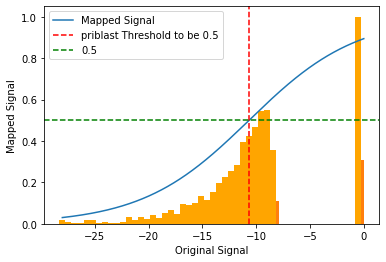

------- RNAup -------


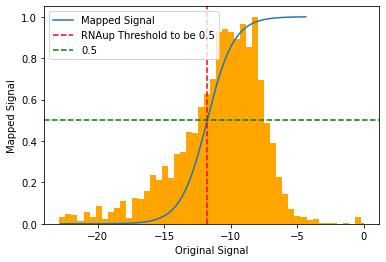

------- RNAplex -------


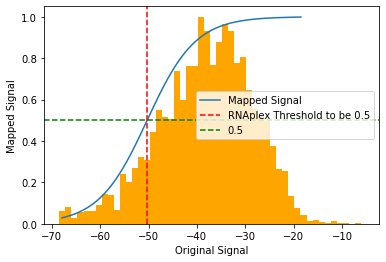

------- RNAhybrid -------


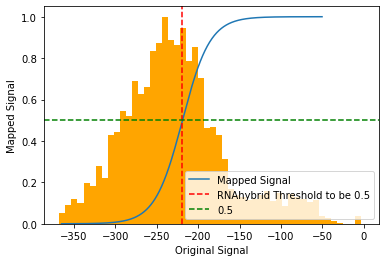

------- rnacofold -------


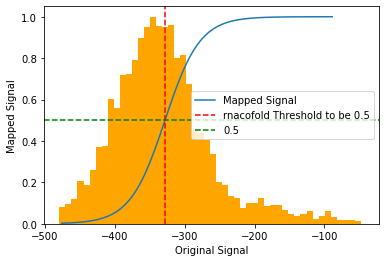

------- risearch2 -------


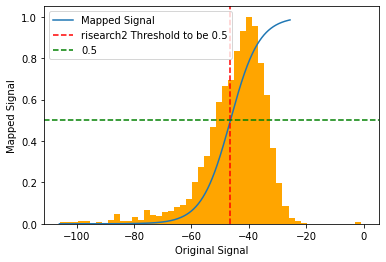

------- assa -------


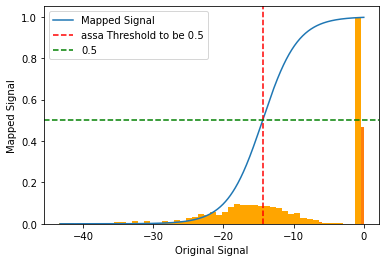

------- E_norm -------


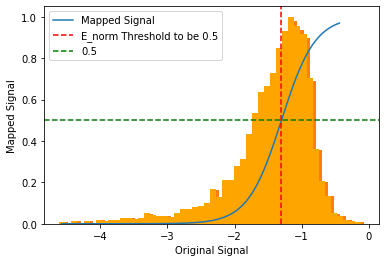

In [20]:
for tool_name in energy_columns:

    print(f'------- {tool_name} -------')
    treshold =  best_thresholds[tool_name]
    min_value_to_plot = res[tool_name].quantile(0.01)
    max_value_to_plot = res[tool_name].quantile(0.99)
    slope_at_origin = slope_at_the_origins[tool_name]

    # Example usage
    signal_range = np.linspace(min_value_to_plot, max_value_to_plot, 1000)


    mapped_signal = map_signal_to_sigmoid_range(signal_range,treshold, slope_at_origin = slope_at_origin)

    data_balanced = balance_df(res)
    data_balanced = data_balanced[data_balanced[tool_name]>min_value_to_plot].reset_index(drop = True)


    # Plotting the results
    plt.plot(signal_range, mapped_signal, label='Mapped Signal')
    plot_histogram_01(data_balanced[tool_name])

    #plt.hist(data_balanced[tool_name], density=True, bins=80) 
    plt.axvline(x=treshold, color='r', linestyle='--', label=f'{tool_name} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
    plt.xlabel('Original Signal')
    plt.ylabel('Mapped Signal')
    plt.legend()
    plt.show()